# Code for Master Thesis at ELTE titled: Collaborative Filtering Techniques on Alleviating the Cold Start Problem in Music Recommendation
Some snippets of this code is based on https://github.com/magronp/ncacf as it is based on the continuation of their work on the NCACF model.

In [ ]:
!pip install arff
!pip install bottleneck
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4948 sha256=9bcb2c75d97b1fe0ce27a4f2b7378f1b895f2bdf81ae36f3de663a8923fd63dc
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB

In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
import numpy as np
import pandas as pd
import arff
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
import shutil
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import copy
from torch.nn import Module, ModuleList, Linear, Sequential, ReLU, Embedding, Sigmoid, Identity
from torch.utils.data import Dataset
import scipy.sparse
import bottleneck as bn
from scipy import sparse
import matplotlib
%matplotlib inline
from joblib import Parallel, delayed
from torch.nn import Dropout

# Load Data
I upload the files from my drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.makedirs('/content/data')

In [ ]:
# src_folder = '/content/drive/MyDrive/Thesis/Apr3/new'
# dest_folder = '/content/data'


# # Copy the entire directory tree from the source folder to the destination folder
# shutil.copytree(src_folder, dest_folder)

'/content/data'

In [ ]:
# src_folder = '/content/drive/MyDrive/Thesis/Apr3/outputsdropout/outputs'
# dest_folder = '/content/outputs'


# # Copy the entire directory tree from the source folder to the destination folder
# shutil.copytree(src_folder, dest_folder)

'/content/outputs'

In [ ]:
##COPIES ONLY MAIN FILES
# def copyFromDrive(files):
#   src_folder='/content/drive/MyDrive/Thesis/Apr3/data'
#   dest_folder = '/content/data'
#   files_to_copy = files
#   for filename in files_to_copy:
#       src_path = os.path.join(src_folder, filename)
#       dest_path = os.path.join(dest_folder, filename)
#       shutil.copy(src_path, dest_path)

In [ ]:
!wget http://millionsongdataset.com/sites/default/files/challenge/train_triplets.txt.zip
!unzip train_triplets.txt.zip

# Getting the Dataset

 you will need to get the data from the [Million Song Dataset](http://millionsongdataset.com/) to reproduce the results.

* The [playcounts](http://millionsongdataset.com/sites/default/files/challenge/train_triplets.txt.zip) from the Taste Profile set.
* The list of [unique tracks](http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt).

You will also need the pre-computed Statistical Spectrum Descriptors as acoustic data. These are available [online](http://www.ifs.tuwien.ac.at/mir/msd/download.html) (download the file `msd-ssd-v1.0.arff.gz`).

All the files should be unziped (if needed) and placed in the `data/` folder.
Note that you can change the folder structure, as long as you change the path accordingly in the code.

# Util Functions
Function to find optimal model parameters for models on validation scores.
lW: regularization coeefficient for user embeddings.
lH: regularization coefficient for item embeddings (H)
 By tuning these regularization coefficients, you can control the trade-off between fitting the data well and maintaining a simpler model with smaller embedding values. This can help in achieving better generalization performance on new, unseen data.

In [ ]:
def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    return

def get_optimal_val_model_lambda(model, setting_list, variant_list, n_epochs, range_lW, range_lH=None):

    for setting in setting_list:
        for variant in variant_list:
            # Define the path where to perform validation
            path_val = 'outputs/' + setting + '/' + model + '/' + variant + '/'

            if variant == 'strict':
                get_optimal_val_model_lW(path_val, range_lW, n_epochs)
            else:
                get_optimal_val_model_lW_lH(path_val, range_lW, range_lH, n_epochs)

    return


def get_optimal_val_model_lW_lH(path_val, range_lW, range_lH, n_epochs):

    # Load the validation score for the pretrained models
    Nw, Nh = len(range_lW), len(range_lH)
    val_ndcg = np.zeros((Nw, Nh, n_epochs))
    for iW, lW in enumerate(range_lW):
        for iH, lH in enumerate(range_lH):
            path_ndcg = path_val + 'lW_' + str(lW) + '/lH_' + str(lH) + '/training.npz'
            val_ndcg[iW, iH, :] = np.load(path_ndcg)['val_ndcg'][:n_epochs] * 100

    # Get the optimal hyperparameters
    ind_opt = np.unravel_index(np.argmax(val_ndcg, axis=None), val_ndcg.shape)
    lW_opt, lH_opt = range_lW[ind_opt[0]], range_lH[ind_opt[1]]
    np.savez(path_val + 'hyperparams.npz', lW=lW_opt, lH=lH_opt)
    np.savez(path_val + 'val_ndcg.npz', val_ndcg=val_ndcg, range_lW=range_lW, range_lH=range_lH)

    # Get the optimal model / training log / (WMF) and copy it to the main parent folder
    path_opt = path_val + 'lW_' + str(lW_opt) + '/lH_' + str(lH_opt) + '/'
    files_opt = os.listdir(path_opt)
    for f in files_opt:
        shutil.copyfile(path_opt + f, path_val + f)

    return



def get_optimal_val_model_lW(path_val, range_lW, n_epochs):

    # Load the validation score for the pretrained models
    Nw = len(range_lW)
    val_ndcg = np.zeros((Nw, n_epochs))
    for iW, lW in enumerate(range_lW):
            path_ndcg = path_val + 'lW_' + str(lW) + '/training.npz'
            val_ndcg[iW, :] = np.load(path_ndcg)['val_ndcg'][:n_epochs] * 100

    # Get the optimal hyperparameters
    ind_opt = np.unravel_index(np.argmax(val_ndcg, axis=None), val_ndcg.shape)
    lW_opt = range_lW[ind_opt[0]]
    np.savez(path_val + 'hyperparams.npz', lW=lW_opt, lH=0.)
    np.savez(path_val + 'val_ndcg.npz', val_ndcg=val_ndcg, range_lW=range_lW)

    # Get the optimal model / training log / (WMF) and copy it to the main parent folder
    path_opt = path_val + 'lW_' + str(lW_opt) + '/'
    files_opt = os.listdir(path_opt)
    for f in files_opt:
        shutil.copyfile(path_opt + f, path_val + f)

    return


# Weighted Prediction Error (general formulation)
def wpe_joint(count_i, pred_rat, w, h, h_con, lW, lH=0, alpha=2.0, epsilon=1e-6):

    loss = ((1 + alpha * torch.log(1 + count_i / epsilon)) * (pred_rat - count_i) ** 2).mean() + lW * (w ** 2).mean() +\
           lH * ((h - h_con) ** 2).mean()

    return loss


# Prep Data

**This part here is only to load the data from my drive instead of running the preprocessing every time.**

In [ ]:
#Retrieve pre-processed data from the drive, skip this and continue to preprocessing 

# %cp -av '/content/drive/MyDrive/Thesis/Apr3/data' '/content/'

In [ ]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id, 'count']].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count


def print_density_level(data_dir='/content/data'):

    tp = pd.read_csv(data_dir + 'tp.csv')
    usercount, songcount = get_count(tp, 'uid'), get_count(tp, 'sid')
    density_level = float(tp.shape[0]) / (usercount.shape[0] * songcount.shape[0])
    print("After filtering, there are %d triplets from %d users and %d songs - density: %.3f%%" % (tp.shape[0], usercount.shape[0], songcount.shape[0], density_level*100))

    return density_level


def load_filter_record_tp(data_dir='/content/data', min_uc=20, min_sc=50, min_c=5):

    # Load Taste Profile data
    TP_file = os.path.join(data_dir, 'train_triplets.txt')
    tp = pd.read_table(TP_file, header=None, names=['uid', 'sid', 'count'])

    # Load the list of song IDs in the dataset,
    msd_track_file = os.path.join(data_dir, 'unique_tracks.txt')
    list_sids = list(pd.read_table(msd_track_file, header=None, sep='<SEP>', usecols=[1], engine='python')[1])

    # Keep the TP data whose sid are in the list of unique tracks
    tp = tp[tp['sid'].isin(list_sids)]

    # Only keep ratings >= min_c, otherwise they're considered not reliable.
    tp = tp[tp['count'] >= min_c]

    # Only keep the triplets for songs which were listened to at least 'min_sc' times
    songcount = get_count(tp, 'sid')
    valid_songs = songcount['sid'][songcount.loc[:, "size"] >= min_sc]
    tp = tp[tp['sid'].isin(valid_songs)]

    # Only keep the triplets for users who listened to at min_uc songs
    usercount = get_count(tp, 'uid')
    valid_users = usercount['uid'][usercount.loc[:, "size"] >= min_uc]
    tp = tp[tp['uid'].isin(valid_users)]

    # Record TP
    tp.to_csv(data_dir + 'tp.csv', index=False)

    return


def load_record_features(data_dir='/content/data'):

    # List of unique songs in the filtered TP data, if not provided as an input
    unique_sid = list(pd.unique(pd.read_csv(data_dir + 'tp.csv')['sid']))

    # Load the list of song IDs in the dataset and corresponding track IDs for mapping the two
    msd_track_file = os.path.join(data_dir, 'unique_tracks.txt')
    tid_sid = pd.read_table(msd_track_file, header=None, sep='<SEP>', usecols=[0, 1], engine='python')
    tid_sid.columns = ['tid', 'sid']
    tid_sid.set_index('tid', inplace=True)

    features_full = np.empty((168, 0))
    list_sid = []

    feat_loader = arff.load(data_dir + 'msd-ssd-v1.0.arff')
    for ii, row in enumerate(feat_loader):
        current_tid = row._values[-1]
        current_sid = tid_sid.loc[current_tid][0]
        if (current_sid in unique_sid) and not(current_sid in list_sid):
            list_sid.append(current_sid)
            features_full = np.concatenate((features_full, np.array(row._values[:-1])[:, np.newaxis]), axis=1)

    # Scale the features and store them into a pandas frame
    features_full = features_full.T
    features_full = scale(features_full, axis=0)
    features_pd = pd.DataFrame(features_full)
    features_pd.insert(0, 'sid', list_sid)

    # Record the list of features
    features_pd.to_csv(data_dir + 'features.csv', index=False)

    return features_pd


def update_tp_record(data_dir='/content/data/', seed=12345):

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Load the TP data
    tp = pd.read_csv(data_dir + 'tp.csv')

    # Get the list of songs ids for which there are features
    unique_sid = pd.unique(pd.read_csv(data_dir + 'features.csv')['sid'])
    n_songs = len(unique_sid)

    # Update the TP songs
    tp = tp[tp['sid'].isin(unique_sid)]
    # Record updated TP
    tp.to_csv(data_dir + 'tp.csv', index=False)

    # Get users in TP
    unique_uid = pd.unique(tp['uid'])

    # Shuffle songs
    idx = np.random.permutation(np.arange(n_songs))
    unique_sid = unique_sid[idx]

    # Create a dictionary for mapping user/song unique ids to integers
    user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))
    song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))

    # Record TP data, dictionaries and lists of unique sid/uid
    with open(data_dir + 'unique_uid.txt', 'w') as f:
        for uid in unique_uid:
            f.write('%s\n' % uid)

    with open(data_dir + 'unique_sid.txt', 'w') as f:
        for sid in unique_sid:
            f.write('%s\n' % sid)

    with open(data_dir + 'user2id.json', 'w') as f:
        json.dump(user2id, f)

    with open(data_dir + 'song2id.json', 'w') as f:
        json.dump(song2id, f)

    return


def split_cold(data_dir='/content/data', n_splits=10, seed=12345):

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Load Taste profile data and the SSDs features
    tp = pd.read_csv(data_dir + 'tp.csv')
    my_features = pd.read_csv(data_dir + 'features.csv')

    # Load the list of unique songs
    unique_sid = []
    with open(data_dir + 'unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())

    np.random.shuffle(unique_sid)

    # Select 20% of the songs as held-out validation data
    n_songs = len(unique_sid)
    val_sid = unique_sid[:int(0.2 * n_songs)]

    # Get the corresponding validation TP data and features
    val_tp = tp[tp['sid'].isin(val_sid)]
    val_feats = my_features[my_features['sid'].isin(val_sid)]

    # Get the remaining songs IDs
    train_test_sid = np.array(unique_sid[int(0.2 * n_songs):])

    # Perform K splits on the remaining data (train and test)
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(train_test_sid)
    for i_split, (train_index, test_index) in enumerate(kf.split(train_test_sid)):
        # Songs IDs
        train_sid = train_test_sid[train_index]
        test_sid = train_test_sid[test_index]

        # Corresponding TP data
        train_tp = tp[tp['sid'].isin(train_sid)]
        test_tp = tp[tp['sid'].isin(test_sid)]

        # Corresponding features
        train_feats = my_features[my_features['sid'].isin(train_sid)]
        test_feats = my_features[my_features['sid'].isin(test_sid)]

        # Define the current split folder
        current_path = data_dir + 'cold/split' + str(i_split) + '/'
        create_folder(current_path)

        # Save the .csv (TP data and features)
        train_tp.to_csv(current_path + 'train_tp.csv', index=False)
        val_tp.to_csv(current_path + 'val_tp.csv', index=False)
        test_tp.to_csv(current_path + 'test_tp.csv', index=False)

        train_feats.to_csv(current_path + 'train_feats.csv', index=False)
        val_feats.to_csv(current_path + 'val_feats.csv', index=False)
        test_feats.to_csv(current_path + 'test_feats.csv', index=False)

        # Save a copy of the list of unique sid/uid in each directory for convenience
        shutil.copyfile(data_dir + 'unique_sid.txt', current_path + 'unique_sid.txt')
        shutil.copyfile(data_dir + 'unique_uid.txt', current_path + 'unique_uid.txt')

    return


def numerize_cold(data_dir='data/', n_splits=10):

    # Load the user and song to id mappings
    with open(data_dir + 'user2id.json', 'r') as f:
        user2id = json.load(f)
    with open(data_dir + 'song2id.json', 'r') as f:
        song2id = json.load(f)

    # Numerize all the subsets / splits
    setting = 'cold'
    for i_split in range(n_splits):
        for subset_to_numerize in ['train', 'test', 'val']:
            current_path = data_dir + setting + '/split' + str(i_split) + '/' + subset_to_numerize

            # TP data
            data_tp = pd.read_csv(current_path + '_tp.csv')
            uid = list(map(lambda x: user2id[x], data_tp['uid']))
            sid = list(map(lambda x: song2id[x], data_tp['sid']))
            data_tp['uid'] = uid
            data_tp['sid'] = sid
            data_tp.to_csv(current_path + '_tp.num.csv', index=False)

            # Features
            data_feats = pd.read_csv(current_path + '_feats.csv')
            sid = list(map(lambda x: song2id[x], data_feats['sid']))
            data_feats = data_feats.assign(sid=sid)
            data_feats.to_csv(current_path + '_feats.num.csv', index=False)

    return


def split_warm(data_dir='data/', n_splits=10, seed=12345):

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Load Taste profile data
    tp = pd.read_csv(data_dir + 'tp.csv')

    # Load the list of unique songs
    unique_sid = []
    with open(data_dir + '/unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())

    # Pick out 20% of the binarized playcounts for warm-start validation
    n_playcounts = tp.shape[0]
    vval = np.random.choice(n_playcounts, size=int(0.2 * n_playcounts), replace=False)
    val_idx = np.zeros(n_playcounts, dtype=bool)
    val_idx[vval] = True
    val_tp = tp[val_idx]

    # Get the remaining data for train/test, as well as the corresponding indices
    train_test_tp = tp[~val_idx]
    train_test_idx = np.array(train_test_tp.index.values.tolist())
    np.random.shuffle(train_test_idx)

    # Perform K splits on the remaining data (train and test)
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(train_test_idx)

    for i_split, (train_index, test_index) in enumerate(kf.split(train_test_idx)):

        # Indices
        train_idx = train_test_idx[train_index]
        test_idx = train_test_idx[test_index]

        # Corresponding TP data
        train_tp = train_test_tp.loc[train_idx]
        test_tp = train_test_tp.loc[test_idx]

        # Define the current split folder
        current_path = data_dir + 'warm/split' + str(i_split) + '/'
        create_folder(current_path)

        # Save the .csv (TP data and features)
        train_tp.to_csv(current_path + 'train_tp.csv', index=False)
        val_tp.to_csv(current_path + 'val_tp.csv', index=False)
        test_tp.to_csv(current_path + 'test_tp.csv', index=False)

        # Save a copy of the list of unique sid/uid in each directory for convenience
        shutil.copyfile(data_dir + 'unique_sid.txt', current_path + 'unique_sid.txt')
        shutil.copyfile(data_dir + 'unique_uid.txt', current_path + 'unique_uid.txt')

        # Copy the features in each subfolder
        shutil.copyfile(data_dir + 'features.csv', current_path + 'features.csv')

    return


def numerize_warm(data_dir='/content/data', n_splits=10):

    # Load the user and song to id mappings
    with open(data_dir + 'user2id.json', 'r') as f:
        user2id = json.load(f)
    with open(data_dir + 'song2id.json', 'r') as f:
        song2id = json.load(f)

    # Numerize all the subsets / splits
    setting = 'warm'
    for i_split in range(n_splits):
        for subset_to_numerize in ['train', 'test', 'val']:
            current_path = data_dir + setting + '/split' + str(i_split) + '/' + subset_to_numerize

            # TP data
            data_tp = pd.read_csv(current_path + '_tp.csv')
            uid = list(map(lambda x: user2id[x], data_tp['uid']))
            sid = list(map(lambda x: song2id[x], data_tp['sid']))
            data_tp['uid'] = uid
            data_tp['sid'] = sid
            data_tp.to_csv(current_path + '_tp.num.csv', index=False)

        # Features
        current_path = data_dir + setting + '/split' + str(i_split) + '/'
        data_feats = pd.read_csv(current_path + 'features.csv')
        sid = list(map(lambda x: song2id[x], data_feats['sid']))
        data_feats = data_feats.assign(sid=sid)
        data_feats.to_csv(current_path + 'feats.num.csv', index=False)

    return

In [ ]:
MIN_USER_COUNT, MIN_SONG_COUNT, MIN_COUNT = 20, 50, 7
data_dir = '/content/data/'
n_splits = 10
seed = 12345

# Load the TP data and filter out inactive data
load_filter_record_tp(data_dir, min_uc=MIN_USER_COUNT, min_sc=MIN_SONG_COUNT, min_c=MIN_COUNT)

# Process the song features
load_record_features(data_dir)

# Update the TP songs (to keep only those for which there are available features), and print the density level
update_tp_record(data_dir, seed=seed)
density_level = print_density_level(data_dir)

# Create the various splits (and numerize files) for the cold-start scenario
split_cold(data_dir=data_dir, n_splits=n_splits, seed=seed)
numerize_cold(data_dir=data_dir, n_splits=n_splits)

# Same for the warm-start scenario
split_warm(data_dir=data_dir, n_splits=n_splits, seed=seed)
numerize_warm(data_dir=data_dir, n_splits=n_splits)

After filtering, there are 509177 triplets from 17572 users and 13532 songs - density: 0.214%


In [ ]:
#!cp -r /content/data /content/drive/MyDrive/Thesis/data

## Dataset Analytics

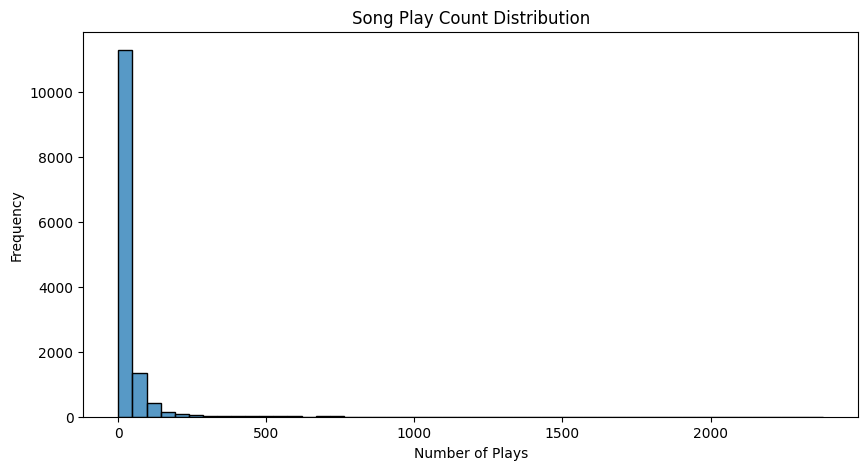

The mean song play count is 37.63, while the median is 18.00.


In [ ]:
song_playcounts = tp['sid'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(song_playcounts, kde=False, bins=50)
plt.xlabel('Number of Plays')
plt.ylabel('Frequency')
plt.title('Song Play Count Distribution')
plt.show()

# Output key observations
mean_song_playcount = song_playcounts.mean()
median_song_playcount = song_playcounts.median()
print(f"The mean song play count is {mean_song_playcount:.2f}, while the median is {median_song_playcount:.2f}.")


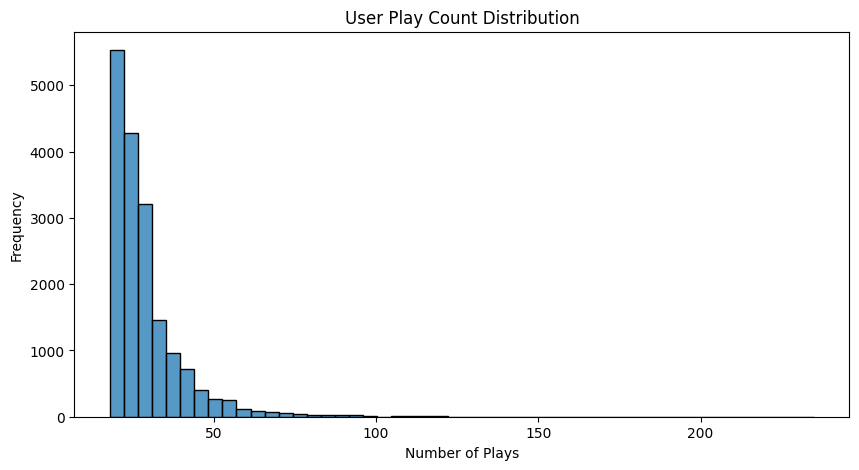

The mean user play count is 28.98, while the median is 25.00.


In [ ]:
user_playcounts = tp['uid'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(user_playcounts, kde=False, bins=50)
plt.xlabel('Number of Plays')
plt.ylabel('Frequency')
plt.title('User Play Count Distribution')
plt.show()

# Output key observations
mean_user_playcount = user_playcounts.mean()
median_user_playcount = user_playcounts.median()
print(f"The mean user play count is {mean_user_playcount:.2f}, while the median is {median_user_playcount:.2f}.")


#Training Validation
perform validation over the hyperparameters.

## Helper functions
Data feeders

In [ ]:
def load_tp_data(csv_file, setting='warm', alpha=2.0, epsilon=1e-6):

    # Get the number of users and songs in the eval set as well as the dataset for evaluation
    n_users = len(open('data/unique_uid.txt').readlines())
    n_songs_total = len(open('data/unique_sid.txt').readlines())

    # Load the TP data in csv format
    tp = pd.read_csv(csv_file)

    # Get the list of songs, user, and counts
    rows, cols = np.array(tp['uid'], dtype=np.int32), np.array(tp['sid'], dtype=np.int32)
    count = tp['count']

    # Build the sparse matrix
    sparse_tp = scipy.sparse.csr_matrix((count, (rows, cols)), dtype=np.int16, shape=(n_users, n_songs_total))

    # Now only retain the non-empty cols of the matrix (useful in the cold-start setting)
    if setting == 'cold':
        sparse_tp = sparse_tp[:, np.unique(cols)]

    # Binarize the playcounts
    sparse_tp.data = np.ones_like(sparse_tp.data)

    # Get the confidence
    conf = sparse_tp.copy()
    conf.data = alpha * np.log(1 + conf.data / epsilon)

    return sparse_tp, rows, cols, conf

In [ ]:
class DatasetPlaycounts(Dataset):

    def __init__(self, features_path, tp_path):

        # Acoustic content features
        features = pd.read_csv(features_path).to_numpy()

        # Sort along the first col (list of SID) to have them in ascending order (it corresponds to the csv data)
        features = features[features[:, 0].argsort()]

        # The first column is the (num) SID, so keep it as a mapping between data point and sid
        self.datapoint2sid = features[:, 0]

        # And now remove the SID colmn
        x = np.delete(features, 0, axis=1)
        self.x = torch.tensor(x).float()

        # TP data
        self.tp_data = pd.read_csv(tp_path)

        # Store the number of users and songs in the current subset
        self.n_users = len(np.unique(self.tp_data['uid']))
        self.n_songs = len(np.unique(self.tp_data['sid']))

    def __len__(self):
        return self.n_songs

    def __getitem__(self, data_point):
        data_sid = self.datapoint2sid[data_point]
        u_pos = torch.tensor(self.tp_data[self.tp_data['sid'] == data_sid]['uid'].to_numpy(), dtype=torch.long)
        u_counts = torch.zeros(self.n_users)
        u_counts[u_pos] = 1
        return self.x[data_point, :], u_counts, data_point


In [ ]:
class DatasetAttributes(Dataset):

    def __init__(self, wmf_path, features_path):

        # Acoustic content features
        features = pd.read_csv(features_path).to_numpy()

        # Sort along the first col (list of SID) to have them in ascending order (it corresponds to the csv data)
        features = features[features[:, 0].argsort()]

        # The first column is the (num) SID, so keep it as a mapping between data point and sid
        self.datapoint2sid = features[:, 0]

        # And now remove the SID colmn
        x = np.delete(features, 0, axis=1)

        # WMF song attributes (no need to sort since it is computed from the .csv data, so it's already ordered)
        if wmf_path is None:
            h = x
        else:
            h = np.load(wmf_path)['H']

        self.x = torch.Tensor(x).float()
        self.h = torch.Tensor(h).float()

        # Store the number songs in the current subset
        self.n_songs = self.x.size()[0]

    def __len__(self):
        return self.n_songs

    def __getitem__(self, item):
        return self.x[item, :], self.h[item, :], item

## Evaluation and Plotters

### NDCG

In [ ]:
# Generate of list of user indexes for each batch
def user_idx_generator(n_users, batch_users):
    for start in range(0, n_users, batch_users):
        end = min(n_users, start + batch_users)
        yield slice(start, end)

In [ ]:
# NDCG for out-of-matrix prediction
def my_ndcg_cold(true_ratings, pred_ratings, batch_users=5000, k=None):

    # Iterate over user batches
    res = list()
    for user_idx in user_idx_generator(true_ratings.shape[0], batch_users):
        true_ratings_batch = true_ratings[user_idx]
        pred_ratings_batch = pred_ratings[user_idx, :]
        if k is None:
            ndcg_curr_batch = my_ndcg_batch(true_ratings_batch, pred_ratings_batch)
        else:
            ndcg_curr_batch = my_ndcg_k_batch(true_ratings_batch, pred_ratings_batch, k)
        res.append(ndcg_curr_batch)

    # Get the mean and std NDCG over users
    ndcg = np.hstack(res)
    # Replace 0s with Nans to take nanmean and avoid warnings
    ndcg[ndcg == 0] = np.nan
    ndcg_mean = np.nanmean(ndcg)

    return ndcg_mean

In [ ]:
# NDCG for a given batch
def my_ndcg_batch(true_ratings, pred_ratings):

    all_rank = np.argsort(np.argsort(-pred_ratings, axis=1), axis=1)

    # build the discount template
    tp = 1. / np.log2(np.arange(2, true_ratings.shape[1] + 2))
    all_disc = tp[all_rank]

    # Binarize the true ratings
    true_ratings_bin = (true_ratings > 0).tocoo()

    # Get the disc
    disc = sparse.csr_matrix((all_disc[true_ratings_bin.row, true_ratings_bin.col], (true_ratings_bin.row, true_ratings_bin.col)),shape=all_disc.shape)

    # DCG, ideal DCG and normalized DCG
    dcg = np.array(disc.sum(axis=1)).ravel()
    idcg = np.array([tp[:n].sum() for n in true_ratings.getnnz(axis=1)])
    ndcg = dcg / (idcg + 1e-8)

    return ndcg

In [ ]:
# NDCG at k for a given batch
def my_ndcg_k_batch(true_ratings, pred_ratings, k=100):

    n_users_currbatch = true_ratings.shape[0]
    idx_topk_part = bn.argpartition(-pred_ratings, k, axis=1)
    topk_part = pred_ratings[np.arange(n_users_currbatch)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(n_users_currbatch)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    dcg = (true_ratings[np.arange(n_users_currbatch)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    idcg = np.array([(tp[:min(n, k)]).sum() for n in true_ratings.getnnz(axis=1)])
    ndcg = dcg / (idcg + 1e-8)

    return ndcg

In [ ]:
def my_ndcg_warm(true_ratings, pred_ratings, batch_users=5000, k=None, leftout_ratings=None):

    n_users, n_songs = true_ratings.shape
    predicted_ratings = np.copy(pred_ratings)

    # Remove predictions on the left-out ratings ('train' for validation, and 'train+val' for testing)
    if leftout_ratings is not None:
        item_idx = np.zeros((n_users, n_songs), dtype=bool)
        item_idx[leftout_ratings.nonzero()] = True
        predicted_ratings[item_idx] = -np.inf

    # Loop over user batches
    res = list()
    for user_idx in user_idx_generator(n_users, batch_users):
        # Take a batch
        true_ratings_batch = true_ratings[user_idx]
        pred_ratings_batch = predicted_ratings[user_idx, :]
        # Call the NDCG for the current batch (depending on k)
        # If k not specified, compute the whole (standard) NDCG instead of its truncated version NDCG@k
        if k is None:
            ndcg_curr_batch = my_ndcg_in_batch(true_ratings_batch, pred_ratings_batch)
        else:
            ndcg_curr_batch = my_ndcg_in_k_batch(true_ratings_batch, pred_ratings_batch, k)
        res.append(ndcg_curr_batch)

    # Stack and get mean and std over users
    ndcg = np.hstack(res)
    # Replace 0s with Nans to take nanmean and avoid warnings
    ndcg[ndcg == 0] = np.nan
    ndcg_mean = np.nanmean(ndcg)
    ndcg_std = np.nanstd(ndcg)

    return ndcg_mean, ndcg_std


In [ ]:
def my_ndcg_in_batch(true_ratings, pred_ratings):

    all_rank = np.argsort(np.argsort(-pred_ratings, axis=1), axis=1)

    # build the discount template
    tp = 1. / np.log2(np.arange(2, true_ratings.shape[1] + 2))
    all_disc = tp[all_rank]

    # Binarize the true ratings
    true_ratings_bin = (true_ratings > 0).tocoo()

    # Get the disc
    disc = sparse.csr_matrix((all_disc[true_ratings_bin.row, true_ratings_bin.col], (true_ratings_bin.row, true_ratings_bin.col)), shape=all_disc.shape)

    # DCG, ideal DCG and normalized DCG
    dcg = np.array(disc.sum(axis=1)).ravel()
    idcg = np.array([tp[:n].sum() for n in true_ratings.getnnz(axis=1)])
    ndcg = dcg / (idcg + 1e-8)

    return ndcg

In [ ]:
def my_ndcg_in_k_batch(true_ratings_batch, pred_ratings_batch, k=100):

    n_users_currbatch = true_ratings_batch.shape[0]
    idx_topk_part = bn.argpartition(-pred_ratings_batch, k, axis=1)
    topk_part = pred_ratings_batch[np.arange(n_users_currbatch)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(n_users_currbatch)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    dcg = (true_ratings_batch[np.arange(n_users_currbatch)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    idcg = np.array([(tp[:min(n, k)]).sum() for n in true_ratings_batch.getnnz(axis=1)])
    ndcg = dcg / (idcg + 1e-8)

    return ndcg

In [ ]:
def evaluate_uni_cold(params, my_model, split='val'):

    # Paths for features and TP
    path_features = os.path.join(params['data_dir'], split + '_feats.num.csv')
    tp_path = os.path.join(params['data_dir'], split + '_tp.num.csv')

    # Define a data loader
    my_dataset_eval = DatasetAttributes(wmf_path=None, features_path=path_features)
    my_dataloader_eval = DataLoader(my_dataset_eval, params['batch_size'], shuffle=False, drop_last=False)

    # Get the number of users and songs
    n_users = len(open(params['data_dir'] + 'unique_uid.txt').readlines())
    n_songs = my_dataset_eval.n_songs

    # Compute the model output (predicted ratings)
    us_total = torch.arange(0, n_users, dtype=torch.long).to(params['device'])
    pred_ratings = np.zeros((n_users, n_songs))
    it_inp = torch.tensor([-1], dtype=torch.long).to(params['device'])
    my_model.eval()
    with torch.no_grad():
        for data in tqdm(my_dataloader_eval, desc='Computing predicted ratings', unit=' Songs'):
            pred = my_model(us_total, data[0].to(params['device']), it_inp)[0]
            pred_ratings[:, data[2]] = pred.cpu().detach().numpy().squeeze()

    # Load the evaluation subset true ratings
    eval_data = load_tp_data(tp_path, setting='cold')[0]

    # Get the score
    ndcg_mean = my_ndcg_cold(eval_data, pred_ratings, k=50)

    return ndcg_mean

In [ ]:
def evaluate_uni_warm(params, my_model, split='val'):
    data_dir = '/content/data/'
    # Paths for features
    path_features = os.path.join(params['data_dir'], 'feats.num.csv')

    # Predict the attributes and ratings
    # Define a data loader
    my_dataset_eval = DatasetAttributes(wmf_path=None, features_path=path_features)
    my_dataloader_eval = DataLoader(my_dataset_eval, params['batch_size'], shuffle=False, drop_last=False)

    # Get the number of users and songs
    n_users = len(open(params['data_dir'] + 'unique_uid.txt').readlines())
    n_songs = my_dataset_eval.n_songs

    # Compute the model output
    us_total = torch.arange(0, n_users, dtype=torch.long).to(params['device'])
    pred_ratings = np.zeros((n_users, n_songs))
    my_model.eval()
    with torch.no_grad():
        for data in tqdm(my_dataloader_eval, desc='Computing predicted ratings', unit=' Songs'):
            pred = my_model(us_total, data[0].to(params['device']), data[2].to(params['device']))[0]
            pred_ratings[:, data[2]] = pred.cpu().detach().numpy().squeeze()

    # Load playcount data
    train_data = load_tp_data(os.path.join(params['data_dir'], 'train_tp.num.csv'), setting='warm')[0]
    val_data = load_tp_data(os.path.join(params['data_dir'], 'val_tp.num.csv'), setting='warm')[0]

    # Get the score
    if split == 'val':
        ndcg_mean = my_ndcg_warm(val_data, pred_ratings, k=50, leftout_ratings=train_data)[0]
    else:
        test_data = load_tp_data(os.path.join(params['data_dir'], 'test_tp.num.csv'), setting='warm')[0]
        ndcg_mean = my_ndcg_warm(test_data, pred_ratings, k=50, leftout_ratings=train_data + val_data)[0]

    return ndcg_mean

In [ ]:
def evaluate_uni(params, my_model, setting='cold', split='val'):

    if setting == 'cold':
        ndcg_mean = evaluate_uni_cold(params, my_model, split=split)
    else:
        ndcg_mean = evaluate_uni_warm(params, my_model, split=split)

    return ndcg_mean

### Plotters

In [ ]:
def plot_val_ndcg_mf_uni_relaxed(setting):

    path_ndcg = 'outputs/' + setting + '/mf_uni/relaxed/val_ndcg.npz'

    # Load the overall validation NDCG
    ndcg_loader = np.load(path_ndcg)
    val_ndcg, range_lW, range_lH = ndcg_loader['val_ndcg'], ndcg_loader['range_lW'], ndcg_loader['range_lH']
    Nw = len(range_lW)
    n_epochs = val_ndcg.shape[-1]

    # Plot the results
    plt.figure(figsize=(9.1, 2.55))
    for il, l in enumerate(range_lW):
        plt.subplot(1, Nw, il + 1)
        plt.plot(np.arange(n_epochs) + 1, val_ndcg[il, :, :].T)
        plt.title(r'$\lambda_W$=' + str(l))
        plt.xlabel('Epochs')
        if il == 0:
            plt.ylabel('NDCG (%)')
            leg_lambda = [r'$\lambda_H$=' + str(lh) for lh in range_lH]
            plt.legend(leg_lambda)
    plt.show()
    plt.tight_layout()

    return

In [ ]:
def plot_val_ndcg_mf_uni_strict(setting):

    path_ndcg = 'outputs/' + setting + '/mf_uni/strict/val_ndcg.npz'

    # Load the overall validation NDCG
    ndcg_loader = np.load(path_ndcg)
    val_ndcg, range_lW = ndcg_loader['val_ndcg'], ndcg_loader['range_lW']
    Nw = len(range_lW)
    n_epochs = val_ndcg.shape[-1]

    # Plot the results
    plt.figure(figsize=(9.1, 2.55))
    for il, l in enumerate(range_lW):
        plt.subplot(1, Nw, il + 1)
        plt.plot(np.arange(n_epochs) + 1, val_ndcg[il, :].T)
        plt.title(r'$\lambda_W$=' + str(l))
        plt.xlabel('Epochs')
        if il == 0:
            plt.ylabel('NDCG (%)')
    plt.show()
    plt.tight_layout()

    return

In [ ]:
def plot_val_ndcg_ncacf():

    val_ndcg_warm = np.round(np.load('outputs/warm/ncacf/val_results.npz')['val_ndcg'][:, 1:, :]*100, 1)
    val_ndcg_cold = np.round(np.load('outputs/cold/ncacf/val_results.npz')['val_ndcg'][:, 1:, :]*100, 1)

    plt.figure(figsize=(6.75, 3.2))
    plt.subplot(1, 2, 1)
    plt.title('Warm-start')
    plt.plot(val_ndcg_warm[0, :, :])
    plt.ylabel('NDCG (%)')
    plt.legend(['Relaxed', 'Strict'])
    plt.xlabel('Q')
    plt.subplot(1, 2, 2)
    plt.title('Cold-start')
    plt.plot(val_ndcg_cold[0, :, :])
    plt.xlabel('Q')
    plt.show()
    plt.tight_layout()

    return


In [ ]:
def plot_val_ndcg_and_loss_ncacf_all(setting):
    # Create a figure with 5 rows and 2 columns for subplots
    fig, axs = plt.subplots(5, 2, figsize=(9, 17))

    # Loop through each dimension
    for dim in range(5):
        # Load the training data for this setting and dimension
        training_data = 'outputs/' + setting + '/ncacf/mult/' + str(dim) + '/relaxed/training.npz'
        data_loader = np.load(training_data)
        val_ndcg = data_loader['val_ndcg'] * 100
        loss = data_loader['loss']

        # Plot the val_ndcg values against the epoch number on the first column subplot
        axs[dim, 0].plot(range(1, len(val_ndcg) + 1), val_ndcg)
        axs[dim, 0].set_xlabel('Epoch')
        axs[dim, 0].set_ylabel('NDCG (%)')
        axs[dim, 0].set_title(f'NDCG per Epoch for Setting={setting}, Dim={dim}')
        axs[dim, 0].grid(True)

        # Plot the loss values against the epoch number on the second column subplot
        axs[dim, 1].plot(range(1, len(loss) + 1), loss)
        axs[dim, 1].set_xlabel('Epoch')
        axs[dim, 1].set_ylabel('Loss (%)')
        axs[dim, 1].set_title(f'Loss per Epoch for Setting={setting}, Dim={dim}')
        axs[dim, 1].grid(True)

    # Add space between subplots
    plt.tight_layout()
    plt.show()

## Models

### NCACF

In [ ]:
class ModelAttributes(Module):

    def __init__(self, n_features_in, n_features_hidden, n_embeddings):

        super(ModelAttributes, self).__init__()

        self.fnn_in = Sequential(Linear(n_features_in, n_features_hidden, bias=True), ReLU())
        self.fnn_hi1 = Sequential(Linear(n_features_hidden, n_features_hidden, bias=True), ReLU())
        self.fnn_out = Sequential(Linear(n_features_hidden, n_embeddings, bias=True))

    def forward(self, x):

        # Apply NN
        y = self.fnn_in(x)
        y = self.fnn_hi1(y)
        outputs = self.fnn_out(y)

        return outputs

In [ ]:
class ModelNCACF(Module):

    def __init__(self, n_users, n_songs, n_features_in, n_features_hidden, n_embeddings, n_layers_di=2,
                 variant='relaxed', inter='mult', dropout_rate=0.2):
        super(ModelNCACF, self).__init__()

        self.n_users = n_users
        self.variant = variant
        self.n_songs = n_songs
        self.dropout_rate = dropout_rate
        # Embeddings
        self.user_emb = Embedding(n_users, n_embeddings)
        self.item_emb = Embedding(n_songs, n_embeddings)
        self.user_emb.weight.data.data.normal_(0, 0.01)
        self.item_emb.weight.data.data.normal_(0, 0.01)

        # Item content extractor
        self.fnn_in = Sequential(Linear(n_features_in, n_features_hidden, bias=True), ReLU())
        self.fnn_hi1 = Sequential(Linear(n_features_hidden, n_features_hidden, bias=True), ReLU())
        self.fnn_out = Sequential(Linear(n_features_hidden, n_embeddings, bias=True))

        # Deep interaction and output layers
        self.inter = inter
        self.n_layers_di = n_layers_di
        self.n_features_di_in = n_embeddings * 2 ** (self.inter == 'conc')

        if not(self.n_layers_di == -1):
            if self.n_layers_di == 0:
                self.di = ModuleList([Identity()])
            else:
                self.di = ModuleList([Sequential(Linear(self.n_features_di_in // (2 ** q), self.n_features_di_in // (2 ** (q + 1)), bias=True), ReLU(), Dropout(p=self.dropout_rate)) for q in range(self.n_layers_di)])
            # Output layer
            self.out_layer = Linear(self.n_features_di_in // (2 ** self.n_layers_di), 1, bias=False)
            self.out_layer.weight.data.fill_(1)
            self.out_act = Sigmoid()

    def forward(self, u, x, i):
        # Get the user factor
        w = self.user_emb(u)

        # Apply the content feature extractor
        h_con = self.fnn_in(x)
        h_con = self.fnn_hi1(h_con)
        h_con = self.fnn_out(h_con)

        # If strict model or for evaluation: no item embedding
        if all(i == -1):
            h = h_con
        else:
            # Distinct between strict, relaxed
            if self.variant == 'strict':
                h = h_con
            else:
                h = self.item_emb(i)

        # Interaction model
        if self.inter == 'conc':
            emb = torch.cat((w.unsqueeze(1).expand(*[-1, h.shape[0], -1]), h.unsqueeze(0).expand(*[w.shape[0], -1, -1])), dim=-1)
            emb = emb.view(-1, self.n_features_di_in)
        else:
            emb = w.unsqueeze(1) * h
            emb = emb.view(-1, emb.shape[-1])

        # Deep interaction model
        if self.n_layers_di == -1:
            pred_rat = emb.sum(dim=-1)
            pred_rat = pred_rat.view(self.n_users, -1)
        else:
            for nl in range(self.n_layers_di):
                emb = self.di[nl](emb)
            pred_rat = self.out_act(self.out_layer(emb))
            pred_rat = pred_rat.view(self.n_users, -1)

        return pred_rat, w, h, h_con

## Training Baseline

###NCACF

In [ ]:
def train_ncacf(params, path_pretrain=None, n_layers_di=2, setting='cold', variant='relaxed', inter='mult',rec_model=True, seed=1234):
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Get the hyperparameters
    lW, lH = params['lW'], params['lH']

    # Path for the TP training data, features and the WMF
    path_tp_train = params['data_dir'] + 'train_tp.num.csv'
    if setting == 'cold':
        path_features = os.path.join(params['data_dir'], 'train_feats.num.csv')
    else:
        path_features = os.path.join(params['data_dir'], 'feats.num.csv')

    # Define the dataset
    my_dataset = DatasetPlaycounts(features_path=path_features, tp_path=path_tp_train)
    my_dataloader = DataLoader(my_dataset, params['batch_size'], shuffle=True, drop_last=True)

    # Get the number of users and songs
    train_data = load_tp_data(path_tp_train, setting)[0]
    n_users, n_songs_train = train_data.shape

    # Define and initialize the model, and get the hyperparameters
    my_model = ModelNCACF(n_users, n_songs_train, params['n_features_in'], params['n_features_hidden'],params['n_embeddings'], n_layers_di=n_layers_di, variant=variant, inter=inter, dropout_rate=0.2)

    if not (path_pretrain is None):
        my_model.load_state_dict(torch.load(path_pretrain + 'model.pt'), strict=False)
    my_model.requires_grad_(True)
    my_model.to(params['device'])

    # Training setup
    my_optimizer = Adam(params=my_model.parameters(), lr=params['lr'])
    torch.autograd.set_detect_anomaly(True)

    # Initialize training log and optimal copies
    time_tot, loss_tot, val_ndcg_tot = 0, [], []
    time_opt, ndcg_opt = time_tot, 0
    model_opt = copy.deepcopy(my_model)

    # Loop over epochs
    u_total = torch.arange(0, n_users, dtype=torch.long).to(params['device'])
    my_model.train()
    for ep in range(params['n_epochs']):
        print('\nEpoch {e_:4d}/{e:4d}'.format(e_=ep + 1, e=params['n_epochs']), flush=True)
        start_time_ep = time.time()
        epoch_losses = []
        for data in tqdm(my_dataloader, desc='Training', unit=' Batches(s)'):
            my_optimizer.zero_grad()
            # Load the user and item indices and account for negative samples
            x = data[0].to(params['device'])
            counts_tot = torch.transpose(data[1], 1, 0).to(params['device'])
            it = data[2].to(params['device'])
            # Forward pass
            pred_rat, w, h, h_con = my_model(u_total, x, it)
            # Back-propagation
            loss = wpe_joint(counts_tot, pred_rat, w, h, h_con, lW, lH)
            loss.backward()
            clip_grad_norm_(my_model.parameters(), max_norm=1.)
            my_optimizer.step()
            epoch_losses.append(loss.item())
        # Overall stats for one epoch
        loss_ep = np.mean(epoch_losses)
        loss_tot.append(loss_ep)
        time_ep = time.time() - start_time_ep
        time_tot += time_ep
        val_ndcg = evaluate_uni(params, my_model, setting=setting, split='val')
        val_ndcg_tot.append(val_ndcg)
        print('\nLoss: {l:6.6f} | Time: {t:5.3f} | NDCG: {n:5.3f}'.format(l=loss_ep, t=time_ep, n=val_ndcg),
              flush=True)

        # Save the model if it performs the best
        if val_ndcg > ndcg_opt:
            ndcg_opt = val_ndcg
            time_opt = time_tot
            model_opt = copy.deepcopy(my_model)

    # Record the training log
    np.savez(os.path.join(params['out_dir'], 'training.npz'), loss=loss_tot, time=time_opt, val_ndcg=val_ndcg_tot)
    if rec_model:
        torch.save(model_opt.state_dict(), os.path.join(params['out_dir'], 'model.pt'))

    return model_opt

In [ ]:
def train_val_ncacf(setting_list, variant_list, params, range_inter, range_nl_di, data_dir='data/'):

    for setting in setting_list:
        for inter in range_inter:
            for nl_di in range_nl_di:
                for variant in variant_list:
                    print('NCACF -- Setting: ' + setting + ' -  Inter: ' + inter + ' - N_layers: ' + str(
                        nl_di) + ' - Variant: ' + variant)

                    # Define the data and output directories, and the path for pretraining
                    params['data_dir'] = data_dir + setting + '/split0/'
                    params['out_dir'] = 'outputs/' + setting + '/ncacf/' + inter + '/' + str(
                        nl_di) + '/' + variant + '/'
                    if nl_di == -1:
                        path_pretrain = None
                    else:
                        path_pretrain = 'outputs/' + setting + '/ncacf/' + inter + '/' + str(-1) + '/' + variant + '/'

                    # Hyperparameters
                    if setting == 'warm':
                        params['lW'], params['lH'] = 0.1, 1
                    else:
                        params['lW'], params['lH'] = 0.01, 10

                    # Training (and record the hyperparameters)
                    create_folder(params['out_dir'])
                    train_ncacf(params, path_pretrain=path_pretrain, n_layers_di=nl_di, setting=setting, variant=variant, inter=inter)
                    np.savez(params['out_dir'] + 'hyperparams.npz', lW=params['lW'], lH=params['lH'])
    return

In [ ]:
def get_optimal_ncacf(setting_list, variant_list, range_inter, range_nl_di):

    val_ndcg = np.zeros((len(setting_list), len(range_inter), len(range_nl_di), len(variant_list)))
    lambW = np.zeros((len(setting_list), len(range_inter), len(range_nl_di), len(variant_list)))
    lambH = np.zeros((len(setting_list), len(range_inter), len(range_nl_di), len(variant_list)))

    # Load all validation results
    for ise, setting in enumerate(setting_list):
        for ii, inter in enumerate(range_inter):
            for inl, nl_di in enumerate(range_nl_di):
                for iv, variant in enumerate(variant_list):
                    path_current = 'outputs/' + setting + '/ncacf/' + inter + '/' + str(nl_di) + '/' + variant + '/'
                    val_ndcg[ise, ii, inl, iv] = np.max(np.load(path_current + 'training.npz')['val_ndcg'])
                    lambload = np.load(path_current + 'hyperparams.npz')
                    lambW[ise, ii, inl, iv], lambH[ise, ii, inl, iv] = lambload['lW'], lambload['lH']

    # Find the optimal set of hyperparams and record it for each setting
    for ise, setting in enumerate(setting_list):
        ind_opt = np.unravel_index(np.argmax(val_ndcg[ise, :], axis=None), val_ndcg[ise, :].shape)
        inter_opt, nl_di_opt, var_opt = range_inter[ind_opt[0]], range_nl_di[ind_opt[1]], variant_list[ind_opt[2]]
        lW_opt = lambW[ise, ind_opt[0], ind_opt[1], ind_opt[2]]
        lH_opt = lambH[ise, ind_opt[0], ind_opt[1], ind_opt[2]]
        np.savez('outputs/' + setting + '/ncacf/hyperparams.npz', lW=lW_opt, lH=lH_opt, inter=inter_opt, nl_di=nl_di_opt,variant=var_opt)

        # Also record the overall validation scores (for plotting)
        np.savez('outputs/' + setting + '/ncacf/val_results.npz', val_ndcg=val_ndcg[ise, :])

    return

### Main

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Process on: {}'.format(device))

Process on: cuda


Function to train the model.
TODO: add my model here in the future

In [ ]:
def train_model(model, setting_list, variant_list, params, range_inter, range_nl_di, data_dir):
    """
    Trains the specified model with the given hyperparameters and settings, and saves the results.
    """
    if model == 'ncacf':
        # Train the NCACF model with validation
        train_val_ncacf(setting_list, variant_list, params, range_inter, range_nl_di, data_dir)
        # Get the optimal hyperparameter configuration for the NCACF model
        get_optimal_ncacf(setting_list, variant_list, range_inter, range_nl_di)
    else:
        print('Unknown model')

#### NCACF Val Res (cold and warm)
Sth wrong with training cold, only results for 3 layers.

In [ ]:
# Set parameters
params = {'batch_size': 128, 'n_embeddings': 128,'lr': 1e-4,'n_features_hidden': 1024,'n_features_in': 168, 'device': device, 'n_epochs': 70}
data_dir = '/content/data/'

range_inter, range_nl_di = ['mult'], [ -1,0,1,2,3,4]
setting_list = ['warm', 'cold']
variant_list = ['relaxed']
model = 'ncacf'
train_model(model, setting_list, variant_list, params, range_inter, range_nl_di, data_dir)

NCACF -- Setting: warm -  Inter: mult - N_layers: -1 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:07<00:00, 13.33 Songs/s]



Loss: 0.045160 | Time: 21.110 | NDCG: 0.080

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.81 Songs/s]



Loss: 0.044369 | Time: 21.161 | NDCG: 0.083

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.63 Songs/s]



Loss: 0.044329 | Time: 20.546 | NDCG: 0.087

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.04 Songs/s]



Loss: 0.044174 | Time: 20.197 | NDCG: 0.098

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.17 Songs/s]



Loss: 0.044193 | Time: 20.053 | NDCG: 0.112

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.68 Songs/s]



Loss: 0.044024 | Time: 20.093 | NDCG: 0.127

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.39 Songs/s]



Loss: 0.043917 | Time: 20.075 | NDCG: 0.141

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.77 Songs/s]



Loss: 0.043973 | Time: 19.963 | NDCG: 0.155

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.36 Songs/s]



Loss: 0.043808 | Time: 20.119 | NDCG: 0.165

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.21 Songs/s]



Loss: 0.043554 | Time: 20.129 | NDCG: 0.174

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.78 Songs/s]



Loss: 0.043284 | Time: 20.157 | NDCG: 0.181

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.06 Songs/s]



Loss: 0.042935 | Time: 20.141 | NDCG: 0.184

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.58 Songs/s]



Loss: 0.042449 | Time: 20.242 | NDCG: 0.186

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.56 Songs/s]



Loss: 0.041921 | Time: 20.152 | NDCG: 0.188

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 13.00 Songs/s]



Loss: 0.041357 | Time: 20.076 | NDCG: 0.192

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.22 Songs/s]



Loss: 0.040896 | Time: 20.080 | NDCG: 0.193

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.22 Songs/s]



Loss: 0.040384 | Time: 20.012 | NDCG: 0.198

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.23 Songs/s]



Loss: 0.040031 | Time: 20.214 | NDCG: 0.199

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.50 Songs/s]



Loss: 0.039532 | Time: 20.019 | NDCG: 0.202

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.80 Songs/s]



Loss: 0.039189 | Time: 20.177 | NDCG: 0.204

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.56 Songs/s]



Loss: 0.038747 | Time: 20.076 | NDCG: 0.206

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.49 Songs/s]



Loss: 0.038345 | Time: 19.905 | NDCG: 0.208

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.16 Songs/s]



Loss: 0.037753 | Time: 19.916 | NDCG: 0.209

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.56 Songs/s]



Loss: 0.037582 | Time: 19.999 | NDCG: 0.211

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.43 Songs/s]



Loss: 0.037156 | Time: 19.923 | NDCG: 0.212

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.20 Songs/s]



Loss: 0.036851 | Time: 19.941 | NDCG: 0.214

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.31 Songs/s]



Loss: 0.036505 | Time: 19.980 | NDCG: 0.214

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.69 Songs/s]



Loss: 0.036061 | Time: 19.929 | NDCG: 0.218

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.51 Songs/s]



Loss: 0.035789 | Time: 19.876 | NDCG: 0.219

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.76 Songs/s]



Loss: 0.035408 | Time: 19.932 | NDCG: 0.220

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.53 Songs/s]



Loss: 0.035146 | Time: 20.048 | NDCG: 0.222

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.31 Songs/s]



Loss: 0.034822 | Time: 19.956 | NDCG: 0.224

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.55 Songs/s]



Loss: 0.034508 | Time: 20.015 | NDCG: 0.225

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.62 Songs/s]



Loss: 0.034176 | Time: 19.848 | NDCG: 0.226

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.31 Songs/s]



Loss: 0.033838 | Time: 19.865 | NDCG: 0.228

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 13.05 Songs/s]



Loss: 0.033599 | Time: 19.933 | NDCG: 0.230

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.43 Songs/s]



Loss: 0.033251 | Time: 19.754 | NDCG: 0.231

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.97 Songs/s]



Loss: 0.032933 | Time: 20.520 | NDCG: 0.233

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.59 Songs/s]



Loss: 0.032706 | Time: 20.209 | NDCG: 0.234

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.37 Songs/s]



Loss: 0.032447 | Time: 19.951 | NDCG: 0.235

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.61 Songs/s]



Loss: 0.032186 | Time: 19.842 | NDCG: 0.236

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.40 Songs/s]



Loss: 0.031890 | Time: 19.885 | NDCG: 0.237

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.54 Songs/s]



Loss: 0.031612 | Time: 20.044 | NDCG: 0.239

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.59 Songs/s]



Loss: 0.031410 | Time: 19.926 | NDCG: 0.239

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.58 Songs/s]



Loss: 0.031151 | Time: 19.954 | NDCG: 0.240

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.53 Songs/s]



Loss: 0.030910 | Time: 19.951 | NDCG: 0.241

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.54 Songs/s]



Loss: 0.030642 | Time: 19.816 | NDCG: 0.242

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.50 Songs/s]



Loss: 0.030373 | Time: 19.642 | NDCG: 0.242

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.41 Songs/s]



Loss: 0.030172 | Time: 19.780 | NDCG: 0.244

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.51 Songs/s]



Loss: 0.029957 | Time: 19.884 | NDCG: 0.245

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.55 Songs/s]



Loss: 0.029698 | Time: 19.726 | NDCG: 0.246

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.43 Songs/s]



Loss: 0.029486 | Time: 19.983 | NDCG: 0.247

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.39 Songs/s]



Loss: 0.029291 | Time: 19.973 | NDCG: 0.248

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.69 Songs/s]



Loss: 0.029065 | Time: 19.873 | NDCG: 0.248

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.34 Songs/s]



Loss: 0.028882 | Time: 19.877 | NDCG: 0.249

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.44 Songs/s]



Loss: 0.028642 | Time: 20.032 | NDCG: 0.250

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:07<00:00, 13.46 Songs/s]



Loss: 0.028452 | Time: 19.977 | NDCG: 0.250

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.57 Songs/s]



Loss: 0.028258 | Time: 19.737 | NDCG: 0.251

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.41 Songs/s]



Loss: 0.028025 | Time: 19.878 | NDCG: 0.252

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 13.09 Songs/s]



Loss: 0.027863 | Time: 20.068 | NDCG: 0.252

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.44 Songs/s]



Loss: 0.027639 | Time: 19.778 | NDCG: 0.253

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 13.21 Songs/s]



Loss: 0.027484 | Time: 19.904 | NDCG: 0.253

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.57 Songs/s]



Loss: 0.027225 | Time: 19.732 | NDCG: 0.254

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.47 Songs/s]



Loss: 0.027093 | Time: 19.800 | NDCG: 0.255

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.20 Songs/s]



Loss: 0.026938 | Time: 19.760 | NDCG: 0.255

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.60 Songs/s]



Loss: 0.026744 | Time: 19.788 | NDCG: 0.256

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.71 Songs/s]



Loss: 0.026579 | Time: 19.769 | NDCG: 0.256

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.00 Songs/s]



Loss: 0.026401 | Time: 20.164 | NDCG: 0.257

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.58 Songs/s]



Loss: 0.026261 | Time: 20.104 | NDCG: 0.258

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.44 Songs/s]



Loss: 0.026091 | Time: 20.043 | NDCG: 0.258
NCACF -- Setting: warm -  Inter: mult - N_layers: 0 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.14 Songs/s]



Loss: 0.265032 | Time: 21.675 | NDCG: 0.259

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.31 Songs/s]



Loss: 0.262420 | Time: 21.627 | NDCG: 0.259

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.05 Songs/s]



Loss: 0.259886 | Time: 21.673 | NDCG: 0.259

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.41 Songs/s]



Loss: 0.257394 | Time: 21.662 | NDCG: 0.259

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.81 Songs/s]



Loss: 0.254779 | Time: 21.495 | NDCG: 0.258

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.75 Songs/s]



Loss: 0.251943 | Time: 21.683 | NDCG: 0.256

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.68 Songs/s]



Loss: 0.248730 | Time: 21.795 | NDCG: 0.253

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.64 Songs/s]



Loss: 0.245013 | Time: 21.732 | NDCG: 0.250

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.68 Songs/s]



Loss: 0.240695 | Time: 21.609 | NDCG: 0.246

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.43 Songs/s]



Loss: 0.235589 | Time: 21.565 | NDCG: 0.240

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.53 Songs/s]



Loss: 0.229703 | Time: 21.571 | NDCG: 0.234

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.83 Songs/s]



Loss: 0.222896 | Time: 21.383 | NDCG: 0.227

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.38 Songs/s]



Loss: 0.215124 | Time: 21.593 | NDCG: 0.219

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.92 Songs/s]



Loss: 0.206434 | Time: 21.538 | NDCG: 0.213

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.44 Songs/s]



Loss: 0.196840 | Time: 21.453 | NDCG: 0.207

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.67 Songs/s]



Loss: 0.186521 | Time: 21.587 | NDCG: 0.202

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.83 Songs/s]



Loss: 0.175580 | Time: 21.587 | NDCG: 0.198

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.41 Songs/s]



Loss: 0.164331 | Time: 21.565 | NDCG: 0.195

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.73 Songs/s]



Loss: 0.152990 | Time: 21.660 | NDCG: 0.193

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.55 Songs/s]



Loss: 0.141788 | Time: 21.659 | NDCG: 0.192

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.72 Songs/s]



Loss: 0.130966 | Time: 21.479 | NDCG: 0.191

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.88 Songs/s]



Loss: 0.120739 | Time: 21.474 | NDCG: 0.191

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.89 Songs/s]



Loss: 0.111230 | Time: 21.470 | NDCG: 0.192

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.46 Songs/s]



Loss: 0.102581 | Time: 21.538 | NDCG: 0.193

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.82 Songs/s]



Loss: 0.094841 | Time: 21.508 | NDCG: 0.194

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.73 Songs/s]



Loss: 0.087977 | Time: 21.427 | NDCG: 0.195

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.66 Songs/s]



Loss: 0.081909 | Time: 21.517 | NDCG: 0.196

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.47 Songs/s]



Loss: 0.076717 | Time: 21.456 | NDCG: 0.196

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.49 Songs/s]



Loss: 0.072218 | Time: 21.391 | NDCG: 0.196

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.96 Songs/s]



Loss: 0.068369 | Time: 21.463 | NDCG: 0.197

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.59 Songs/s]



Loss: 0.064984 | Time: 21.473 | NDCG: 0.197

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.43 Songs/s]



Loss: 0.062205 | Time: 21.478 | NDCG: 0.198

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.40 Songs/s]



Loss: 0.059813 | Time: 21.528 | NDCG: 0.198

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.92 Songs/s]



Loss: 0.057781 | Time: 21.468 | NDCG: 0.199

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.69 Songs/s]



Loss: 0.056030 | Time: 21.417 | NDCG: 0.199

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.47 Songs/s]



Loss: 0.054518 | Time: 21.519 | NDCG: 0.199

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.77 Songs/s]



Loss: 0.053255 | Time: 21.560 | NDCG: 0.200

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.70 Songs/s]



Loss: 0.052110 | Time: 21.399 | NDCG: 0.200

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.94 Songs/s]



Loss: 0.051144 | Time: 21.563 | NDCG: 0.200

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.81 Songs/s]



Loss: 0.050307 | Time: 21.544 | NDCG: 0.201

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.70 Songs/s]



Loss: 0.049508 | Time: 21.422 | NDCG: 0.202

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.47 Songs/s]



Loss: 0.048850 | Time: 21.546 | NDCG: 0.203

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.72 Songs/s]



Loss: 0.048330 | Time: 21.514 | NDCG: 0.203

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.79 Songs/s]



Loss: 0.047791 | Time: 21.393 | NDCG: 0.203

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.52 Songs/s]



Loss: 0.047280 | Time: 21.595 | NDCG: 0.204

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.80 Songs/s]



Loss: 0.046929 | Time: 21.642 | NDCG: 0.205

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.57 Songs/s]



Loss: 0.046540 | Time: 21.457 | NDCG: 0.205

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.34 Songs/s]



Loss: 0.046183 | Time: 21.475 | NDCG: 0.206

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.84 Songs/s]



Loss: 0.045815 | Time: 21.653 | NDCG: 0.207

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 11.92 Songs/s]



Loss: 0.045506 | Time: 21.321 | NDCG: 0.207

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.46 Songs/s]



Loss: 0.045242 | Time: 21.513 | NDCG: 0.208

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.40 Songs/s]



Loss: 0.044973 | Time: 22.139 | NDCG: 0.208

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.57 Songs/s]



Loss: 0.044713 | Time: 21.363 | NDCG: 0.209

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.54 Songs/s]



Loss: 0.044483 | Time: 21.480 | NDCG: 0.210

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.63 Songs/s]



Loss: 0.044229 | Time: 21.421 | NDCG: 0.210

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.25 Songs/s]



Loss: 0.044008 | Time: 21.419 | NDCG: 0.211

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.37 Songs/s]



Loss: 0.043790 | Time: 21.338 | NDCG: 0.212

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.57 Songs/s]



Loss: 0.043577 | Time: 21.398 | NDCG: 0.213

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.80 Songs/s]



Loss: 0.043367 | Time: 21.340 | NDCG: 0.214

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.24 Songs/s]



Loss: 0.043147 | Time: 21.141 | NDCG: 0.214

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.42 Songs/s]



Loss: 0.042975 | Time: 21.397 | NDCG: 0.215

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.69 Songs/s]



Loss: 0.042734 | Time: 21.334 | NDCG: 0.216

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.37 Songs/s]



Loss: 0.042559 | Time: 21.257 | NDCG: 0.217

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.36 Songs/s]



Loss: 0.042342 | Time: 21.294 | NDCG: 0.217

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.39 Songs/s]



Loss: 0.042174 | Time: 21.406 | NDCG: 0.219

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.91 Songs/s]



Loss: 0.041934 | Time: 21.340 | NDCG: 0.219

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.53 Songs/s]



Loss: 0.041765 | Time: 21.266 | NDCG: 0.220

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.40 Songs/s]



Loss: 0.041601 | Time: 21.434 | NDCG: 0.221

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.50 Songs/s]



Loss: 0.041392 | Time: 21.420 | NDCG: 0.221

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:08<00:00, 12.48 Songs/s]



Loss: 0.041193 | Time: 21.338 | NDCG: 0.222
NCACF -- Setting: warm -  Inter: mult - N_layers: 1 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.08 Songs/s]



Loss: 0.653188 | Time: 26.598 | NDCG: 0.105

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.48 Songs/s]



Loss: 0.559089 | Time: 25.071 | NDCG: 0.096

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.03 Songs/s]



Loss: 0.463519 | Time: 25.144 | NDCG: 0.096

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.00 Songs/s]



Loss: 0.377300 | Time: 25.113 | NDCG: 0.103

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.76 Songs/s]



Loss: 0.312998 | Time: 25.203 | NDCG: 0.139

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.10 Songs/s]



Loss: 0.276170 | Time: 25.006 | NDCG: 0.172

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.37 Songs/s]



Loss: 0.264360 | Time: 25.080 | NDCG: 0.167

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.96 Songs/s]



Loss: 0.262986 | Time: 25.111 | NDCG: 0.176

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.94 Songs/s]



Loss: 0.262695 | Time: 25.064 | NDCG: 0.180

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.89 Songs/s]



Loss: 0.262549 | Time: 25.111 | NDCG: 0.186

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.94 Songs/s]



Loss: 0.262409 | Time: 25.117 | NDCG: 0.193

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.12 Songs/s]



Loss: 0.262283 | Time: 25.132 | NDCG: 0.198

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.81 Songs/s]



Loss: 0.262144 | Time: 25.110 | NDCG: 0.205

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.62 Songs/s]



Loss: 0.262059 | Time: 25.064 | NDCG: 0.209

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.14 Songs/s]



Loss: 0.261945 | Time: 25.059 | NDCG: 0.212

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.77 Songs/s]



Loss: 0.261853 | Time: 25.019 | NDCG: 0.215

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.95 Songs/s]



Loss: 0.261719 | Time: 25.082 | NDCG: 0.217

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.85 Songs/s]



Loss: 0.261638 | Time: 25.072 | NDCG: 0.220

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.94 Songs/s]



Loss: 0.261524 | Time: 25.075 | NDCG: 0.223

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.76 Songs/s]



Loss: 0.261441 | Time: 24.977 | NDCG: 0.226

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.54 Songs/s]



Loss: 0.261318 | Time: 25.099 | NDCG: 0.228

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.17 Songs/s]



Loss: 0.261238 | Time: 25.015 | NDCG: 0.231

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.78 Songs/s]



Loss: 0.261123 | Time: 24.987 | NDCG: 0.234

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.90 Songs/s]



Loss: 0.261000 | Time: 24.999 | NDCG: 0.236

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.43 Songs/s]



Loss: 0.260895 | Time: 25.055 | NDCG: 0.239

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.16 Songs/s]



Loss: 0.260803 | Time: 25.012 | NDCG: 0.241

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.93 Songs/s]



Loss: 0.260691 | Time: 25.037 | NDCG: 0.243

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.04 Songs/s]



Loss: 0.260591 | Time: 25.062 | NDCG: 0.245

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.88 Songs/s]



Loss: 0.260472 | Time: 24.992 | NDCG: 0.246

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.96 Songs/s]



Loss: 0.260387 | Time: 25.060 | NDCG: 0.248

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.36 Songs/s]



Loss: 0.260285 | Time: 25.119 | NDCG: 0.249

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.01 Songs/s]



Loss: 0.260167 | Time: 25.108 | NDCG: 0.250

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.63 Songs/s]



Loss: 0.260086 | Time: 25.013 | NDCG: 0.252

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.23 Songs/s]



Loss: 0.259984 | Time: 25.028 | NDCG: 0.254

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.84 Songs/s]



Loss: 0.259873 | Time: 25.030 | NDCG: 0.255

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.01 Songs/s]



Loss: 0.259760 | Time: 25.040 | NDCG: 0.256

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.05 Songs/s]



Loss: 0.259681 | Time: 24.915 | NDCG: 0.258

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.68 Songs/s]



Loss: 0.259576 | Time: 25.141 | NDCG: 0.259

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.02 Songs/s]



Loss: 0.259474 | Time: 25.000 | NDCG: 0.260

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.91 Songs/s]



Loss: 0.259377 | Time: 25.071 | NDCG: 0.261

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.57 Songs/s]



Loss: 0.259274 | Time: 24.912 | NDCG: 0.262

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.03 Songs/s]



Loss: 0.259174 | Time: 24.991 | NDCG: 0.263

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.36 Songs/s]



Loss: 0.259073 | Time: 24.960 | NDCG: 0.264

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.83 Songs/s]



Loss: 0.258973 | Time: 24.994 | NDCG: 0.265

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.48 Songs/s]



Loss: 0.258881 | Time: 25.036 | NDCG: 0.266

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.75 Songs/s]



Loss: 0.258797 | Time: 25.011 | NDCG: 0.267

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.95 Songs/s]



Loss: 0.258692 | Time: 25.017 | NDCG: 0.268

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.92 Songs/s]



Loss: 0.258587 | Time: 24.989 | NDCG: 0.269

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.57 Songs/s]



Loss: 0.258493 | Time: 25.069 | NDCG: 0.270

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.06 Songs/s]



Loss: 0.258392 | Time: 25.112 | NDCG: 0.270

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.89 Songs/s]



Loss: 0.258302 | Time: 25.084 | NDCG: 0.271

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.00 Songs/s]



Loss: 0.258198 | Time: 24.940 | NDCG: 0.272

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.56 Songs/s]



Loss: 0.258105 | Time: 25.060 | NDCG: 0.273

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.91 Songs/s]



Loss: 0.258016 | Time: 25.101 | NDCG: 0.274

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.00 Songs/s]



Loss: 0.257925 | Time: 25.048 | NDCG: 0.275

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.54 Songs/s]



Loss: 0.257827 | Time: 24.984 | NDCG: 0.275

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.86 Songs/s]



Loss: 0.257739 | Time: 25.052 | NDCG: 0.276

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.83 Songs/s]



Loss: 0.257635 | Time: 24.929 | NDCG: 0.277

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.57 Songs/s]



Loss: 0.257544 | Time: 25.181 | NDCG: 0.277

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.85 Songs/s]



Loss: 0.257453 | Time: 25.644 | NDCG: 0.278

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.32 Songs/s]



Loss: 0.257351 | Time: 25.157 | NDCG: 0.279

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.38 Songs/s]



Loss: 0.257263 | Time: 25.056 | NDCG: 0.279

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.89 Songs/s]



Loss: 0.257159 | Time: 25.100 | NDCG: 0.280

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.36 Songs/s]



Loss: 0.257071 | Time: 24.971 | NDCG: 0.280

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.05 Songs/s]



Loss: 0.256974 | Time: 25.048 | NDCG: 0.281

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.87 Songs/s]



Loss: 0.256882 | Time: 25.029 | NDCG: 0.281

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.88 Songs/s]



Loss: 0.256781 | Time: 25.033 | NDCG: 0.282

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.02 Songs/s]



Loss: 0.256699 | Time: 25.060 | NDCG: 0.282

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 10.93 Songs/s]



Loss: 0.256596 | Time: 24.910 | NDCG: 0.283

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:09<00:00, 11.11 Songs/s]



Loss: 0.256521 | Time: 25.047 | NDCG: 0.283
NCACF -- Setting: warm -  Inter: mult - N_layers: 2 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.79 Songs/s]



Loss: 0.531507 | Time: 30.090 | NDCG: 0.085

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.58 Songs/s]



Loss: 0.372769 | Time: 27.432 | NDCG: 0.093

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.285894 | Time: 27.475 | NDCG: 0.095

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.80 Songs/s]



Loss: 0.262935 | Time: 27.368 | NDCG: 0.115

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.70 Songs/s]



Loss: 0.262163 | Time: 27.268 | NDCG: 0.128

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.83 Songs/s]



Loss: 0.262068 | Time: 27.337 | NDCG: 0.142

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.82 Songs/s]



Loss: 0.261991 | Time: 27.385 | NDCG: 0.154

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.10 Songs/s]



Loss: 0.261903 | Time: 27.302 | NDCG: 0.166

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.261833 | Time: 27.309 | NDCG: 0.181

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.78 Songs/s]



Loss: 0.261775 | Time: 27.331 | NDCG: 0.195

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.71 Songs/s]



Loss: 0.261704 | Time: 27.276 | NDCG: 0.204

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.261647 | Time: 27.296 | NDCG: 0.216

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.86 Songs/s]



Loss: 0.261566 | Time: 27.367 | NDCG: 0.228

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.80 Songs/s]



Loss: 0.261502 | Time: 27.261 | NDCG: 0.226

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.261467 | Time: 27.369 | NDCG: 0.218

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.90 Songs/s]



Loss: 0.261381 | Time: 27.326 | NDCG: 0.207

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.261346 | Time: 27.369 | NDCG: 0.210

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.78 Songs/s]



Loss: 0.261286 | Time: 27.162 | NDCG: 0.226

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.84 Songs/s]



Loss: 0.261232 | Time: 27.398 | NDCG: 0.235

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.76 Songs/s]



Loss: 0.261184 | Time: 27.425 | NDCG: 0.238

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.71 Songs/s]



Loss: 0.261098 | Time: 27.396 | NDCG: 0.241

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.83 Songs/s]



Loss: 0.260984 | Time: 27.540 | NDCG: 0.246

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.260858 | Time: 27.350 | NDCG: 0.249

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.77 Songs/s]



Loss: 0.260730 | Time: 27.392 | NDCG: 0.250

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.82 Songs/s]



Loss: 0.260559 | Time: 27.390 | NDCG: 0.252

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.72 Songs/s]



Loss: 0.260358 | Time: 27.304 | NDCG: 0.253

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.85 Songs/s]



Loss: 0.260140 | Time: 27.280 | NDCG: 0.255

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.67 Songs/s]



Loss: 0.259955 | Time: 27.300 | NDCG: 0.256

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.77 Songs/s]



Loss: 0.259772 | Time: 27.559 | NDCG: 0.257

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.259606 | Time: 27.432 | NDCG: 0.258

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.69 Songs/s]



Loss: 0.259446 | Time: 27.294 | NDCG: 0.260

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.259262 | Time: 27.396 | NDCG: 0.260

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.90 Songs/s]



Loss: 0.259078 | Time: 27.284 | NDCG: 0.262

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.62 Songs/s]



Loss: 0.258908 | Time: 27.376 | NDCG: 0.264

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.72 Songs/s]



Loss: 0.258750 | Time: 27.266 | NDCG: 0.265

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.80 Songs/s]



Loss: 0.258550 | Time: 27.395 | NDCG: 0.266

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.258409 | Time: 27.439 | NDCG: 0.267

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.258212 | Time: 27.241 | NDCG: 0.269

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.87 Songs/s]



Loss: 0.258053 | Time: 27.386 | NDCG: 0.270

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.68 Songs/s]



Loss: 0.257867 | Time: 27.335 | NDCG: 0.271

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.86 Songs/s]



Loss: 0.257688 | Time: 27.315 | NDCG: 0.273

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.79 Songs/s]



Loss: 0.257492 | Time: 27.474 | NDCG: 0.274

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.257312 | Time: 27.314 | NDCG: 0.275

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.257125 | Time: 27.441 | NDCG: 0.277

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.71 Songs/s]



Loss: 0.256923 | Time: 27.239 | NDCG: 0.278

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.78 Songs/s]



Loss: 0.256736 | Time: 27.314 | NDCG: 0.279

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.81 Songs/s]



Loss: 0.256526 | Time: 27.297 | NDCG: 0.281

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.256349 | Time: 27.279 | NDCG: 0.282

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.256157 | Time: 27.354 | NDCG: 0.283

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.85 Songs/s]



Loss: 0.255984 | Time: 27.333 | NDCG: 0.284

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.64 Songs/s]



Loss: 0.255800 | Time: 27.376 | NDCG: 0.285

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.04 Songs/s]



Loss: 0.255632 | Time: 27.307 | NDCG: 0.286

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.98 Songs/s]



Loss: 0.255451 | Time: 27.396 | NDCG: 0.286

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.65 Songs/s]



Loss: 0.255298 | Time: 27.340 | NDCG: 0.287

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.255159 | Time: 27.814 | NDCG: 0.288

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.83 Songs/s]



Loss: 0.255017 | Time: 27.383 | NDCG: 0.288

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.69 Songs/s]



Loss: 0.254871 | Time: 27.300 | NDCG: 0.288

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.15 Songs/s]



Loss: 0.254757 | Time: 27.373 | NDCG: 0.289

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.254617 | Time: 27.409 | NDCG: 0.290

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.70 Songs/s]



Loss: 0.254523 | Time: 27.368 | NDCG: 0.290

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.69 Songs/s]



Loss: 0.254416 | Time: 27.351 | NDCG: 0.290

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.10 Songs/s]



Loss: 0.254315 | Time: 27.373 | NDCG: 0.291

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.254222 | Time: 27.435 | NDCG: 0.291

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00, 10.08 Songs/s]



Loss: 0.254132 | Time: 27.335 | NDCG: 0.291

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.78 Songs/s]



Loss: 0.254054 | Time: 27.344 | NDCG: 0.291

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.73 Songs/s]



Loss: 0.253974 | Time: 27.386 | NDCG: 0.291

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.74 Songs/s]



Loss: 0.253906 | Time: 27.313 | NDCG: 0.292

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.253837 | Time: 27.372 | NDCG: 0.292

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.75 Songs/s]



Loss: 0.253773 | Time: 27.487 | NDCG: 0.293

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:10<00:00,  9.89 Songs/s]



Loss: 0.253709 | Time: 27.236 | NDCG: 0.293
NCACF -- Setting: warm -  Inter: mult - N_layers: 3 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.40 Songs/s]



Loss: 0.365267 | Time: 31.266 | NDCG: 0.080

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.291117 | Time: 28.601 | NDCG: 0.123

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.262802 | Time: 28.577 | NDCG: 0.079

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.32 Songs/s]



Loss: 0.262031 | Time: 28.555 | NDCG: 0.077

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.261947 | Time: 28.537 | NDCG: 0.079

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.261861 | Time: 28.489 | NDCG: 0.080

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.261758 | Time: 28.508 | NDCG: 0.077

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.39 Songs/s]



Loss: 0.261689 | Time: 28.447 | NDCG: 0.076

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.261595 | Time: 28.457 | NDCG: 0.074

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.37 Songs/s]



Loss: 0.261560 | Time: 28.614 | NDCG: 0.075

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.261488 | Time: 28.555 | NDCG: 0.074

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.261427 | Time: 28.676 | NDCG: 0.074

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.261375 | Time: 28.500 | NDCG: 0.074

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.261312 | Time: 28.608 | NDCG: 0.074

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.31 Songs/s]



Loss: 0.261271 | Time: 28.493 | NDCG: 0.074

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.37 Songs/s]



Loss: 0.261215 | Time: 28.606 | NDCG: 0.074

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.261187 | Time: 28.509 | NDCG: 0.074

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.41 Songs/s]



Loss: 0.261110 | Time: 28.686 | NDCG: 0.074

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.261117 | Time: 28.510 | NDCG: 0.074

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.261079 | Time: 28.490 | NDCG: 0.074

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.261014 | Time: 28.860 | NDCG: 0.074

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.41 Songs/s]



Loss: 0.261010 | Time: 28.465 | NDCG: 0.074

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.55 Songs/s]



Loss: 0.261006 | Time: 28.417 | NDCG: 0.074

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.40 Songs/s]



Loss: 0.260968 | Time: 28.419 | NDCG: 0.074

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.260941 | Time: 28.646 | NDCG: 0.074

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.260920 | Time: 28.373 | NDCG: 0.074

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.40 Songs/s]



Loss: 0.260912 | Time: 28.507 | NDCG: 0.074

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260883 | Time: 28.432 | NDCG: 0.074

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.260878 | Time: 28.501 | NDCG: 0.074

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.260864 | Time: 28.411 | NDCG: 0.074

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.43 Songs/s]



Loss: 0.260849 | Time: 28.501 | NDCG: 0.074

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.260843 | Time: 28.519 | NDCG: 0.074

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.260796 | Time: 28.328 | NDCG: 0.074

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260803 | Time: 28.455 | NDCG: 0.074

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.43 Songs/s]



Loss: 0.260807 | Time: 28.495 | NDCG: 0.074

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260787 | Time: 28.688 | NDCG: 0.074

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.260783 | Time: 28.430 | NDCG: 0.074

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.40 Songs/s]



Loss: 0.260724 | Time: 28.535 | NDCG: 0.074

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260753 | Time: 28.477 | NDCG: 0.074

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.28 Songs/s]



Loss: 0.260760 | Time: 28.521 | NDCG: 0.074

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.260736 | Time: 28.426 | NDCG: 0.074

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.37 Songs/s]



Loss: 0.260743 | Time: 28.538 | NDCG: 0.074

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.32 Songs/s]



Loss: 0.260737 | Time: 28.359 | NDCG: 0.074

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.42 Songs/s]



Loss: 0.260723 | Time: 28.437 | NDCG: 0.074

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.260729 | Time: 28.499 | NDCG: 0.074

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260724 | Time: 28.625 | NDCG: 0.074

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.41 Songs/s]



Loss: 0.260720 | Time: 28.577 | NDCG: 0.074

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.29 Songs/s]



Loss: 0.260723 | Time: 28.449 | NDCG: 0.074

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.56 Songs/s]



Loss: 0.260714 | Time: 28.721 | NDCG: 0.074

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.39 Songs/s]



Loss: 0.260702 | Time: 28.476 | NDCG: 0.074

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.40 Songs/s]



Loss: 0.260686 | Time: 28.477 | NDCG: 0.074

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.37 Songs/s]



Loss: 0.260700 | Time: 28.562 | NDCG: 0.074

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.260698 | Time: 28.477 | NDCG: 0.074

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.260698 | Time: 28.574 | NDCG: 0.074

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.43 Songs/s]



Loss: 0.260691 | Time: 28.449 | NDCG: 0.074

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.37 Songs/s]



Loss: 0.260688 | Time: 28.487 | NDCG: 0.074

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.32 Songs/s]



Loss: 0.260663 | Time: 28.478 | NDCG: 0.074

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.260682 | Time: 28.589 | NDCG: 0.074

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.36 Songs/s]



Loss: 0.260674 | Time: 28.459 | NDCG: 0.074

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.260688 | Time: 28.524 | NDCG: 0.074

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.260681 | Time: 28.524 | NDCG: 0.074

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.260690 | Time: 28.402 | NDCG: 0.074

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.31 Songs/s]



Loss: 0.260682 | Time: 28.469 | NDCG: 0.074

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.33 Songs/s]



Loss: 0.260687 | Time: 28.516 | NDCG: 0.074

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.31 Songs/s]



Loss: 0.260682 | Time: 28.428 | NDCG: 0.074

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.38 Songs/s]



Loss: 0.260680 | Time: 28.446 | NDCG: 0.074

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.28 Songs/s]



Loss: 0.260658 | Time: 28.516 | NDCG: 0.074

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.32 Songs/s]



Loss: 0.260664 | Time: 28.602 | NDCG: 0.074

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.24 Songs/s]



Loss: 0.260662 | Time: 28.576 | NDCG: 0.074

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.260682 | Time: 28.475 | NDCG: 0.074
NCACF -- Setting: warm -  Inter: mult - N_layers: 4 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.17 Songs/s]



Loss: 0.418887 | Time: 32.203 | NDCG: 0.080

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.21 Songs/s]



Loss: 0.380044 | Time: 29.452 | NDCG: 0.088

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.31 Songs/s]



Loss: 0.348546 | Time: 29.456 | NDCG: 0.103

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.54 Songs/s]



Loss: 0.312293 | Time: 29.549 | NDCG: 0.117

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.45 Songs/s]



Loss: 0.271884 | Time: 29.922 | NDCG: 0.114

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.34 Songs/s]



Loss: 0.261902 | Time: 29.182 | NDCG: 0.089

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.35 Songs/s]



Loss: 0.261814 | Time: 29.253 | NDCG: 0.083

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.44 Songs/s]



Loss: 0.261736 | Time: 29.220 | NDCG: 0.083

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.46 Songs/s]



Loss: 0.261626 | Time: 29.252 | NDCG: 0.080

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.15 Songs/s]



Loss: 0.261573 | Time: 29.280 | NDCG: 0.080

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.48 Songs/s]



Loss: 0.261521 | Time: 29.101 | NDCG: 0.078

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.11 Songs/s]



Loss: 0.261429 | Time: 29.285 | NDCG: 0.078

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.31 Songs/s]



Loss: 0.261410 | Time: 29.341 | NDCG: 0.079

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.14 Songs/s]



Loss: 0.261339 | Time: 29.237 | NDCG: 0.078

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.05 Songs/s]



Loss: 0.261306 | Time: 29.193 | NDCG: 0.077

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.32 Songs/s]



Loss: 0.261257 | Time: 29.135 | NDCG: 0.080

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.95 Songs/s]



Loss: 0.261207 | Time: 29.193 | NDCG: 0.078

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.02 Songs/s]



Loss: 0.261104 | Time: 29.309 | NDCG: 0.079

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.261113 | Time: 29.316 | NDCG: 0.078

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.19 Songs/s]



Loss: 0.261100 | Time: 29.240 | NDCG: 0.079

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.12 Songs/s]



Loss: 0.261060 | Time: 29.298 | NDCG: 0.079

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.13 Songs/s]



Loss: 0.261042 | Time: 29.182 | NDCG: 0.079

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.88 Songs/s]



Loss: 0.261010 | Time: 29.253 | NDCG: 0.080

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.15 Songs/s]



Loss: 0.260983 | Time: 29.313 | NDCG: 0.080

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.12 Songs/s]



Loss: 0.260928 | Time: 29.196 | NDCG: 0.081

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.21 Songs/s]



Loss: 0.260949 | Time: 29.320 | NDCG: 0.081

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.96 Songs/s]



Loss: 0.260918 | Time: 29.230 | NDCG: 0.081

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.18 Songs/s]



Loss: 0.260908 | Time: 29.201 | NDCG: 0.081

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.99 Songs/s]



Loss: 0.260891 | Time: 29.325 | NDCG: 0.082

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.15 Songs/s]



Loss: 0.260849 | Time: 29.327 | NDCG: 0.081

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.260855 | Time: 29.294 | NDCG: 0.082

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.96 Songs/s]



Loss: 0.260844 | Time: 29.297 | NDCG: 0.081

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.01 Songs/s]



Loss: 0.260832 | Time: 29.218 | NDCG: 0.082

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.14 Songs/s]



Loss: 0.260809 | Time: 29.251 | NDCG: 0.082

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.01 Songs/s]



Loss: 0.260787 | Time: 29.268 | NDCG: 0.081

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.02 Songs/s]



Loss: 0.260789 | Time: 29.281 | NDCG: 0.082

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.18 Songs/s]



Loss: 0.260772 | Time: 29.241 | NDCG: 0.083

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.99 Songs/s]



Loss: 0.260779 | Time: 29.273 | NDCG: 0.082

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.00 Songs/s]



Loss: 0.260768 | Time: 29.278 | NDCG: 0.083

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.08 Songs/s]



Loss: 0.260749 | Time: 29.328 | NDCG: 0.083

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.260737 | Time: 29.323 | NDCG: 0.083

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.03 Songs/s]



Loss: 0.260740 | Time: 29.257 | NDCG: 0.083

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.13 Songs/s]



Loss: 0.260716 | Time: 29.250 | NDCG: 0.083

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.19 Songs/s]



Loss: 0.260718 | Time: 29.206 | NDCG: 0.083

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.89 Songs/s]



Loss: 0.260728 | Time: 29.296 | NDCG: 0.084

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.30 Songs/s]



Loss: 0.260716 | Time: 29.422 | NDCG: 0.085

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.01 Songs/s]



Loss: 0.260672 | Time: 29.276 | NDCG: 0.084

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.02 Songs/s]



Loss: 0.260712 | Time: 29.146 | NDCG: 0.086

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.15 Songs/s]



Loss: 0.260718 | Time: 29.243 | NDCG: 0.086

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.98 Songs/s]



Loss: 0.260692 | Time: 29.244 | NDCG: 0.086

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.260712 | Time: 29.390 | NDCG: 0.086

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.14 Songs/s]



Loss: 0.260686 | Time: 29.277 | NDCG: 0.086

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.97 Songs/s]



Loss: 0.260694 | Time: 29.200 | NDCG: 0.087

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.13 Songs/s]



Loss: 0.260699 | Time: 29.321 | NDCG: 0.086

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.87 Songs/s]



Loss: 0.260683 | Time: 29.177 | NDCG: 0.086

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.91 Songs/s]



Loss: 0.260694 | Time: 29.356 | NDCG: 0.087

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.92 Songs/s]



Loss: 0.260696 | Time: 29.182 | NDCG: 0.087

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.97 Songs/s]



Loss: 0.260672 | Time: 29.296 | NDCG: 0.087

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.260675 | Time: 29.287 | NDCG: 0.088

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.00 Songs/s]



Loss: 0.260685 | Time: 29.181 | NDCG: 0.088

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.17 Songs/s]



Loss: 0.260684 | Time: 29.238 | NDCG: 0.088

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.29 Songs/s]



Loss: 0.260692 | Time: 29.174 | NDCG: 0.089

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.26 Songs/s]



Loss: 0.260657 | Time: 29.246 | NDCG: 0.088

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.12 Songs/s]



Loss: 0.260665 | Time: 29.159 | NDCG: 0.090

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.24 Songs/s]



Loss: 0.260690 | Time: 29.313 | NDCG: 0.090

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.98 Songs/s]



Loss: 0.260685 | Time: 29.212 | NDCG: 0.091

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.16 Songs/s]



Loss: 0.260682 | Time: 29.403 | NDCG: 0.091

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.02 Songs/s]



Loss: 0.260666 | Time: 29.100 | NDCG: 0.092

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  8.99 Songs/s]



Loss: 0.260678 | Time: 29.296 | NDCG: 0.092

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 106/106 [00:11<00:00,  9.26 Songs/s]



Loss: 0.260683 | Time: 29.157 | NDCG: 0.092
NCACF -- Setting: cold -  Inter: mult - N_layers: -1 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.61 Songs/s]



Loss: 0.075483 | Time: 14.369 | NDCG: 0.087

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.065249 | Time: 14.377 | NDCG: 0.084

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.13 Songs/s]



Loss: 0.064133 | Time: 14.478 | NDCG: 0.084

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.063668 | Time: 14.392 | NDCG: 0.084

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.063454 | Time: 14.795 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.11 Songs/s]



Loss: 0.063333 | Time: 14.374 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.34 Songs/s]



Loss: 0.063205 | Time: 14.378 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.063119 | Time: 14.321 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.01 Songs/s]



Loss: 0.063013 | Time: 14.497 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.062815 | Time: 14.444 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.062727 | Time: 14.368 | NDCG: 0.085

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.062551 | Time: 14.431 | NDCG: 0.085

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.062287 | Time: 14.269 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.062062 | Time: 14.442 | NDCG: 0.084

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.061653 | Time: 14.439 | NDCG: 0.084

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.45 Songs/s]



Loss: 0.060968 | Time: 14.388 | NDCG: 0.084

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.16 Songs/s]



Loss: 0.060716 | Time: 14.335 | NDCG: 0.083

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.04 Songs/s]



Loss: 0.060120 | Time: 14.508 | NDCG: 0.082

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.059452 | Time: 14.404 | NDCG: 0.082

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.14 Songs/s]



Loss: 0.058693 | Time: 14.424 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.24 Songs/s]



Loss: 0.057928 | Time: 14.519 | NDCG: 0.080

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.23 Songs/s]



Loss: 0.056834 | Time: 14.287 | NDCG: 0.079

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.08 Songs/s]



Loss: 0.056344 | Time: 14.341 | NDCG: 0.079

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.055547 | Time: 14.363 | NDCG: 0.079

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.054868 | Time: 14.417 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.054354 | Time: 14.359 | NDCG: 0.079

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.37 Songs/s]



Loss: 0.053818 | Time: 14.382 | NDCG: 0.084

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.86 Songs/s]



Loss: 0.053255 | Time: 14.395 | NDCG: 0.084

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.94 Songs/s]



Loss: 0.052768 | Time: 14.420 | NDCG: 0.087

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.39 Songs/s]



Loss: 0.052316 | Time: 14.397 | NDCG: 0.099

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.07 Songs/s]



Loss: 0.051867 | Time: 14.330 | NDCG: 0.093

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.73 Songs/s]



Loss: 0.051457 | Time: 14.608 | NDCG: 0.100

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.051116 | Time: 14.437 | NDCG: 0.099

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.050743 | Time: 14.456 | NDCG: 0.104

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.13 Songs/s]



Loss: 0.050430 | Time: 14.476 | NDCG: 0.109

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.050055 | Time: 14.352 | NDCG: 0.105

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.43 Songs/s]



Loss: 0.049743 | Time: 14.354 | NDCG: 0.104

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.18 Songs/s]



Loss: 0.049416 | Time: 14.472 | NDCG: 0.114

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.91 Songs/s]



Loss: 0.049105 | Time: 14.606 | NDCG: 0.111

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.93 Songs/s]



Loss: 0.048766 | Time: 14.530 | NDCG: 0.109

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.98 Songs/s]



Loss: 0.048558 | Time: 14.573 | NDCG: 0.127

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.23 Songs/s]



Loss: 0.048240 | Time: 14.370 | NDCG: 0.132

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.047996 | Time: 14.429 | NDCG: 0.116

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.047607 | Time: 14.449 | NDCG: 0.125

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.047409 | Time: 14.361 | NDCG: 0.122

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.99 Songs/s]



Loss: 0.047170 | Time: 14.694 | NDCG: 0.131

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.046893 | Time: 14.464 | NDCG: 0.138

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.046688 | Time: 14.515 | NDCG: 0.124

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.09 Songs/s]



Loss: 0.046407 | Time: 14.408 | NDCG: 0.138

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.046134 | Time: 14.425 | NDCG: 0.133

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.045926 | Time: 14.387 | NDCG: 0.141

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.01 Songs/s]



Loss: 0.045684 | Time: 14.457 | NDCG: 0.145

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.89 Songs/s]



Loss: 0.045486 | Time: 14.451 | NDCG: 0.136

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.03 Songs/s]



Loss: 0.045202 | Time: 14.400 | NDCG: 0.146

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.19 Songs/s]



Loss: 0.044985 | Time: 14.406 | NDCG: 0.149

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.58 Songs/s]



Loss: 0.044771 | Time: 14.337 | NDCG: 0.146

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.044530 | Time: 14.440 | NDCG: 0.144

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.94 Songs/s]



Loss: 0.044270 | Time: 14.502 | NDCG: 0.140

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.044109 | Time: 14.840 | NDCG: 0.144

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.043885 | Time: 14.373 | NDCG: 0.144

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.043639 | Time: 14.473 | NDCG: 0.152

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.043386 | Time: 14.363 | NDCG: 0.148

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.043129 | Time: 14.386 | NDCG: 0.147

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.21 Songs/s]



Loss: 0.042978 | Time: 14.386 | NDCG: 0.151

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.042756 | Time: 14.396 | NDCG: 0.152

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.042487 | Time: 14.420 | NDCG: 0.154

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.042301 | Time: 14.447 | NDCG: 0.149

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.50 Songs/s]



Loss: 0.042049 | Time: 14.414 | NDCG: 0.154

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.92 Songs/s]



Loss: 0.041859 | Time: 14.425 | NDCG: 0.159

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.14 Songs/s]



Loss: 0.041594 | Time: 14.420 | NDCG: 0.161
NCACF -- Setting: cold -  Inter: mult - N_layers: 0 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.272367 | Time: 15.490 | NDCG: 0.169

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.269651 | Time: 15.678 | NDCG: 0.160

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.267005 | Time: 15.556 | NDCG: 0.158

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.16 Songs/s]



Loss: 0.264428 | Time: 15.648 | NDCG: 0.160

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.261884 | Time: 15.567 | NDCG: 0.162

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.18 Songs/s]



Loss: 0.259261 | Time: 15.585 | NDCG: 0.159

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.256557 | Time: 15.619 | NDCG: 0.157

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.253648 | Time: 15.550 | NDCG: 0.161

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.250500 | Time: 15.571 | NDCG: 0.161

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.247051 | Time: 15.626 | NDCG: 0.161

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.243284 | Time: 15.651 | NDCG: 0.159

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.239073 | Time: 15.701 | NDCG: 0.158

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.15 Songs/s]



Loss: 0.234492 | Time: 15.631 | NDCG: 0.151

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.229430 | Time: 15.647 | NDCG: 0.154

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.01 Songs/s]



Loss: 0.223939 | Time: 15.672 | NDCG: 0.153

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.217970 | Time: 15.522 | NDCG: 0.150

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.07 Songs/s]



Loss: 0.211572 | Time: 15.716 | NDCG: 0.145

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.204774 | Time: 15.768 | NDCG: 0.145

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.24 Songs/s]



Loss: 0.197564 | Time: 15.646 | NDCG: 0.145

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.190045 | Time: 15.781 | NDCG: 0.143

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.182234 | Time: 15.661 | NDCG: 0.140

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.29 Songs/s]



Loss: 0.174256 | Time: 15.736 | NDCG: 0.140

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.166154 | Time: 15.686 | NDCG: 0.140

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.19 Songs/s]



Loss: 0.157993 | Time: 15.738 | NDCG: 0.138

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.149851 | Time: 15.625 | NDCG: 0.137

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.99 Songs/s]



Loss: 0.141910 | Time: 15.614 | NDCG: 0.134

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.16 Songs/s]



Loss: 0.134157 | Time: 16.144 | NDCG: 0.136

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.126657 | Time: 15.771 | NDCG: 0.132

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.119534 | Time: 15.832 | NDCG: 0.132

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.112773 | Time: 15.933 | NDCG: 0.135

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.26 Songs/s]



Loss: 0.106464 | Time: 15.902 | NDCG: 0.132

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.13 Songs/s]



Loss: 0.100588 | Time: 15.798 | NDCG: 0.130

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.96 Songs/s]



Loss: 0.095229 | Time: 15.950 | NDCG: 0.134

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.090291 | Time: 15.906 | NDCG: 0.128

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.085805 | Time: 15.905 | NDCG: 0.133

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.29 Songs/s]



Loss: 0.081742 | Time: 15.665 | NDCG: 0.128

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.82 Songs/s]



Loss: 0.078128 | Time: 15.876 | NDCG: 0.128

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.074873 | Time: 15.734 | NDCG: 0.127

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.28 Songs/s]



Loss: 0.071990 | Time: 15.824 | NDCG: 0.129

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.069391 | Time: 15.825 | NDCG: 0.127

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.19 Songs/s]



Loss: 0.067088 | Time: 15.745 | NDCG: 0.129

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.065021 | Time: 15.741 | NDCG: 0.126

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.063130 | Time: 15.666 | NDCG: 0.129

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.061533 | Time: 15.869 | NDCG: 0.132

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.060075 | Time: 15.747 | NDCG: 0.128

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.058804 | Time: 15.763 | NDCG: 0.130

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.63 Songs/s]



Loss: 0.057646 | Time: 15.752 | NDCG: 0.128

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.10 Songs/s]



Loss: 0.056636 | Time: 15.729 | NDCG: 0.129

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.055690 | Time: 15.674 | NDCG: 0.129

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.86 Songs/s]



Loss: 0.054866 | Time: 15.830 | NDCG: 0.127

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.20 Songs/s]



Loss: 0.054090 | Time: 15.845 | NDCG: 0.130

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.20 Songs/s]



Loss: 0.053424 | Time: 15.836 | NDCG: 0.134

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.20 Songs/s]



Loss: 0.052817 | Time: 15.924 | NDCG: 0.135

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.23 Songs/s]



Loss: 0.052235 | Time: 15.840 | NDCG: 0.137

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.25 Songs/s]



Loss: 0.051761 | Time: 15.981 | NDCG: 0.130

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.051304 | Time: 15.865 | NDCG: 0.132

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.43 Songs/s]



Loss: 0.050854 | Time: 15.944 | NDCG: 0.132

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.07 Songs/s]



Loss: 0.050468 | Time: 15.808 | NDCG: 0.135

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.15 Songs/s]



Loss: 0.050100 | Time: 15.855 | NDCG: 0.136

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.049737 | Time: 15.775 | NDCG: 0.137

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.89 Songs/s]



Loss: 0.049399 | Time: 15.813 | NDCG: 0.138

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.049155 | Time: 15.733 | NDCG: 0.134

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.83 Songs/s]



Loss: 0.048865 | Time: 15.941 | NDCG: 0.137

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.048620 | Time: 15.810 | NDCG: 0.136

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.06 Songs/s]



Loss: 0.048362 | Time: 15.813 | NDCG: 0.144

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.15 Songs/s]



Loss: 0.048090 | Time: 15.786 | NDCG: 0.138

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.047902 | Time: 15.869 | NDCG: 0.139

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.047679 | Time: 15.890 | NDCG: 0.140

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.047494 | Time: 15.821 | NDCG: 0.137

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.047263 | Time: 15.904 | NDCG: 0.141
NCACF -- Setting: cold -  Inter: mult - N_layers: 1 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.86 Songs/s]



Loss: 0.696213 | Time: 19.531 | NDCG: 0.092

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.42 Songs/s]



Loss: 0.626939 | Time: 18.408 | NDCG: 0.086

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.22 Songs/s]



Loss: 0.551088 | Time: 18.512 | NDCG: 0.082

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.82 Songs/s]



Loss: 0.471270 | Time: 18.447 | NDCG: 0.082

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.15 Songs/s]



Loss: 0.395466 | Time: 18.544 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.41 Songs/s]



Loss: 0.330664 | Time: 18.580 | NDCG: 0.080

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.94 Songs/s]



Loss: 0.289888 | Time: 18.365 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.06 Songs/s]



Loss: 0.272950 | Time: 18.392 | NDCG: 0.087

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.38 Songs/s]



Loss: 0.267297 | Time: 18.519 | NDCG: 0.083

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.39 Songs/s]



Loss: 0.266112 | Time: 18.445 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.11 Songs/s]



Loss: 0.265790 | Time: 18.445 | NDCG: 0.089

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.96 Songs/s]



Loss: 0.265752 | Time: 18.610 | NDCG: 0.095

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.96 Songs/s]



Loss: 0.265641 | Time: 18.663 | NDCG: 0.098

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.94 Songs/s]



Loss: 0.265550 | Time: 18.512 | NDCG: 0.101

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.09 Songs/s]



Loss: 0.265435 | Time: 18.628 | NDCG: 0.106

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.07 Songs/s]



Loss: 0.265311 | Time: 18.570 | NDCG: 0.117

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.07 Songs/s]



Loss: 0.265180 | Time: 18.559 | NDCG: 0.122

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.30 Songs/s]



Loss: 0.265030 | Time: 18.482 | NDCG: 0.128

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.01 Songs/s]



Loss: 0.264904 | Time: 18.630 | NDCG: 0.132

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.83 Songs/s]



Loss: 0.264741 | Time: 18.515 | NDCG: 0.138

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.37 Songs/s]



Loss: 0.264672 | Time: 18.553 | NDCG: 0.139

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.44 Songs/s]



Loss: 0.264576 | Time: 18.510 | NDCG: 0.143

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.19 Songs/s]



Loss: 0.264468 | Time: 18.572 | NDCG: 0.139

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.17 Songs/s]



Loss: 0.264385 | Time: 18.488 | NDCG: 0.146

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.04 Songs/s]



Loss: 0.264285 | Time: 19.091 | NDCG: 0.146

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.08 Songs/s]



Loss: 0.264232 | Time: 18.486 | NDCG: 0.146

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.30 Songs/s]



Loss: 0.264147 | Time: 18.279 | NDCG: 0.148

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.09 Songs/s]



Loss: 0.264082 | Time: 18.560 | NDCG: 0.148

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.19 Songs/s]



Loss: 0.264008 | Time: 18.476 | NDCG: 0.150

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.01 Songs/s]



Loss: 0.263932 | Time: 18.346 | NDCG: 0.150

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.12 Songs/s]



Loss: 0.263875 | Time: 18.496 | NDCG: 0.152

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.38 Songs/s]



Loss: 0.263803 | Time: 18.493 | NDCG: 0.152

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.37 Songs/s]



Loss: 0.263736 | Time: 18.405 | NDCG: 0.154

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.38 Songs/s]



Loss: 0.263663 | Time: 18.501 | NDCG: 0.156

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.75 Songs/s]



Loss: 0.263587 | Time: 18.455 | NDCG: 0.157

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.03 Songs/s]



Loss: 0.263526 | Time: 18.436 | NDCG: 0.157

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.38 Songs/s]



Loss: 0.263445 | Time: 18.413 | NDCG: 0.157

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.04 Songs/s]



Loss: 0.263408 | Time: 18.451 | NDCG: 0.159

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.06 Songs/s]



Loss: 0.263344 | Time: 18.432 | NDCG: 0.160

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.95 Songs/s]



Loss: 0.263280 | Time: 18.473 | NDCG: 0.161

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.01 Songs/s]



Loss: 0.263211 | Time: 18.449 | NDCG: 0.161

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.24 Songs/s]



Loss: 0.263161 | Time: 18.473 | NDCG: 0.164

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.03 Songs/s]



Loss: 0.263104 | Time: 18.498 | NDCG: 0.162

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.06 Songs/s]



Loss: 0.263041 | Time: 18.385 | NDCG: 0.166

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.10 Songs/s]



Loss: 0.262983 | Time: 18.312 | NDCG: 0.168

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.91 Songs/s]



Loss: 0.262922 | Time: 18.599 | NDCG: 0.168

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.81 Songs/s]



Loss: 0.262860 | Time: 18.310 | NDCG: 0.168

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.39 Songs/s]



Loss: 0.262821 | Time: 18.303 | NDCG: 0.170

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.40 Songs/s]



Loss: 0.262730 | Time: 18.474 | NDCG: 0.171

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.14 Songs/s]



Loss: 0.262684 | Time: 18.245 | NDCG: 0.173

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.59 Songs/s]



Loss: 0.262653 | Time: 18.366 | NDCG: 0.174

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.52 Songs/s]



Loss: 0.262606 | Time: 18.484 | NDCG: 0.174

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.08 Songs/s]



Loss: 0.262559 | Time: 18.328 | NDCG: 0.176

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.29 Songs/s]



Loss: 0.262503 | Time: 18.331 | NDCG: 0.178

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.36 Songs/s]



Loss: 0.262447 | Time: 18.446 | NDCG: 0.179

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.12 Songs/s]



Loss: 0.262399 | Time: 18.406 | NDCG: 0.180

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.32 Songs/s]



Loss: 0.262344 | Time: 18.361 | NDCG: 0.179

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.53 Songs/s]



Loss: 0.262280 | Time: 18.450 | NDCG: 0.180

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.12 Songs/s]



Loss: 0.262235 | Time: 18.284 | NDCG: 0.180

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.56 Songs/s]



Loss: 0.262193 | Time: 18.375 | NDCG: 0.180

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.65 Songs/s]



Loss: 0.262146 | Time: 18.453 | NDCG: 0.177

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.36 Songs/s]



Loss: 0.262088 | Time: 18.216 | NDCG: 0.180

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.49 Songs/s]



Loss: 0.262042 | Time: 18.350 | NDCG: 0.183

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.16 Songs/s]



Loss: 0.261993 | Time: 18.432 | NDCG: 0.183

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.14 Songs/s]



Loss: 0.261945 | Time: 18.292 | NDCG: 0.184

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.43 Songs/s]



Loss: 0.261895 | Time: 18.510 | NDCG: 0.184

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.46 Songs/s]



Loss: 0.261848 | Time: 18.514 | NDCG: 0.185

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.21 Songs/s]



Loss: 0.261792 | Time: 18.391 | NDCG: 0.185

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.52 Songs/s]



Loss: 0.261742 | Time: 18.417 | NDCG: 0.186

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.62 Songs/s]



Loss: 0.261688 | Time: 18.368 | NDCG: 0.187
NCACF -- Setting: cold -  Inter: mult - N_layers: 2 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.541548 | Time: 21.771 | NDCG: 0.080

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.442797 | Time: 20.114 | NDCG: 0.083

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.357798 | Time: 19.992 | NDCG: 0.084

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.89 Songs/s]



Loss: 0.298116 | Time: 20.111 | NDCG: 0.083

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.272917 | Time: 20.086 | NDCG: 0.085

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.265995 | Time: 20.186 | NDCG: 0.083

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.265739 | Time: 20.065 | NDCG: 0.082

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.265679 | Time: 19.971 | NDCG: 0.084

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.14 Songs/s]



Loss: 0.265625 | Time: 19.987 | NDCG: 0.083

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.265572 | Time: 20.025 | NDCG: 0.082

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.26 Songs/s]



Loss: 0.265544 | Time: 19.992 | NDCG: 0.083

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.37 Songs/s]



Loss: 0.265483 | Time: 20.207 | NDCG: 0.082

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.265471 | Time: 19.992 | NDCG: 0.083

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.90 Songs/s]



Loss: 0.265439 | Time: 19.915 | NDCG: 0.081

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.14 Songs/s]



Loss: 0.265409 | Time: 20.467 | NDCG: 0.080

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.265374 | Time: 20.023 | NDCG: 0.081

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.43 Songs/s]



Loss: 0.265383 | Time: 20.018 | NDCG: 0.081

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.26 Songs/s]



Loss: 0.265367 | Time: 19.950 | NDCG: 0.082

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.265331 | Time: 19.972 | NDCG: 0.080

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.265340 | Time: 20.073 | NDCG: 0.082

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.48 Songs/s]



Loss: 0.265327 | Time: 20.015 | NDCG: 0.081

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.89 Songs/s]



Loss: 0.265308 | Time: 20.014 | NDCG: 0.082

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.14 Songs/s]



Loss: 0.265309 | Time: 20.055 | NDCG: 0.081

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.19 Songs/s]



Loss: 0.265272 | Time: 19.994 | NDCG: 0.081

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.04 Songs/s]



Loss: 0.265294 | Time: 20.086 | NDCG: 0.081

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.265279 | Time: 20.152 | NDCG: 0.081

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.48 Songs/s]



Loss: 0.265255 | Time: 20.048 | NDCG: 0.080

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.265283 | Time: 20.072 | NDCG: 0.081

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.265279 | Time: 19.970 | NDCG: 0.080

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.16 Songs/s]



Loss: 0.265252 | Time: 19.871 | NDCG: 0.080

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.00 Songs/s]



Loss: 0.265270 | Time: 20.077 | NDCG: 0.079

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.265260 | Time: 19.945 | NDCG: 0.080

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.84 Songs/s]



Loss: 0.265224 | Time: 19.923 | NDCG: 0.081

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.265254 | Time: 20.012 | NDCG: 0.081

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.265256 | Time: 19.886 | NDCG: 0.081

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.53 Songs/s]



Loss: 0.265231 | Time: 20.089 | NDCG: 0.081

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.87 Songs/s]



Loss: 0.265256 | Time: 20.036 | NDCG: 0.082

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.98 Songs/s]



Loss: 0.265248 | Time: 19.900 | NDCG: 0.081

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.08 Songs/s]



Loss: 0.265248 | Time: 20.066 | NDCG: 0.081

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.265247 | Time: 19.988 | NDCG: 0.081

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.265250 | Time: 19.983 | NDCG: 0.081

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.59 Songs/s]



Loss: 0.265244 | Time: 19.951 | NDCG: 0.082

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.92 Songs/s]



Loss: 0.265238 | Time: 20.076 | NDCG: 0.081

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.33 Songs/s]



Loss: 0.265230 | Time: 19.976 | NDCG: 0.083

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.47 Songs/s]



Loss: 0.265242 | Time: 19.908 | NDCG: 0.083

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.265161 | Time: 19.957 | NDCG: 0.085

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.89 Songs/s]



Loss: 0.265218 | Time: 20.075 | NDCG: 0.084

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.265230 | Time: 19.824 | NDCG: 0.087

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.10 Songs/s]



Loss: 0.265232 | Time: 19.937 | NDCG: 0.089

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.34 Songs/s]



Loss: 0.265236 | Time: 19.952 | NDCG: 0.100

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.01 Songs/s]



Loss: 0.265213 | Time: 19.971 | NDCG: 0.122

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265227 | Time: 20.074 | NDCG: 0.145

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.12 Songs/s]



Loss: 0.265216 | Time: 20.019 | NDCG: 0.157

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.98 Songs/s]



Loss: 0.265196 | Time: 19.913 | NDCG: 0.154

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.265138 | Time: 20.070 | NDCG: 0.161

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.265042 | Time: 20.109 | NDCG: 0.163

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.91 Songs/s]



Loss: 0.264911 | Time: 20.030 | NDCG: 0.160

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.264725 | Time: 20.085 | NDCG: 0.163

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.97 Songs/s]



Loss: 0.264569 | Time: 19.985 | NDCG: 0.164

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.91 Songs/s]



Loss: 0.264396 | Time: 19.946 | NDCG: 0.165

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.84 Songs/s]



Loss: 0.264193 | Time: 20.344 | NDCG: 0.166

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.02 Songs/s]



Loss: 0.264057 | Time: 20.053 | NDCG: 0.167

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.263857 | Time: 19.974 | NDCG: 0.171

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.02 Songs/s]



Loss: 0.263692 | Time: 19.915 | NDCG: 0.176

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.88 Songs/s]



Loss: 0.263546 | Time: 20.000 | NDCG: 0.176

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.263406 | Time: 20.043 | NDCG: 0.179

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.263275 | Time: 20.074 | NDCG: 0.179

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.04 Songs/s]



Loss: 0.263147 | Time: 20.074 | NDCG: 0.182

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.262997 | Time: 20.354 | NDCG: 0.184

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.262871 | Time: 20.345 | NDCG: 0.189
NCACF -- Setting: cold -  Inter: mult - N_layers: 3 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.419323 | Time: 23.092 | NDCG: 0.093

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.348043 | Time: 21.132 | NDCG: 0.088

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.296807 | Time: 21.235 | NDCG: 0.086

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.268352 | Time: 21.130 | NDCG: 0.081

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265801 | Time: 21.133 | NDCG: 0.080

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265719 | Time: 21.157 | NDCG: 0.081

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.11 Songs/s]



Loss: 0.265661 | Time: 21.046 | NDCG: 0.081

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.265603 | Time: 21.075 | NDCG: 0.081

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.265547 | Time: 21.200 | NDCG: 0.081

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265517 | Time: 21.082 | NDCG: 0.080

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265469 | Time: 20.922 | NDCG: 0.080

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265453 | Time: 21.131 | NDCG: 0.081

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.265420 | Time: 21.070 | NDCG: 0.081

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265404 | Time: 20.971 | NDCG: 0.081

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265369 | Time: 21.004 | NDCG: 0.081

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265365 | Time: 20.914 | NDCG: 0.081

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265351 | Time: 21.024 | NDCG: 0.081

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.265324 | Time: 20.871 | NDCG: 0.081

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265323 | Time: 20.870 | NDCG: 0.081

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.265303 | Time: 20.806 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.91 Songs/s]



Loss: 0.265306 | Time: 20.859 | NDCG: 0.081

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.265293 | Time: 20.950 | NDCG: 0.081

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265286 | Time: 21.046 | NDCG: 0.081

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.265251 | Time: 20.933 | NDCG: 0.081

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.265266 | Time: 20.916 | NDCG: 0.081

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265259 | Time: 20.928 | NDCG: 0.081

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265253 | Time: 20.800 | NDCG: 0.081

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.265254 | Time: 20.818 | NDCG: 0.081

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.265249 | Time: 20.902 | NDCG: 0.081

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265246 | Time: 20.857 | NDCG: 0.081

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265244 | Time: 20.933 | NDCG: 0.081

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265225 | Time: 21.021 | NDCG: 0.081

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265254 | Time: 20.986 | NDCG: 0.081

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265207 | Time: 20.893 | NDCG: 0.081

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.265230 | Time: 20.922 | NDCG: 0.081

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265238 | Time: 20.851 | NDCG: 0.081

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265221 | Time: 20.795 | NDCG: 0.081

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.265217 | Time: 20.817 | NDCG: 0.081

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.265219 | Time: 20.906 | NDCG: 0.081

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.265227 | Time: 20.880 | NDCG: 0.081

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265231 | Time: 20.991 | NDCG: 0.081

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.265227 | Time: 20.985 | NDCG: 0.081

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.63 Songs/s]



Loss: 0.265220 | Time: 20.908 | NDCG: 0.080

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.265201 | Time: 20.823 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.40 Songs/s]



Loss: 0.265217 | Time: 20.811 | NDCG: 0.081

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265214 | Time: 20.887 | NDCG: 0.080

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.265221 | Time: 20.813 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265218 | Time: 20.838 | NDCG: 0.081

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.265200 | Time: 21.014 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.265146 | Time: 20.833 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265185 | Time: 20.755 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265210 | Time: 20.655 | NDCG: 0.081

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.265204 | Time: 20.794 | NDCG: 0.081

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265208 | Time: 20.923 | NDCG: 0.081

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265216 | Time: 20.863 | NDCG: 0.081

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265220 | Time: 20.811 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265215 | Time: 21.115 | NDCG: 0.081

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265198 | Time: 20.820 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265214 | Time: 20.789 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265204 | Time: 20.905 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.20 Songs/s]



Loss: 0.265157 | Time: 20.683 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.32 Songs/s]



Loss: 0.265212 | Time: 20.879 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.265209 | Time: 20.941 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.265199 | Time: 20.829 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265200 | Time: 20.811 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265201 | Time: 20.956 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.265177 | Time: 20.837 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.265206 | Time: 20.735 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265207 | Time: 20.774 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.265182 | Time: 20.819 | NDCG: 0.080
NCACF -- Setting: cold -  Inter: mult - N_layers: 4 - Variant: relaxed

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.411400 | Time: 23.578 | NDCG: 0.105

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.371262 | Time: 21.490 | NDCG: 0.097

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.339444 | Time: 21.501 | NDCG: 0.090

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.306346 | Time: 21.677 | NDCG: 0.087

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.275769 | Time: 21.580 | NDCG: 0.090

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.60 Songs/s]



Loss: 0.265708 | Time: 21.444 | NDCG: 0.085

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265656 | Time: 21.491 | NDCG: 0.084

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.54 Songs/s]



Loss: 0.265606 | Time: 21.351 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265562 | Time: 21.368 | NDCG: 0.083

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.265518 | Time: 21.471 | NDCG: 0.083

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.22 Songs/s]



Loss: 0.265442 | Time: 21.436 | NDCG: 0.082

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265449 | Time: 21.467 | NDCG: 0.083

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265427 | Time: 21.361 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265401 | Time: 21.334 | NDCG: 0.083

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.51 Songs/s]



Loss: 0.265375 | Time: 21.283 | NDCG: 0.081

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265366 | Time: 21.316 | NDCG: 0.083

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.265343 | Time: 21.320 | NDCG: 0.083

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265341 | Time: 21.409 | NDCG: 0.085

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.265325 | Time: 21.439 | NDCG: 0.082

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.265312 | Time: 21.907 | NDCG: 0.084

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.265304 | Time: 21.418 | NDCG: 0.088

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.54 Songs/s]



Loss: 0.265292 | Time: 21.417 | NDCG: 0.089

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265292 | Time: 21.351 | NDCG: 0.089

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.265281 | Time: 21.427 | NDCG: 0.092

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265271 | Time: 21.410 | NDCG: 0.094

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.15 Songs/s]



Loss: 0.265260 | Time: 21.436 | NDCG: 0.096

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265259 | Time: 21.440 | NDCG: 0.097

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265254 | Time: 21.349 | NDCG: 0.099

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.265262 | Time: 21.329 | NDCG: 0.102

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.265257 | Time: 21.382 | NDCG: 0.105

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.265185 | Time: 21.388 | NDCG: 0.106

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265228 | Time: 21.385 | NDCG: 0.108

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.15 Songs/s]



Loss: 0.265245 | Time: 21.454 | NDCG: 0.112

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.54 Songs/s]



Loss: 0.265240 | Time: 21.509 | NDCG: 0.115

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265247 | Time: 21.451 | NDCG: 0.120

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.60 Songs/s]



Loss: 0.265238 | Time: 21.540 | NDCG: 0.123

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.265236 | Time: 21.480 | NDCG: 0.125

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265228 | Time: 21.435 | NDCG: 0.132

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.265240 | Time: 21.453 | NDCG: 0.134

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.17 Songs/s]



Loss: 0.265216 | Time: 21.469 | NDCG: 0.139

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265219 | Time: 21.374 | NDCG: 0.142

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.05 Songs/s]



Loss: 0.265226 | Time: 21.324 | NDCG: 0.147

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265206 | Time: 21.582 | NDCG: 0.152

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.265213 | Time: 21.767 | NDCG: 0.158

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.60 Songs/s]



Loss: 0.265212 | Time: 21.410 | NDCG: 0.157

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.265206 | Time: 21.437 | NDCG: 0.160

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.265173 | Time: 21.500 | NDCG: 0.155

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265121 | Time: 21.419 | NDCG: 0.167

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265070 | Time: 21.429 | NDCG: 0.166

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.265041 | Time: 21.516 | NDCG: 0.165

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.60 Songs/s]



Loss: 0.265005 | Time: 21.907 | NDCG: 0.167

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.264971 | Time: 21.400 | NDCG: 0.167

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.99 Songs/s]



Loss: 0.264923 | Time: 21.502 | NDCG: 0.167

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.264883 | Time: 21.487 | NDCG: 0.165

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.264830 | Time: 21.348 | NDCG: 0.168

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.06 Songs/s]



Loss: 0.264782 | Time: 21.486 | NDCG: 0.170

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.264697 | Time: 21.492 | NDCG: 0.170

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.264668 | Time: 21.628 | NDCG: 0.173

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.264605 | Time: 21.941 | NDCG: 0.176

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.264532 | Time: 21.616 | NDCG: 0.176

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.264401 | Time: 21.514 | NDCG: 0.176

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.264306 | Time: 21.495 | NDCG: 0.177

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.264161 | Time: 21.567 | NDCG: 0.179

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.263989 | Time: 21.476 | NDCG: 0.180

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.263790 | Time: 21.478 | NDCG: 0.182

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.263629 | Time: 21.506 | NDCG: 0.185

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.263442 | Time: 21.542 | NDCG: 0.187

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.263264 | Time: 21.464 | NDCG: 0.186

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.263014 | Time: 21.476 | NDCG: 0.192

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.262792 | Time: 21.444 | NDCG: 0.191


In [ ]:
%cp -r /content/outputs /content/drive/MyDrive/Thesis/Apr3/outputsdropout

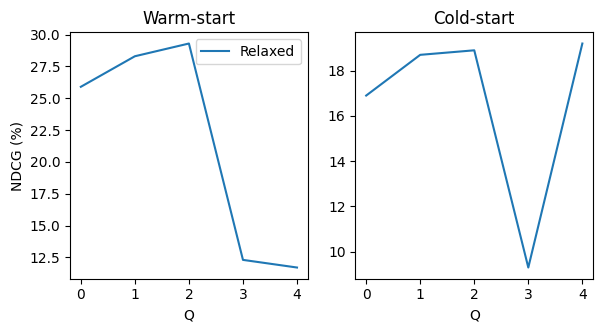

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_val_ndcg_ncacf()

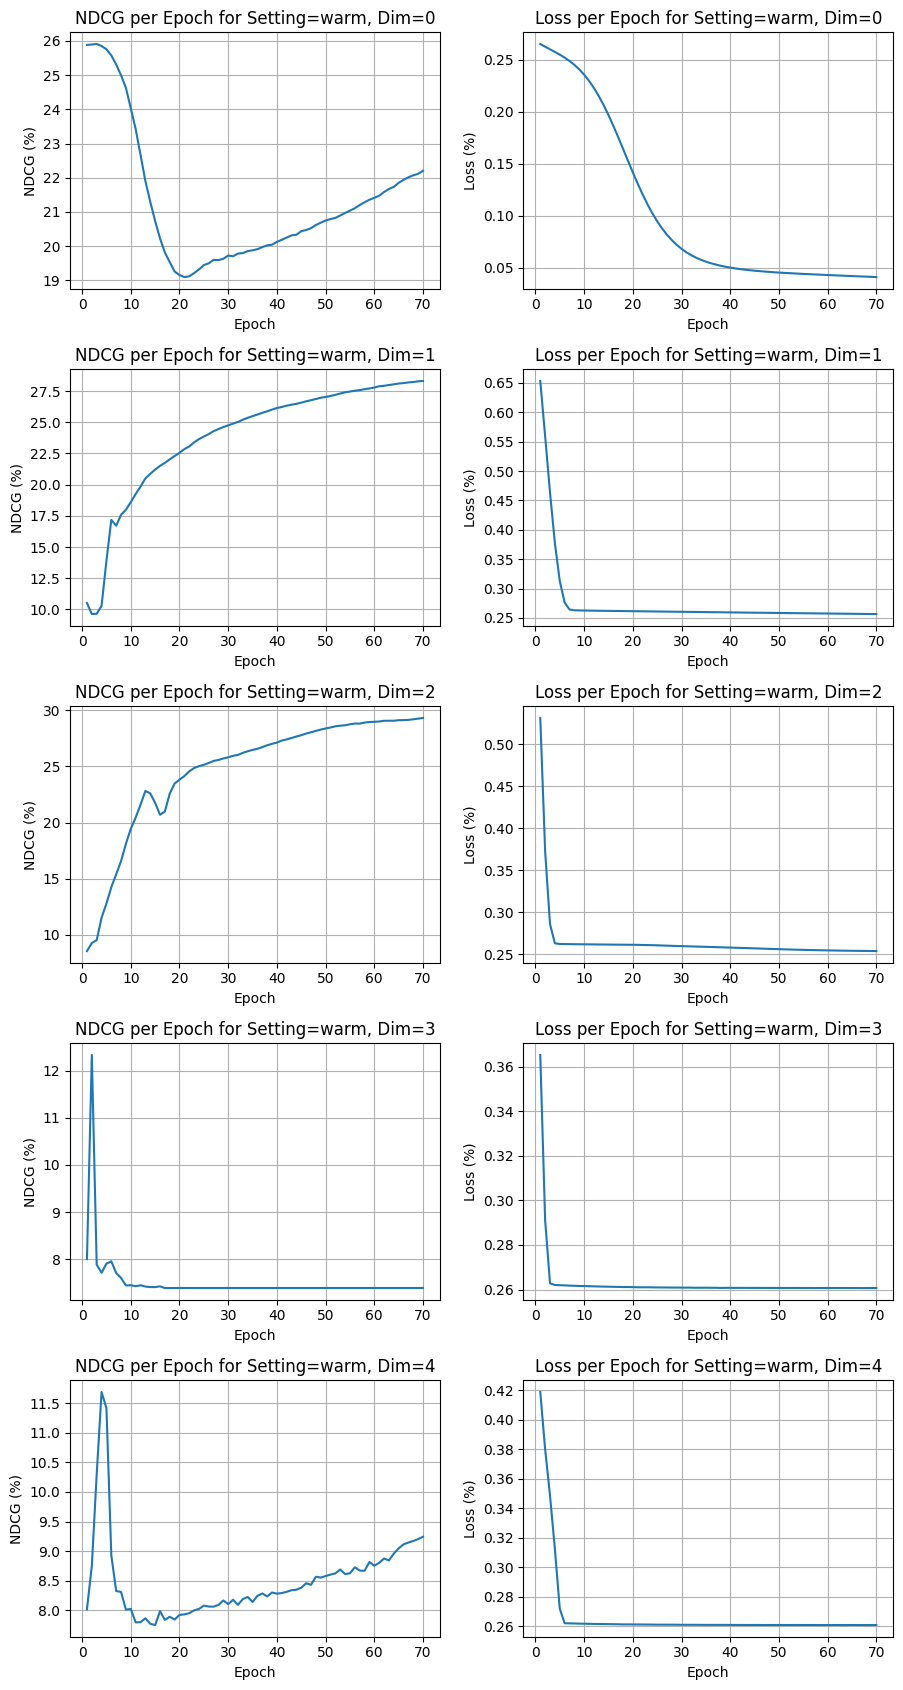

In [ ]:
plot_val_ndcg_and_loss_ncacf_all('warm')

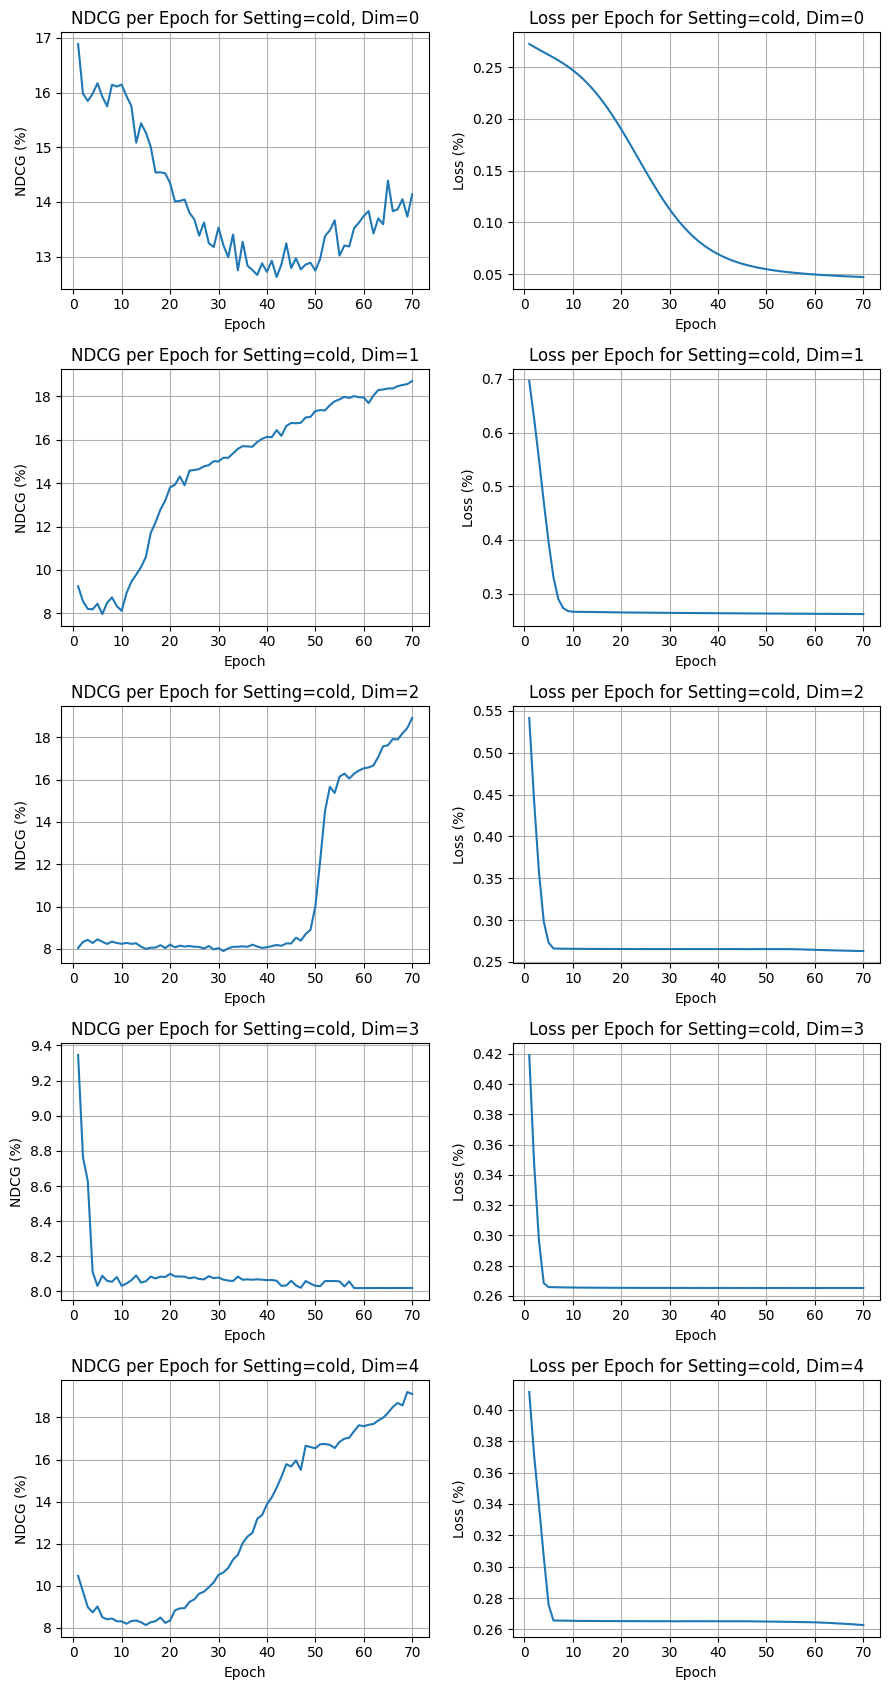

In [ ]:
plot_val_ndcg_and_loss_ncacf_all('cold')

In [ ]:
path_hyperparams = '/content/outputs/cold/ncacf/hyperparams.npz'

In [ ]:
hyper_opt = np.load(path_hyperparams)
ni_dl_opt = int(hyper_opt['nl_di'])

In [ ]:
print ('Best dimension for MLP in cold setting is ' + str(ni_dl_opt))

Best dimension for MLP in cold setting is 4


# Test



In [ ]:
def train_test_ncacf(params, setting, k_split, data_dir='data/'):

    # Define the data directory
    params['data_dir'] = data_dir + setting + '/split' + str(k_split) + '/'


    if setting == 'warm':
        params['lW'], params['lH'] = 0.1, 1
        ni_dl, inter, variant = 2, 'mult', 'relaxed'
    else:
        params['lW'], params['lH'] = 0.01, 10
        ni_dl, inter, variant = 4, 'mult', 'relaxed'

    # Train and test
    params['out_dir'] = 'outputs/temp/ncacf/split' + str(k_split) + '/'
    create_folder(params['out_dir'])
    # first pretrain a shallow NCACF model (no deep interaction layer, no nonlinear activation)
    train_ncacf(params, path_pretrain=None, n_layers_di=-1, setting=setting, variant=variant, inter=inter,
                rec_model=True)
    # and then train the complete model with the right amount of deep layers
    model_opt = train_ncacf(params, path_pretrain=params['out_dir'], n_layers_di=ni_dl, setting=setting,
                            variant=variant, inter=inter, rec_model=False)
    test_ndcg = evaluate_uni(params, model_opt, setting=setting, split='test')
    return test_ndcg

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Process on: {}'.format(device))
create_folder('outputs/temp/')

# Set parameters
params = {'batch_size': 128,
          'n_embeddings': 128,
          'lr': 1e-4,
          'n_features_hidden': 1024,
          'n_features_in': 168,
          'device': device}
data_dir = 'data/'

# Amount of splits
n_splits = 10

# Create the result file if needed
path_res = 'outputs/test_results.csv'
if not os.path.exists(path_res):
    test_results = pd.DataFrame(columns=['Setting', 'Model', 'Split', 'NDCG'])
    test_results.to_csv(path_res, index=False, header=True)

Process on: cuda


In [ ]:
model = 'ncacf'
setting_list = ['cold']
split_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
for setting in setting_list:
            for k_split in split_list:
                print('Model : ' + model + ' ------ Setting : ' + setting + ' ------ Split : ' + str(k_split))
                rec_testndcg, testndcg = True, None
                params['n_epochs'] = 70
                testndcg = train_test_ncacf(params, setting, k_split, data_dir=data_dir)
                if rec_testndcg:
                    df = pd.DataFrame({'Setting': [setting], 'Model': [model], 'Split': [k_split], 'NDCG': [testndcg]})
                    df.to_csv(path_res, mode='a', index=False, header=False)

Model : ncacf ------ Setting : cold ------ Split : 0

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.85 Songs/s]



Loss: 0.075483 | Time: 16.502 | NDCG: 0.087

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.89 Songs/s]



Loss: 0.065249 | Time: 15.051 | NDCG: 0.084

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.45 Songs/s]



Loss: 0.064133 | Time: 15.094 | NDCG: 0.084

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.38 Songs/s]



Loss: 0.063668 | Time: 15.319 | NDCG: 0.084

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.49 Songs/s]



Loss: 0.063454 | Time: 15.000 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.28 Songs/s]



Loss: 0.063333 | Time: 15.093 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.16 Songs/s]



Loss: 0.063205 | Time: 14.965 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.20 Songs/s]



Loss: 0.063119 | Time: 14.915 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.12 Songs/s]



Loss: 0.063013 | Time: 14.985 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.54 Songs/s]



Loss: 0.062815 | Time: 14.930 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.92 Songs/s]



Loss: 0.062727 | Time: 15.033 | NDCG: 0.085

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.95 Songs/s]



Loss: 0.062551 | Time: 15.068 | NDCG: 0.085

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.03 Songs/s]



Loss: 0.062287 | Time: 14.951 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.20 Songs/s]



Loss: 0.062062 | Time: 15.009 | NDCG: 0.084

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.15 Songs/s]



Loss: 0.061653 | Time: 14.991 | NDCG: 0.084

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.64 Songs/s]



Loss: 0.060968 | Time: 14.959 | NDCG: 0.084

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.30 Songs/s]



Loss: 0.060716 | Time: 14.936 | NDCG: 0.083

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.18 Songs/s]



Loss: 0.060120 | Time: 14.964 | NDCG: 0.082

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.35 Songs/s]



Loss: 0.059452 | Time: 15.147 | NDCG: 0.082

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.90 Songs/s]



Loss: 0.058693 | Time: 14.933 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.057928 | Time: 15.016 | NDCG: 0.080

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.03 Songs/s]



Loss: 0.056834 | Time: 14.938 | NDCG: 0.079

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.73 Songs/s]



Loss: 0.056344 | Time: 15.029 | NDCG: 0.079

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.02 Songs/s]



Loss: 0.055547 | Time: 15.250 | NDCG: 0.079

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.30 Songs/s]



Loss: 0.054868 | Time: 15.044 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.94 Songs/s]



Loss: 0.054354 | Time: 14.955 | NDCG: 0.079

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.55 Songs/s]



Loss: 0.053818 | Time: 14.994 | NDCG: 0.084

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.39 Songs/s]



Loss: 0.053255 | Time: 15.044 | NDCG: 0.084

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.10 Songs/s]



Loss: 0.052768 | Time: 15.373 | NDCG: 0.087

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.12 Songs/s]



Loss: 0.052316 | Time: 14.935 | NDCG: 0.099

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.49 Songs/s]



Loss: 0.051867 | Time: 14.973 | NDCG: 0.093

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.23 Songs/s]



Loss: 0.051457 | Time: 15.012 | NDCG: 0.100

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.07 Songs/s]



Loss: 0.051116 | Time: 15.005 | NDCG: 0.099

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.050743 | Time: 14.923 | NDCG: 0.104

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.16 Songs/s]



Loss: 0.050430 | Time: 14.937 | NDCG: 0.109

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.38 Songs/s]



Loss: 0.050055 | Time: 14.915 | NDCG: 0.105

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.01 Songs/s]



Loss: 0.049743 | Time: 15.031 | NDCG: 0.104

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.37 Songs/s]



Loss: 0.049416 | Time: 15.044 | NDCG: 0.114

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.12 Songs/s]



Loss: 0.049105 | Time: 15.088 | NDCG: 0.111

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.19 Songs/s]



Loss: 0.048766 | Time: 14.985 | NDCG: 0.109

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.34 Songs/s]



Loss: 0.048558 | Time: 14.890 | NDCG: 0.127

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.88 Songs/s]



Loss: 0.048240 | Time: 15.112 | NDCG: 0.132

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.52 Songs/s]



Loss: 0.047996 | Time: 14.954 | NDCG: 0.116

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.30 Songs/s]



Loss: 0.047607 | Time: 14.857 | NDCG: 0.125

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.69 Songs/s]



Loss: 0.047409 | Time: 15.072 | NDCG: 0.122

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.44 Songs/s]



Loss: 0.047170 | Time: 15.004 | NDCG: 0.131

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.92 Songs/s]



Loss: 0.046893 | Time: 15.163 | NDCG: 0.138

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.57 Songs/s]



Loss: 0.046688 | Time: 14.971 | NDCG: 0.124

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.46 Songs/s]



Loss: 0.046407 | Time: 14.972 | NDCG: 0.138

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.18 Songs/s]



Loss: 0.046134 | Time: 14.972 | NDCG: 0.133

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.33 Songs/s]



Loss: 0.045926 | Time: 14.937 | NDCG: 0.141

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.53 Songs/s]



Loss: 0.045684 | Time: 14.989 | NDCG: 0.145

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.76 Songs/s]



Loss: 0.045486 | Time: 15.011 | NDCG: 0.136

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.28 Songs/s]



Loss: 0.045202 | Time: 14.993 | NDCG: 0.146

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.86 Songs/s]



Loss: 0.044985 | Time: 15.098 | NDCG: 0.149

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.79 Songs/s]



Loss: 0.044771 | Time: 15.156 | NDCG: 0.146

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.48 Songs/s]



Loss: 0.044530 | Time: 15.034 | NDCG: 0.144

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.48 Songs/s]



Loss: 0.044270 | Time: 15.210 | NDCG: 0.140

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.16 Songs/s]



Loss: 0.044109 | Time: 15.131 | NDCG: 0.144

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.043885 | Time: 15.189 | NDCG: 0.144

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.04 Songs/s]



Loss: 0.043639 | Time: 15.179 | NDCG: 0.152

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.09 Songs/s]



Loss: 0.043386 | Time: 15.086 | NDCG: 0.148

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.88 Songs/s]



Loss: 0.043129 | Time: 15.313 | NDCG: 0.147

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.93 Songs/s]



Loss: 0.042978 | Time: 15.280 | NDCG: 0.151

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.042756 | Time: 15.311 | NDCG: 0.152

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.22 Songs/s]



Loss: 0.042487 | Time: 15.211 | NDCG: 0.154

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.042301 | Time: 15.064 | NDCG: 0.149

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.27 Songs/s]



Loss: 0.042049 | Time: 15.089 | NDCG: 0.154

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.20 Songs/s]



Loss: 0.041859 | Time: 15.003 | NDCG: 0.159

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.79 Songs/s]



Loss: 0.041594 | Time: 15.078 | NDCG: 0.161

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.74 Songs/s]



Loss: 0.411400 | Time: 24.624 | NDCG: 0.105

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.71 Songs/s]



Loss: 0.371262 | Time: 22.448 | NDCG: 0.097

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.339444 | Time: 22.444 | NDCG: 0.090

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.89 Songs/s]



Loss: 0.306346 | Time: 22.339 | NDCG: 0.087

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.275769 | Time: 22.308 | NDCG: 0.090

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.265708 | Time: 22.196 | NDCG: 0.085

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.265656 | Time: 22.204 | NDCG: 0.084

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.30 Songs/s]



Loss: 0.265606 | Time: 21.995 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.23 Songs/s]



Loss: 0.265562 | Time: 22.156 | NDCG: 0.083

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.17 Songs/s]



Loss: 0.265518 | Time: 22.252 | NDCG: 0.083

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265442 | Time: 22.240 | NDCG: 0.082

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.265449 | Time: 22.101 | NDCG: 0.083

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.11 Songs/s]



Loss: 0.265427 | Time: 22.188 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.265401 | Time: 22.137 | NDCG: 0.083

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.51 Songs/s]



Loss: 0.265375 | Time: 22.024 | NDCG: 0.081

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.85 Songs/s]



Loss: 0.265366 | Time: 22.285 | NDCG: 0.083

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.07 Songs/s]



Loss: 0.265343 | Time: 22.051 | NDCG: 0.083

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.07 Songs/s]



Loss: 0.265341 | Time: 22.055 | NDCG: 0.085

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.84 Songs/s]



Loss: 0.265325 | Time: 21.977 | NDCG: 0.082

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.17 Songs/s]



Loss: 0.265312 | Time: 22.154 | NDCG: 0.084

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.56 Songs/s]



Loss: 0.265304 | Time: 22.011 | NDCG: 0.088

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.15 Songs/s]



Loss: 0.265292 | Time: 22.404 | NDCG: 0.089

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.265292 | Time: 22.054 | NDCG: 0.089

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.20 Songs/s]



Loss: 0.265281 | Time: 22.094 | NDCG: 0.092

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.01 Songs/s]



Loss: 0.265271 | Time: 22.087 | NDCG: 0.094

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.98 Songs/s]



Loss: 0.265260 | Time: 22.184 | NDCG: 0.096

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.57 Songs/s]



Loss: 0.265259 | Time: 22.063 | NDCG: 0.097

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.265254 | Time: 21.936 | NDCG: 0.099

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.20 Songs/s]



Loss: 0.265262 | Time: 22.289 | NDCG: 0.102

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 12.01 Songs/s]



Loss: 0.265257 | Time: 21.984 | NDCG: 0.105

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.62 Songs/s]



Loss: 0.265185 | Time: 22.003 | NDCG: 0.106

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.265228 | Time: 21.937 | NDCG: 0.108

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.265245 | Time: 21.975 | NDCG: 0.112

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.18 Songs/s]



Loss: 0.265240 | Time: 21.944 | NDCG: 0.115

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265247 | Time: 22.001 | NDCG: 0.120

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.265238 | Time: 22.001 | NDCG: 0.123

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.10 Songs/s]



Loss: 0.265236 | Time: 21.932 | NDCG: 0.125

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.07 Songs/s]



Loss: 0.265228 | Time: 21.966 | NDCG: 0.132

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.42 Songs/s]



Loss: 0.265240 | Time: 22.122 | NDCG: 0.134

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.26 Songs/s]



Loss: 0.265216 | Time: 21.989 | NDCG: 0.139

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.265219 | Time: 22.072 | NDCG: 0.142

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.71 Songs/s]



Loss: 0.265226 | Time: 22.137 | NDCG: 0.147

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265206 | Time: 22.054 | NDCG: 0.152

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.265213 | Time: 21.981 | NDCG: 0.158

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265212 | Time: 22.018 | NDCG: 0.157

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.95 Songs/s]



Loss: 0.265206 | Time: 22.045 | NDCG: 0.160

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.08 Songs/s]



Loss: 0.265173 | Time: 22.021 | NDCG: 0.155

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.31 Songs/s]



Loss: 0.265121 | Time: 22.113 | NDCG: 0.167

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.94 Songs/s]



Loss: 0.265070 | Time: 21.914 | NDCG: 0.166

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.60 Songs/s]



Loss: 0.265041 | Time: 22.093 | NDCG: 0.165

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.00 Songs/s]



Loss: 0.265005 | Time: 22.037 | NDCG: 0.167

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.07 Songs/s]



Loss: 0.264971 | Time: 22.096 | NDCG: 0.167

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.11 Songs/s]



Loss: 0.264923 | Time: 22.098 | NDCG: 0.167

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.17 Songs/s]



Loss: 0.264883 | Time: 22.034 | NDCG: 0.165

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.11 Songs/s]



Loss: 0.264830 | Time: 22.144 | NDCG: 0.168

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.18 Songs/s]



Loss: 0.264782 | Time: 22.050 | NDCG: 0.170

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.18 Songs/s]



Loss: 0.264697 | Time: 21.995 | NDCG: 0.170

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.45 Songs/s]



Loss: 0.264668 | Time: 22.052 | NDCG: 0.173

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.92 Songs/s]



Loss: 0.264605 | Time: 21.990 | NDCG: 0.176

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.90 Songs/s]



Loss: 0.264532 | Time: 21.942 | NDCG: 0.176

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.92 Songs/s]



Loss: 0.264401 | Time: 22.023 | NDCG: 0.176

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.264306 | Time: 22.069 | NDCG: 0.177

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.264161 | Time: 22.020 | NDCG: 0.179

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.263989 | Time: 22.107 | NDCG: 0.180

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.04 Songs/s]



Loss: 0.263790 | Time: 22.138 | NDCG: 0.182

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.90 Songs/s]



Loss: 0.263629 | Time: 22.020 | NDCG: 0.185

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.18 Songs/s]



Loss: 0.263442 | Time: 22.039 | NDCG: 0.187

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.263264 | Time: 22.234 | NDCG: 0.186

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.61 Songs/s]



Loss: 0.263014 | Time: 22.132 | NDCG: 0.192

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.02 Songs/s]



Loss: 0.262792 | Time: 22.023 | NDCG: 0.191


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 12.63 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 1

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.23 Songs/s]



Loss: 0.073086 | Time: 14.935 | NDCG: 0.086

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.65 Songs/s]



Loss: 0.063323 | Time: 15.075 | NDCG: 0.084

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.48 Songs/s]



Loss: 0.062128 | Time: 15.061 | NDCG: 0.083

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.62 Songs/s]



Loss: 0.061763 | Time: 14.942 | NDCG: 0.083

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.21 Songs/s]



Loss: 0.061544 | Time: 14.890 | NDCG: 0.085

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.91 Songs/s]



Loss: 0.061424 | Time: 15.026 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.14 Songs/s]



Loss: 0.061312 | Time: 15.042 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.89 Songs/s]



Loss: 0.061186 | Time: 14.952 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.68 Songs/s]



Loss: 0.061099 | Time: 15.072 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.67 Songs/s]



Loss: 0.060936 | Time: 14.917 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.68 Songs/s]



Loss: 0.060822 | Time: 14.940 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.46 Songs/s]



Loss: 0.060591 | Time: 14.907 | NDCG: 0.084

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.16 Songs/s]



Loss: 0.060415 | Time: 14.866 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.88 Songs/s]



Loss: 0.060125 | Time: 14.894 | NDCG: 0.085

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.04 Songs/s]



Loss: 0.059813 | Time: 14.964 | NDCG: 0.085

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.70 Songs/s]



Loss: 0.059311 | Time: 14.965 | NDCG: 0.086

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.25 Songs/s]



Loss: 0.058886 | Time: 14.935 | NDCG: 0.086

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.65 Songs/s]



Loss: 0.058350 | Time: 14.917 | NDCG: 0.088

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.35 Songs/s]



Loss: 0.057685 | Time: 14.791 | NDCG: 0.091

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.28 Songs/s]



Loss: 0.056982 | Time: 15.019 | NDCG: 0.093

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.28 Songs/s]



Loss: 0.056233 | Time: 14.910 | NDCG: 0.094

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.18 Songs/s]



Loss: 0.055406 | Time: 14.962 | NDCG: 0.095

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.28 Songs/s]



Loss: 0.054793 | Time: 14.898 | NDCG: 0.097

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.35 Songs/s]



Loss: 0.054068 | Time: 14.861 | NDCG: 0.103

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.53 Songs/s]



Loss: 0.053467 | Time: 14.914 | NDCG: 0.089

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.17 Songs/s]



Loss: 0.052864 | Time: 15.546 | NDCG: 0.099

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.85 Songs/s]



Loss: 0.052420 | Time: 14.920 | NDCG: 0.101

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.79 Songs/s]



Loss: 0.051965 | Time: 15.003 | NDCG: 0.095

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.13 Songs/s]



Loss: 0.051562 | Time: 14.874 | NDCG: 0.096

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.63 Songs/s]



Loss: 0.051117 | Time: 14.851 | NDCG: 0.096

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.26 Songs/s]



Loss: 0.050752 | Time: 14.887 | NDCG: 0.094

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.20 Songs/s]



Loss: 0.050370 | Time: 14.847 | NDCG: 0.098

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.36 Songs/s]



Loss: 0.050099 | Time: 14.825 | NDCG: 0.099

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.12 Songs/s]



Loss: 0.049775 | Time: 14.846 | NDCG: 0.098

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.80 Songs/s]



Loss: 0.049456 | Time: 14.892 | NDCG: 0.101

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.30 Songs/s]



Loss: 0.049187 | Time: 15.145 | NDCG: 0.097

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.09 Songs/s]



Loss: 0.048896 | Time: 14.860 | NDCG: 0.098

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.22 Songs/s]



Loss: 0.048626 | Time: 14.854 | NDCG: 0.104

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.12 Songs/s]



Loss: 0.048382 | Time: 14.928 | NDCG: 0.105

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.34 Songs/s]



Loss: 0.048061 | Time: 14.840 | NDCG: 0.106

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.40 Songs/s]



Loss: 0.047824 | Time: 14.733 | NDCG: 0.109

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.98 Songs/s]



Loss: 0.047577 | Time: 14.821 | NDCG: 0.115

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.46 Songs/s]



Loss: 0.047306 | Time: 14.844 | NDCG: 0.114

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.90 Songs/s]



Loss: 0.047073 | Time: 14.882 | NDCG: 0.114

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.30 Songs/s]



Loss: 0.046856 | Time: 14.846 | NDCG: 0.105

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.69 Songs/s]



Loss: 0.046636 | Time: 14.864 | NDCG: 0.115

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.81 Songs/s]



Loss: 0.046412 | Time: 14.924 | NDCG: 0.119

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.01 Songs/s]



Loss: 0.046160 | Time: 14.762 | NDCG: 0.123

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.66 Songs/s]



Loss: 0.045924 | Time: 14.843 | NDCG: 0.129

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.70 Songs/s]



Loss: 0.045724 | Time: 14.888 | NDCG: 0.130

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.18 Songs/s]



Loss: 0.045415 | Time: 14.776 | NDCG: 0.131

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.86 Songs/s]



Loss: 0.045259 | Time: 14.838 | NDCG: 0.129

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.18 Songs/s]



Loss: 0.045023 | Time: 14.862 | NDCG: 0.131

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.31 Songs/s]



Loss: 0.044814 | Time: 14.841 | NDCG: 0.138

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.17 Songs/s]



Loss: 0.044630 | Time: 14.859 | NDCG: 0.147

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.70 Songs/s]



Loss: 0.044407 | Time: 14.788 | NDCG: 0.136

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.31 Songs/s]



Loss: 0.044188 | Time: 14.832 | NDCG: 0.138

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.78 Songs/s]



Loss: 0.043985 | Time: 14.960 | NDCG: 0.137

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.28 Songs/s]



Loss: 0.043737 | Time: 14.820 | NDCG: 0.147

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.43 Songs/s]



Loss: 0.043549 | Time: 14.814 | NDCG: 0.156

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.22 Songs/s]



Loss: 0.043323 | Time: 14.909 | NDCG: 0.150

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.23 Songs/s]



Loss: 0.043088 | Time: 14.811 | NDCG: 0.150

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.27 Songs/s]



Loss: 0.042876 | Time: 14.882 | NDCG: 0.152

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.15 Songs/s]



Loss: 0.042659 | Time: 14.894 | NDCG: 0.152

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.12 Songs/s]



Loss: 0.042440 | Time: 14.935 | NDCG: 0.157

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.67 Songs/s]



Loss: 0.042193 | Time: 14.780 | NDCG: 0.149

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.65 Songs/s]



Loss: 0.042026 | Time: 14.847 | NDCG: 0.159

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.09 Songs/s]



Loss: 0.041796 | Time: 14.840 | NDCG: 0.160

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.02 Songs/s]



Loss: 0.041603 | Time: 14.851 | NDCG: 0.162

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.20 Songs/s]



Loss: 0.041362 | Time: 14.835 | NDCG: 0.162

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.88 Songs/s]



Loss: 0.411091 | Time: 24.146 | NDCG: 0.090

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.31 Songs/s]



Loss: 0.370949 | Time: 22.010 | NDCG: 0.082

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.81 Songs/s]



Loss: 0.339409 | Time: 22.027 | NDCG: 0.083

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.306714 | Time: 22.770 | NDCG: 0.081

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.34 Songs/s]



Loss: 0.276115 | Time: 22.332 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.32 Songs/s]



Loss: 0.265242 | Time: 21.938 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.57 Songs/s]



Loss: 0.265165 | Time: 21.819 | NDCG: 0.081

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.44 Songs/s]



Loss: 0.265121 | Time: 21.931 | NDCG: 0.083

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.265077 | Time: 22.109 | NDCG: 0.081

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.35 Songs/s]



Loss: 0.265022 | Time: 22.101 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.264998 | Time: 22.009 | NDCG: 0.080

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.48 Songs/s]



Loss: 0.264952 | Time: 21.844 | NDCG: 0.080

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.30 Songs/s]



Loss: 0.264954 | Time: 21.906 | NDCG: 0.080

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.28 Songs/s]



Loss: 0.264932 | Time: 21.836 | NDCG: 0.080

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.264907 | Time: 21.803 | NDCG: 0.080

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.264878 | Time: 21.863 | NDCG: 0.080

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.264876 | Time: 21.989 | NDCG: 0.080

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.264863 | Time: 22.142 | NDCG: 0.080

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.44 Songs/s]



Loss: 0.264858 | Time: 21.878 | NDCG: 0.080

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.264848 | Time: 21.924 | NDCG: 0.080

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.56 Songs/s]



Loss: 0.264833 | Time: 21.928 | NDCG: 0.080

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.75 Songs/s]



Loss: 0.264830 | Time: 21.875 | NDCG: 0.080

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.264783 | Time: 21.823 | NDCG: 0.080

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.264814 | Time: 21.956 | NDCG: 0.080

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.14 Songs/s]



Loss: 0.264791 | Time: 22.033 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.264801 | Time: 22.098 | NDCG: 0.080

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.264792 | Time: 21.861 | NDCG: 0.080

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.264795 | Time: 21.896 | NDCG: 0.080

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.264782 | Time: 21.785 | NDCG: 0.080

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.264790 | Time: 21.759 | NDCG: 0.080

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.24 Songs/s]



Loss: 0.264779 | Time: 21.832 | NDCG: 0.080

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.19 Songs/s]



Loss: 0.264776 | Time: 21.741 | NDCG: 0.080

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.25 Songs/s]



Loss: 0.264781 | Time: 22.164 | NDCG: 0.080

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.22 Songs/s]



Loss: 0.264772 | Time: 21.862 | NDCG: 0.080

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.21 Songs/s]



Loss: 0.264766 | Time: 21.756 | NDCG: 0.080

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.264756 | Time: 21.840 | NDCG: 0.080

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.18 Songs/s]



Loss: 0.264752 | Time: 21.876 | NDCG: 0.080

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.41 Songs/s]



Loss: 0.264763 | Time: 21.837 | NDCG: 0.080

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.264768 | Time: 21.829 | NDCG: 0.080

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.264758 | Time: 21.887 | NDCG: 0.080

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.264769 | Time: 21.923 | NDCG: 0.080

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.23 Songs/s]



Loss: 0.264755 | Time: 21.853 | NDCG: 0.080

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.77 Songs/s]



Loss: 0.264762 | Time: 21.889 | NDCG: 0.080

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.81 Songs/s]



Loss: 0.264759 | Time: 21.944 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.264749 | Time: 21.869 | NDCG: 0.080

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.22 Songs/s]



Loss: 0.264762 | Time: 21.836 | NDCG: 0.080

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.37 Songs/s]



Loss: 0.264758 | Time: 21.845 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.264685 | Time: 22.194 | NDCG: 0.080

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.35 Songs/s]



Loss: 0.264747 | Time: 21.757 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.50 Songs/s]



Loss: 0.264754 | Time: 21.854 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.00 Songs/s]



Loss: 0.264751 | Time: 21.775 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.264740 | Time: 21.910 | NDCG: 0.080

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.264756 | Time: 21.871 | NDCG: 0.080

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.32 Songs/s]



Loss: 0.264736 | Time: 21.958 | NDCG: 0.080

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.22 Songs/s]



Loss: 0.264708 | Time: 22.036 | NDCG: 0.080

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.38 Songs/s]



Loss: 0.264750 | Time: 21.923 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.264748 | Time: 21.902 | NDCG: 0.080

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.32 Songs/s]



Loss: 0.264743 | Time: 21.930 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.264737 | Time: 21.843 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.12 Songs/s]



Loss: 0.264738 | Time: 21.955 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.264691 | Time: 21.972 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.17 Songs/s]



Loss: 0.264709 | Time: 21.850 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.10 Songs/s]



Loss: 0.264739 | Time: 22.323 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.49 Songs/s]



Loss: 0.264735 | Time: 21.929 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.264740 | Time: 21.876 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.264747 | Time: 21.858 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.23 Songs/s]



Loss: 0.264739 | Time: 21.983 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.30 Songs/s]



Loss: 0.264731 | Time: 21.908 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.09 Songs/s]



Loss: 0.264720 | Time: 21.896 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.64 Songs/s]



Loss: 0.264740 | Time: 22.059 | NDCG: 0.080


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 12.30 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 2

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.76 Songs/s]



Loss: 0.074826 | Time: 15.175 | NDCG: 0.085

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.71 Songs/s]



Loss: 0.065217 | Time: 15.094 | NDCG: 0.083

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.35 Songs/s]



Loss: 0.064133 | Time: 15.143 | NDCG: 0.082

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.87 Songs/s]



Loss: 0.063775 | Time: 15.133 | NDCG: 0.084

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.70 Songs/s]



Loss: 0.063581 | Time: 15.068 | NDCG: 0.083

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.81 Songs/s]



Loss: 0.063442 | Time: 15.161 | NDCG: 0.083

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.88 Songs/s]



Loss: 0.063294 | Time: 15.146 | NDCG: 0.083

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.58 Songs/s]



Loss: 0.063214 | Time: 15.144 | NDCG: 0.083

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.68 Songs/s]



Loss: 0.063087 | Time: 15.194 | NDCG: 0.084

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.80 Songs/s]



Loss: 0.062956 | Time: 15.105 | NDCG: 0.084

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.42 Songs/s]



Loss: 0.062802 | Time: 15.297 | NDCG: 0.083

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.62 Songs/s]



Loss: 0.062603 | Time: 15.196 | NDCG: 0.084

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.59 Songs/s]



Loss: 0.062299 | Time: 15.185 | NDCG: 0.084

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.58 Songs/s]



Loss: 0.061868 | Time: 15.192 | NDCG: 0.083

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.54 Songs/s]



Loss: 0.061560 | Time: 15.170 | NDCG: 0.082

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.22 Songs/s]



Loss: 0.061150 | Time: 15.142 | NDCG: 0.082

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.72 Songs/s]



Loss: 0.060594 | Time: 15.173 | NDCG: 0.082

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.62 Songs/s]



Loss: 0.059960 | Time: 15.172 | NDCG: 0.083

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.41 Songs/s]



Loss: 0.059237 | Time: 15.275 | NDCG: 0.083

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.65 Songs/s]



Loss: 0.058466 | Time: 15.023 | NDCG: 0.084

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.37 Songs/s]



Loss: 0.057633 | Time: 14.965 | NDCG: 0.084

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.43 Songs/s]



Loss: 0.056851 | Time: 15.583 | NDCG: 0.086

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.42 Songs/s]



Loss: 0.056097 | Time: 15.142 | NDCG: 0.087

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.17 Songs/s]



Loss: 0.055185 | Time: 15.133 | NDCG: 0.094

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.12 Songs/s]



Loss: 0.054705 | Time: 15.046 | NDCG: 0.095

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.41 Songs/s]



Loss: 0.054047 | Time: 15.134 | NDCG: 0.099

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.47 Songs/s]



Loss: 0.053597 | Time: 15.286 | NDCG: 0.103

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.05 Songs/s]



Loss: 0.053013 | Time: 15.119 | NDCG: 0.103

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.93 Songs/s]



Loss: 0.052641 | Time: 15.133 | NDCG: 0.105

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.31 Songs/s]



Loss: 0.052215 | Time: 15.173 | NDCG: 0.106

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.37 Songs/s]



Loss: 0.051816 | Time: 15.115 | NDCG: 0.092

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.72 Songs/s]



Loss: 0.051400 | Time: 15.460 | NDCG: 0.091

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.50 Songs/s]



Loss: 0.051095 | Time: 15.092 | NDCG: 0.097

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.19 Songs/s]



Loss: 0.050687 | Time: 15.201 | NDCG: 0.094

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.40 Songs/s]



Loss: 0.050380 | Time: 15.167 | NDCG: 0.101

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.38 Songs/s]



Loss: 0.050135 | Time: 15.028 | NDCG: 0.095

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.11 Songs/s]



Loss: 0.049872 | Time: 15.265 | NDCG: 0.098

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.23 Songs/s]



Loss: 0.049611 | Time: 15.254 | NDCG: 0.094

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.34 Songs/s]



Loss: 0.049220 | Time: 15.097 | NDCG: 0.098

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.00 Songs/s]



Loss: 0.049078 | Time: 15.091 | NDCG: 0.096

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.45 Songs/s]



Loss: 0.048830 | Time: 15.130 | NDCG: 0.100

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.23 Songs/s]



Loss: 0.048509 | Time: 15.139 | NDCG: 0.090

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.65 Songs/s]



Loss: 0.048329 | Time: 15.317 | NDCG: 0.104

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.31 Songs/s]



Loss: 0.048096 | Time: 15.020 | NDCG: 0.101

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.33 Songs/s]



Loss: 0.047824 | Time: 15.123 | NDCG: 0.100

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.14 Songs/s]



Loss: 0.047615 | Time: 15.276 | NDCG: 0.102

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.28 Songs/s]



Loss: 0.047388 | Time: 15.172 | NDCG: 0.101

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.07 Songs/s]



Loss: 0.047192 | Time: 15.060 | NDCG: 0.117

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.19 Songs/s]



Loss: 0.046993 | Time: 15.246 | NDCG: 0.100

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.34 Songs/s]



Loss: 0.046719 | Time: 15.100 | NDCG: 0.105

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.26 Songs/s]



Loss: 0.046486 | Time: 15.152 | NDCG: 0.110

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.56 Songs/s]



Loss: 0.046288 | Time: 15.002 | NDCG: 0.118

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.34 Songs/s]



Loss: 0.046069 | Time: 15.036 | NDCG: 0.113

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.045818 | Time: 15.479 | NDCG: 0.112

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.33 Songs/s]



Loss: 0.045654 | Time: 15.268 | NDCG: 0.113

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.32 Songs/s]



Loss: 0.045406 | Time: 15.104 | NDCG: 0.122

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.32 Songs/s]



Loss: 0.045193 | Time: 15.206 | NDCG: 0.125

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.31 Songs/s]



Loss: 0.044980 | Time: 15.093 | NDCG: 0.126

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.42 Songs/s]



Loss: 0.044751 | Time: 15.096 | NDCG: 0.125

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.57 Songs/s]



Loss: 0.044518 | Time: 15.021 | NDCG: 0.131

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.40 Songs/s]



Loss: 0.044274 | Time: 15.085 | NDCG: 0.132

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.08 Songs/s]



Loss: 0.044078 | Time: 15.076 | NDCG: 0.128

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.25 Songs/s]



Loss: 0.043836 | Time: 15.138 | NDCG: 0.136

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.49 Songs/s]



Loss: 0.043610 | Time: 15.023 | NDCG: 0.134

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.03 Songs/s]



Loss: 0.043375 | Time: 15.621 | NDCG: 0.134

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.46 Songs/s]



Loss: 0.043188 | Time: 15.099 | NDCG: 0.140

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.33 Songs/s]



Loss: 0.042963 | Time: 15.108 | NDCG: 0.136

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.042697 | Time: 15.081 | NDCG: 0.142

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.042484 | Time: 15.032 | NDCG: 0.144

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.042267 | Time: 15.153 | NDCG: 0.143

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.59 Songs/s]



Loss: 0.411319 | Time: 24.437 | NDCG: 0.098

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.29 Songs/s]



Loss: 0.371302 | Time: 22.273 | NDCG: 0.097

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.339989 | Time: 22.129 | NDCG: 0.101

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.84 Songs/s]



Loss: 0.307504 | Time: 22.219 | NDCG: 0.090

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.82 Songs/s]



Loss: 0.276889 | Time: 22.016 | NDCG: 0.098

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.41 Songs/s]



Loss: 0.265737 | Time: 21.921 | NDCG: 0.089

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.66 Songs/s]



Loss: 0.265641 | Time: 21.940 | NDCG: 0.090

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265612 | Time: 21.865 | NDCG: 0.092

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.78 Songs/s]



Loss: 0.265569 | Time: 21.869 | NDCG: 0.092

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.74 Songs/s]



Loss: 0.265492 | Time: 21.892 | NDCG: 0.084

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.89 Songs/s]



Loss: 0.265483 | Time: 21.884 | NDCG: 0.090

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.265464 | Time: 22.363 | NDCG: 0.091

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265438 | Time: 22.190 | NDCG: 0.088

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.75 Songs/s]



Loss: 0.265386 | Time: 22.068 | NDCG: 0.086

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265383 | Time: 22.062 | NDCG: 0.084

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.74 Songs/s]



Loss: 0.265369 | Time: 22.176 | NDCG: 0.087

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.63 Songs/s]



Loss: 0.265364 | Time: 22.126 | NDCG: 0.083

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.56 Songs/s]



Loss: 0.265350 | Time: 22.125 | NDCG: 0.089

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.69 Songs/s]



Loss: 0.265335 | Time: 22.034 | NDCG: 0.083

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.73 Songs/s]



Loss: 0.265332 | Time: 22.443 | NDCG: 0.088

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.65 Songs/s]



Loss: 0.265306 | Time: 22.163 | NDCG: 0.085

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.74 Songs/s]



Loss: 0.265287 | Time: 22.008 | NDCG: 0.086

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.59 Songs/s]



Loss: 0.265296 | Time: 22.198 | NDCG: 0.085

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.265298 | Time: 22.079 | NDCG: 0.083

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.265285 | Time: 22.029 | NDCG: 0.082

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.45 Songs/s]



Loss: 0.265281 | Time: 22.108 | NDCG: 0.082

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.96 Songs/s]



Loss: 0.265281 | Time: 21.989 | NDCG: 0.082

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.57 Songs/s]



Loss: 0.265276 | Time: 22.007 | NDCG: 0.080

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.265281 | Time: 22.052 | NDCG: 0.082

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.52 Songs/s]



Loss: 0.265264 | Time: 22.037 | NDCG: 0.081

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.61 Songs/s]



Loss: 0.265252 | Time: 21.906 | NDCG: 0.081

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.83 Songs/s]



Loss: 0.265250 | Time: 22.076 | NDCG: 0.080

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.15 Songs/s]



Loss: 0.265253 | Time: 22.179 | NDCG: 0.081

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.85 Songs/s]



Loss: 0.265253 | Time: 21.999 | NDCG: 0.082

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.62 Songs/s]



Loss: 0.265249 | Time: 22.056 | NDCG: 0.081

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.66 Songs/s]



Loss: 0.265257 | Time: 22.487 | NDCG: 0.081

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.80 Songs/s]



Loss: 0.265249 | Time: 22.028 | NDCG: 0.082

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.62 Songs/s]



Loss: 0.265251 | Time: 21.984 | NDCG: 0.081

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.76 Songs/s]



Loss: 0.265236 | Time: 22.119 | NDCG: 0.080

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.84 Songs/s]



Loss: 0.265219 | Time: 22.041 | NDCG: 0.080

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.66 Songs/s]



Loss: 0.265249 | Time: 21.921 | NDCG: 0.081

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.04 Songs/s]



Loss: 0.265200 | Time: 22.137 | NDCG: 0.080

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.69 Songs/s]



Loss: 0.265251 | Time: 22.069 | NDCG: 0.080

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.72 Songs/s]



Loss: 0.265245 | Time: 22.198 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.10 Songs/s]



Loss: 0.265252 | Time: 22.126 | NDCG: 0.080

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.74 Songs/s]



Loss: 0.265242 | Time: 21.992 | NDCG: 0.081

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.63 Songs/s]



Loss: 0.265182 | Time: 22.056 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.51 Songs/s]



Loss: 0.265237 | Time: 21.972 | NDCG: 0.081

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.60 Songs/s]



Loss: 0.265225 | Time: 22.060 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.07 Songs/s]



Loss: 0.265240 | Time: 22.009 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.39 Songs/s]



Loss: 0.265229 | Time: 21.943 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.73 Songs/s]



Loss: 0.265227 | Time: 22.321 | NDCG: 0.080

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.82 Songs/s]



Loss: 0.265240 | Time: 22.101 | NDCG: 0.080

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.13 Songs/s]



Loss: 0.265235 | Time: 21.964 | NDCG: 0.080

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.265229 | Time: 22.101 | NDCG: 0.080

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265222 | Time: 22.081 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265233 | Time: 22.155 | NDCG: 0.080

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.76 Songs/s]



Loss: 0.265225 | Time: 22.138 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.68 Songs/s]



Loss: 0.265225 | Time: 22.112 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.69 Songs/s]



Loss: 0.265227 | Time: 22.109 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.77 Songs/s]



Loss: 0.265228 | Time: 22.004 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.64 Songs/s]



Loss: 0.265224 | Time: 22.063 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265165 | Time: 22.092 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.61 Songs/s]



Loss: 0.265224 | Time: 22.133 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.65 Songs/s]



Loss: 0.265216 | Time: 22.127 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.70 Songs/s]



Loss: 0.265227 | Time: 22.085 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.66 Songs/s]



Loss: 0.265204 | Time: 22.003 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.72 Songs/s]



Loss: 0.265220 | Time: 22.156 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.265224 | Time: 22.039 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.62 Songs/s]



Loss: 0.265219 | Time: 22.017 | NDCG: 0.080


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 12.40 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 3

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.81 Songs/s]



Loss: 0.074999 | Time: 15.021 | NDCG: 0.087

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.32 Songs/s]



Loss: 0.064851 | Time: 15.193 | NDCG: 0.084

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.72 Songs/s]



Loss: 0.063671 | Time: 15.176 | NDCG: 0.084

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.81 Songs/s]



Loss: 0.063256 | Time: 15.045 | NDCG: 0.085

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.28 Songs/s]



Loss: 0.063035 | Time: 15.104 | NDCG: 0.085

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.73 Songs/s]



Loss: 0.062869 | Time: 15.072 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.78 Songs/s]



Loss: 0.062724 | Time: 15.141 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.75 Songs/s]



Loss: 0.062674 | Time: 15.553 | NDCG: 0.086

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.65 Songs/s]



Loss: 0.062526 | Time: 15.088 | NDCG: 0.086

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.40 Songs/s]



Loss: 0.062377 | Time: 15.100 | NDCG: 0.087

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.78 Songs/s]



Loss: 0.062227 | Time: 15.043 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.72 Songs/s]



Loss: 0.062055 | Time: 15.165 | NDCG: 0.085

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.44 Songs/s]



Loss: 0.061840 | Time: 15.129 | NDCG: 0.086

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.93 Songs/s]



Loss: 0.061521 | Time: 15.064 | NDCG: 0.085

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.79 Songs/s]



Loss: 0.061238 | Time: 15.032 | NDCG: 0.086

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.76 Songs/s]



Loss: 0.060728 | Time: 15.243 | NDCG: 0.085

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.65 Songs/s]



Loss: 0.060299 | Time: 15.072 | NDCG: 0.085

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.74 Songs/s]



Loss: 0.059669 | Time: 14.890 | NDCG: 0.084

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.93 Songs/s]



Loss: 0.058911 | Time: 15.032 | NDCG: 0.083

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.87 Songs/s]



Loss: 0.058284 | Time: 15.025 | NDCG: 0.082

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.30 Songs/s]



Loss: 0.057425 | Time: 15.220 | NDCG: 0.083

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.85 Songs/s]



Loss: 0.056752 | Time: 15.012 | NDCG: 0.086

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.58 Songs/s]



Loss: 0.055999 | Time: 15.120 | NDCG: 0.089

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.81 Songs/s]



Loss: 0.055241 | Time: 15.231 | NDCG: 0.089

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.70 Songs/s]



Loss: 0.054549 | Time: 15.203 | NDCG: 0.091

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.56 Songs/s]



Loss: 0.053982 | Time: 15.117 | NDCG: 0.093

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.68 Songs/s]



Loss: 0.053456 | Time: 15.400 | NDCG: 0.091

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.92 Songs/s]



Loss: 0.052904 | Time: 15.286 | NDCG: 0.095

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.26 Songs/s]



Loss: 0.052411 | Time: 15.482 | NDCG: 0.097

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.64 Songs/s]



Loss: 0.051980 | Time: 15.530 | NDCG: 0.099

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.96 Songs/s]



Loss: 0.051569 | Time: 15.487 | NDCG: 0.098

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.38 Songs/s]



Loss: 0.051173 | Time: 15.445 | NDCG: 0.096

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.47 Songs/s]



Loss: 0.050740 | Time: 15.406 | NDCG: 0.094

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.63 Songs/s]



Loss: 0.050411 | Time: 15.086 | NDCG: 0.090

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.64 Songs/s]



Loss: 0.050088 | Time: 15.043 | NDCG: 0.089

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.22 Songs/s]



Loss: 0.049677 | Time: 15.145 | NDCG: 0.099

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.82 Songs/s]



Loss: 0.049392 | Time: 15.119 | NDCG: 0.092

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.88 Songs/s]



Loss: 0.049137 | Time: 15.143 | NDCG: 0.095

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.39 Songs/s]



Loss: 0.048825 | Time: 15.100 | NDCG: 0.097

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.52 Songs/s]



Loss: 0.048494 | Time: 15.072 | NDCG: 0.100

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.18 Songs/s]



Loss: 0.048272 | Time: 15.114 | NDCG: 0.104

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.76 Songs/s]



Loss: 0.047972 | Time: 15.228 | NDCG: 0.101

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.90 Songs/s]



Loss: 0.047686 | Time: 15.059 | NDCG: 0.102

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.18 Songs/s]



Loss: 0.047462 | Time: 15.034 | NDCG: 0.105

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.89 Songs/s]



Loss: 0.047109 | Time: 15.186 | NDCG: 0.108

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.51 Songs/s]



Loss: 0.046897 | Time: 15.135 | NDCG: 0.112

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.64 Songs/s]



Loss: 0.046631 | Time: 15.297 | NDCG: 0.110

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.77 Songs/s]



Loss: 0.046435 | Time: 15.133 | NDCG: 0.119

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.51 Songs/s]



Loss: 0.046188 | Time: 15.251 | NDCG: 0.116

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.67 Songs/s]



Loss: 0.045935 | Time: 15.114 | NDCG: 0.126

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.88 Songs/s]



Loss: 0.045688 | Time: 15.033 | NDCG: 0.117

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.15 Songs/s]



Loss: 0.045461 | Time: 15.051 | NDCG: 0.120

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.71 Songs/s]



Loss: 0.045242 | Time: 15.450 | NDCG: 0.124

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.51 Songs/s]



Loss: 0.045013 | Time: 15.511 | NDCG: 0.128

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.85 Songs/s]



Loss: 0.044765 | Time: 15.712 | NDCG: 0.128

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.80 Songs/s]



Loss: 0.044545 | Time: 15.931 | NDCG: 0.127

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.56 Songs/s]



Loss: 0.044331 | Time: 15.403 | NDCG: 0.135

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.67 Songs/s]



Loss: 0.044093 | Time: 15.234 | NDCG: 0.132

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.70 Songs/s]



Loss: 0.043871 | Time: 15.196 | NDCG: 0.143

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.75 Songs/s]



Loss: 0.043662 | Time: 15.482 | NDCG: 0.136

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.73 Songs/s]



Loss: 0.043428 | Time: 15.128 | NDCG: 0.138

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.17 Songs/s]



Loss: 0.043169 | Time: 15.425 | NDCG: 0.137

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.08 Songs/s]



Loss: 0.042982 | Time: 15.300 | NDCG: 0.140

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.76 Songs/s]



Loss: 0.042775 | Time: 15.340 | NDCG: 0.146

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.59 Songs/s]



Loss: 0.042501 | Time: 15.796 | NDCG: 0.143

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.40 Songs/s]



Loss: 0.042311 | Time: 15.325 | NDCG: 0.145

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.26 Songs/s]



Loss: 0.042059 | Time: 15.726 | NDCG: 0.146

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.69 Songs/s]



Loss: 0.041858 | Time: 15.419 | NDCG: 0.155

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.76 Songs/s]



Loss: 0.041591 | Time: 15.248 | NDCG: 0.150

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.78 Songs/s]



Loss: 0.041446 | Time: 15.307 | NDCG: 0.152

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.63 Songs/s]



Loss: 0.411301 | Time: 24.490 | NDCG: 0.092

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.371152 | Time: 22.432 | NDCG: 0.090

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.61 Songs/s]



Loss: 0.339549 | Time: 22.449 | NDCG: 0.097

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.57 Songs/s]



Loss: 0.306771 | Time: 22.621 | NDCG: 0.092

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.61 Songs/s]



Loss: 0.276276 | Time: 22.439 | NDCG: 0.092

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.265608 | Time: 22.351 | NDCG: 0.083

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.65 Songs/s]



Loss: 0.265545 | Time: 22.467 | NDCG: 0.086

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.53 Songs/s]



Loss: 0.265493 | Time: 22.251 | NDCG: 0.081

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.94 Songs/s]



Loss: 0.265456 | Time: 22.332 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.265414 | Time: 22.381 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.67 Songs/s]



Loss: 0.265373 | Time: 22.271 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.12 Songs/s]



Loss: 0.265316 | Time: 22.580 | NDCG: 0.083

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.95 Songs/s]



Loss: 0.265315 | Time: 22.233 | NDCG: 0.082

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.50 Songs/s]



Loss: 0.265290 | Time: 22.250 | NDCG: 0.082

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.265266 | Time: 22.149 | NDCG: 0.084

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.35 Songs/s]



Loss: 0.265257 | Time: 22.143 | NDCG: 0.082

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.42 Songs/s]



Loss: 0.265242 | Time: 22.308 | NDCG: 0.081

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.265217 | Time: 22.217 | NDCG: 0.081

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265213 | Time: 22.231 | NDCG: 0.081

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.51 Songs/s]



Loss: 0.265203 | Time: 22.364 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265112 | Time: 22.235 | NDCG: 0.082

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.265184 | Time: 22.072 | NDCG: 0.081

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.265163 | Time: 22.330 | NDCG: 0.081

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.265154 | Time: 22.398 | NDCG: 0.081

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.84 Songs/s]



Loss: 0.265146 | Time: 22.143 | NDCG: 0.081

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.265148 | Time: 22.382 | NDCG: 0.080

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.265138 | Time: 22.431 | NDCG: 0.081

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265147 | Time: 22.449 | NDCG: 0.081

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.265137 | Time: 22.343 | NDCG: 0.081

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265144 | Time: 22.365 | NDCG: 0.081

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.56 Songs/s]



Loss: 0.265132 | Time: 22.431 | NDCG: 0.081

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.44 Songs/s]



Loss: 0.265119 | Time: 22.327 | NDCG: 0.081

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.06 Songs/s]



Loss: 0.265132 | Time: 22.290 | NDCG: 0.081

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.63 Songs/s]



Loss: 0.265130 | Time: 22.337 | NDCG: 0.081

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.265135 | Time: 22.241 | NDCG: 0.081

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.88 Songs/s]



Loss: 0.265115 | Time: 22.542 | NDCG: 0.081

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265119 | Time: 22.311 | NDCG: 0.081

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.265120 | Time: 22.241 | NDCG: 0.080

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.88 Songs/s]



Loss: 0.265117 | Time: 22.357 | NDCG: 0.081

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.52 Songs/s]



Loss: 0.265102 | Time: 22.337 | NDCG: 0.080

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.58 Songs/s]



Loss: 0.265116 | Time: 22.361 | NDCG: 0.081

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.04 Songs/s]



Loss: 0.265116 | Time: 22.333 | NDCG: 0.080

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.265096 | Time: 22.115 | NDCG: 0.081

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265111 | Time: 22.509 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.91 Songs/s]



Loss: 0.265110 | Time: 22.272 | NDCG: 0.080

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.265107 | Time: 22.212 | NDCG: 0.080

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.265091 | Time: 22.247 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.265086 | Time: 22.347 | NDCG: 0.080

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.37 Songs/s]



Loss: 0.265101 | Time: 22.341 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.30 Songs/s]



Loss: 0.265103 | Time: 22.207 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.265092 | Time: 22.151 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.50 Songs/s]



Loss: 0.265082 | Time: 22.561 | NDCG: 0.080

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.265083 | Time: 22.153 | NDCG: 0.080

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.265099 | Time: 22.100 | NDCG: 0.080

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265100 | Time: 22.287 | NDCG: 0.080

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.47 Songs/s]



Loss: 0.265088 | Time: 22.309 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.89 Songs/s]



Loss: 0.265088 | Time: 22.147 | NDCG: 0.080

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.41 Songs/s]



Loss: 0.265094 | Time: 22.214 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.42 Songs/s]



Loss: 0.265089 | Time: 22.295 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265094 | Time: 22.401 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.49 Songs/s]



Loss: 0.265050 | Time: 22.228 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.68 Songs/s]



Loss: 0.265089 | Time: 22.320 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.265080 | Time: 22.296 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265083 | Time: 22.212 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.265078 | Time: 22.287 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.97 Songs/s]



Loss: 0.265087 | Time: 22.293 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.54 Songs/s]



Loss: 0.265087 | Time: 22.261 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.265082 | Time: 22.426 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.03 Songs/s]



Loss: 0.265084 | Time: 22.283 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265079 | Time: 22.205 | NDCG: 0.080


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.15 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 4

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.07 Songs/s]



Loss: 0.074731 | Time: 15.146 | NDCG: 0.085

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.84 Songs/s]



Loss: 0.064756 | Time: 15.478 | NDCG: 0.083

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.50 Songs/s]



Loss: 0.063746 | Time: 15.466 | NDCG: 0.082

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.42 Songs/s]



Loss: 0.063289 | Time: 15.386 | NDCG: 0.083

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.27 Songs/s]



Loss: 0.063035 | Time: 15.273 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.24 Songs/s]



Loss: 0.062925 | Time: 15.384 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.30 Songs/s]



Loss: 0.062825 | Time: 15.289 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.61 Songs/s]



Loss: 0.062679 | Time: 15.473 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.21 Songs/s]



Loss: 0.062377 | Time: 15.468 | NDCG: 0.086

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.50 Songs/s]



Loss: 0.062439 | Time: 15.320 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.40 Songs/s]



Loss: 0.062286 | Time: 15.380 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.46 Songs/s]



Loss: 0.061855 | Time: 15.284 | NDCG: 0.084

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.23 Songs/s]



Loss: 0.061848 | Time: 15.234 | NDCG: 0.085

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.44 Songs/s]



Loss: 0.061459 | Time: 15.515 | NDCG: 0.085

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.16 Songs/s]



Loss: 0.061107 | Time: 15.375 | NDCG: 0.084

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.40 Songs/s]



Loss: 0.060364 | Time: 15.525 | NDCG: 0.084

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.90 Songs/s]



Loss: 0.060020 | Time: 15.221 | NDCG: 0.085

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.41 Songs/s]



Loss: 0.059350 | Time: 15.356 | NDCG: 0.085

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.52 Songs/s]



Loss: 0.058617 | Time: 15.810 | NDCG: 0.085

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.61 Songs/s]



Loss: 0.057849 | Time: 15.409 | NDCG: 0.087

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.85 Songs/s]



Loss: 0.057057 | Time: 15.282 | NDCG: 0.089

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.30 Songs/s]



Loss: 0.056273 | Time: 15.169 | NDCG: 0.091

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.39 Songs/s]



Loss: 0.055544 | Time: 15.328 | NDCG: 0.085

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.96 Songs/s]



Loss: 0.054820 | Time: 15.428 | NDCG: 0.088

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.46 Songs/s]



Loss: 0.054111 | Time: 15.353 | NDCG: 0.094

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.82 Songs/s]



Loss: 0.053685 | Time: 15.461 | NDCG: 0.091

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.10 Songs/s]



Loss: 0.053125 | Time: 15.359 | NDCG: 0.102

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.74 Songs/s]



Loss: 0.052691 | Time: 15.327 | NDCG: 0.103

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.19 Songs/s]



Loss: 0.052264 | Time: 15.418 | NDCG: 0.099

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.72 Songs/s]



Loss: 0.051838 | Time: 15.310 | NDCG: 0.099

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.42 Songs/s]



Loss: 0.051368 | Time: 15.369 | NDCG: 0.102

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.67 Songs/s]



Loss: 0.051108 | Time: 15.275 | NDCG: 0.102

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.06 Songs/s]



Loss: 0.050737 | Time: 15.426 | NDCG: 0.105

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.07 Songs/s]



Loss: 0.050468 | Time: 15.409 | NDCG: 0.107

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.27 Songs/s]



Loss: 0.050136 | Time: 15.297 | NDCG: 0.097

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.81 Songs/s]



Loss: 0.049893 | Time: 15.360 | NDCG: 0.108

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.80 Songs/s]



Loss: 0.049577 | Time: 15.307 | NDCG: 0.107

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.55 Songs/s]



Loss: 0.049253 | Time: 15.365 | NDCG: 0.114

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.32 Songs/s]



Loss: 0.049026 | Time: 15.449 | NDCG: 0.107

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.08 Songs/s]



Loss: 0.048797 | Time: 15.309 | NDCG: 0.111

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.048491 | Time: 15.570 | NDCG: 0.102

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.00 Songs/s]



Loss: 0.048313 | Time: 15.434 | NDCG: 0.127

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.35 Songs/s]



Loss: 0.048059 | Time: 15.434 | NDCG: 0.112

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.047846 | Time: 15.453 | NDCG: 0.131

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.43 Songs/s]



Loss: 0.047575 | Time: 15.319 | NDCG: 0.114

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.97 Songs/s]



Loss: 0.047353 | Time: 15.252 | NDCG: 0.125

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.45 Songs/s]



Loss: 0.047145 | Time: 15.359 | NDCG: 0.126

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.39 Songs/s]



Loss: 0.046897 | Time: 15.265 | NDCG: 0.123

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.27 Songs/s]



Loss: 0.046682 | Time: 15.257 | NDCG: 0.127

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.29 Songs/s]



Loss: 0.046378 | Time: 15.281 | NDCG: 0.125

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.69 Songs/s]



Loss: 0.046240 | Time: 15.262 | NDCG: 0.131

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.52 Songs/s]



Loss: 0.046011 | Time: 15.304 | NDCG: 0.135

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.18 Songs/s]



Loss: 0.045783 | Time: 15.418 | NDCG: 0.128

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.02 Songs/s]



Loss: 0.045571 | Time: 15.219 | NDCG: 0.137

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.61 Songs/s]



Loss: 0.045351 | Time: 15.298 | NDCG: 0.135

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.57 Songs/s]



Loss: 0.045138 | Time: 15.290 | NDCG: 0.141

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.11 Songs/s]



Loss: 0.044886 | Time: 15.330 | NDCG: 0.138

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.71 Songs/s]



Loss: 0.044700 | Time: 15.304 | NDCG: 0.143

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 17.11 Songs/s]



Loss: 0.044492 | Time: 15.153 | NDCG: 0.143

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.89 Songs/s]



Loss: 0.044260 | Time: 15.345 | NDCG: 0.141

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.74 Songs/s]



Loss: 0.044010 | Time: 15.263 | NDCG: 0.142

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.55 Songs/s]



Loss: 0.043788 | Time: 15.273 | NDCG: 0.145

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 16.42 Songs/s]



Loss: 0.043567 | Time: 15.228 | NDCG: 0.145

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.35 Songs/s]



Loss: 0.043388 | Time: 15.366 | NDCG: 0.148

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.84 Songs/s]



Loss: 0.043177 | Time: 15.354 | NDCG: 0.153

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.24 Songs/s]



Loss: 0.042954 | Time: 15.192 | NDCG: 0.146

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.05 Songs/s]



Loss: 0.042690 | Time: 15.348 | NDCG: 0.159

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.042511 | Time: 15.260 | NDCG: 0.148

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.24 Songs/s]



Loss: 0.042294 | Time: 15.303 | NDCG: 0.153

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.93 Songs/s]



Loss: 0.042077 | Time: 15.384 | NDCG: 0.154

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.34 Songs/s]



Loss: 0.411230 | Time: 24.406 | NDCG: 0.106

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.36 Songs/s]



Loss: 0.371083 | Time: 22.112 | NDCG: 0.095

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.05 Songs/s]



Loss: 0.339485 | Time: 22.235 | NDCG: 0.086

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.26 Songs/s]



Loss: 0.306696 | Time: 22.596 | NDCG: 0.086

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.276255 | Time: 22.139 | NDCG: 0.092

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.265604 | Time: 22.134 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.265542 | Time: 22.163 | NDCG: 0.083

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 11.27 Songs/s]



Loss: 0.265477 | Time: 22.245 | NDCG: 0.082

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265435 | Time: 22.149 | NDCG: 0.082

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265388 | Time: 22.256 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.265366 | Time: 22.313 | NDCG: 0.082

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265305 | Time: 22.534 | NDCG: 0.082

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265314 | Time: 22.225 | NDCG: 0.082

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265275 | Time: 22.187 | NDCG: 0.081

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265262 | Time: 22.166 | NDCG: 0.081

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.07 Songs/s]



Loss: 0.265248 | Time: 22.386 | NDCG: 0.081

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.72 Songs/s]



Loss: 0.265232 | Time: 22.304 | NDCG: 0.081

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265227 | Time: 22.225 | NDCG: 0.081

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.63 Songs/s]



Loss: 0.265195 | Time: 22.295 | NDCG: 0.081

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.67 Songs/s]



Loss: 0.265211 | Time: 22.383 | NDCG: 0.080

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265167 | Time: 22.200 | NDCG: 0.081

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.69 Songs/s]



Loss: 0.265179 | Time: 22.177 | NDCG: 0.081

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.04 Songs/s]



Loss: 0.265187 | Time: 22.275 | NDCG: 0.080

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.92 Songs/s]



Loss: 0.265159 | Time: 22.176 | NDCG: 0.081

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.98 Songs/s]



Loss: 0.265171 | Time: 22.238 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265137 | Time: 22.195 | NDCG: 0.081

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.06 Songs/s]



Loss: 0.265151 | Time: 22.333 | NDCG: 0.080

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265150 | Time: 22.700 | NDCG: 0.080

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265160 | Time: 22.329 | NDCG: 0.080

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265137 | Time: 22.397 | NDCG: 0.080

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.69 Songs/s]



Loss: 0.265146 | Time: 22.512 | NDCG: 0.080

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.61 Songs/s]



Loss: 0.265141 | Time: 22.518 | NDCG: 0.080

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.81 Songs/s]



Loss: 0.265086 | Time: 22.549 | NDCG: 0.080

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.77 Songs/s]



Loss: 0.265123 | Time: 22.476 | NDCG: 0.080

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.67 Songs/s]



Loss: 0.265136 | Time: 22.416 | NDCG: 0.080

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265139 | Time: 22.569 | NDCG: 0.080

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.65 Songs/s]



Loss: 0.265100 | Time: 22.513 | NDCG: 0.080

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.52 Songs/s]



Loss: 0.265132 | Time: 22.587 | NDCG: 0.080

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.70 Songs/s]



Loss: 0.265102 | Time: 22.583 | NDCG: 0.080

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.63 Songs/s]



Loss: 0.265123 | Time: 22.651 | NDCG: 0.080

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.64 Songs/s]



Loss: 0.265130 | Time: 22.603 | NDCG: 0.080

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.83 Songs/s]



Loss: 0.265116 | Time: 22.484 | NDCG: 0.080

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.89 Songs/s]



Loss: 0.265118 | Time: 22.468 | NDCG: 0.080

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265121 | Time: 22.592 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.17 Songs/s]



Loss: 0.265128 | Time: 22.571 | NDCG: 0.080

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.12 Songs/s]



Loss: 0.265131 | Time: 22.534 | NDCG: 0.080

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.11 Songs/s]



Loss: 0.265116 | Time: 22.485 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.70 Songs/s]



Loss: 0.265112 | Time: 22.607 | NDCG: 0.080

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.60 Songs/s]



Loss: 0.265110 | Time: 22.582 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.68 Songs/s]



Loss: 0.265111 | Time: 22.593 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.86 Songs/s]



Loss: 0.265112 | Time: 22.645 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.69 Songs/s]



Loss: 0.265106 | Time: 22.784 | NDCG: 0.080

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265059 | Time: 22.699 | NDCG: 0.080

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.88 Songs/s]



Loss: 0.265109 | Time: 22.684 | NDCG: 0.080

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.64 Songs/s]



Loss: 0.265109 | Time: 22.622 | NDCG: 0.080

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.78 Songs/s]



Loss: 0.265082 | Time: 22.590 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.17 Songs/s]



Loss: 0.265089 | Time: 22.646 | NDCG: 0.080

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.03 Songs/s]



Loss: 0.265117 | Time: 22.658 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265112 | Time: 22.621 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.72 Songs/s]



Loss: 0.265108 | Time: 22.831 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.85 Songs/s]



Loss: 0.265114 | Time: 22.550 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.60 Songs/s]



Loss: 0.265108 | Time: 22.641 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.61 Songs/s]



Loss: 0.265099 | Time: 22.668 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.60 Songs/s]



Loss: 0.265100 | Time: 22.687 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.63 Songs/s]



Loss: 0.265096 | Time: 22.778 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.80 Songs/s]



Loss: 0.265107 | Time: 22.680 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.66 Songs/s]



Loss: 0.265096 | Time: 22.734 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265096 | Time: 22.838 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.71 Songs/s]



Loss: 0.265087 | Time: 22.717 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.68 Songs/s]



Loss: 0.265084 | Time: 22.667 | NDCG: 0.080


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 10.74 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 5

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.63 Songs/s]



Loss: 0.074687 | Time: 15.697 | NDCG: 0.085

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.064718 | Time: 15.746 | NDCG: 0.082

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.063612 | Time: 15.979 | NDCG: 0.081

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.063173 | Time: 15.758 | NDCG: 0.082

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.062912 | Time: 15.891 | NDCG: 0.082

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.81 Songs/s]



Loss: 0.062798 | Time: 15.799 | NDCG: 0.082

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.062714 | Time: 15.851 | NDCG: 0.083

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.062587 | Time: 16.015 | NDCG: 0.084

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.062502 | Time: 15.847 | NDCG: 0.083

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.062313 | Time: 15.965 | NDCG: 0.083

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.50 Songs/s]



Loss: 0.062149 | Time: 16.026 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.63 Songs/s]



Loss: 0.062043 | Time: 16.078 | NDCG: 0.083

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.061803 | Time: 15.824 | NDCG: 0.083

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.061506 | Time: 15.988 | NDCG: 0.083

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.061047 | Time: 15.845 | NDCG: 0.083

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.060690 | Time: 15.826 | NDCG: 0.082

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.060142 | Time: 15.755 | NDCG: 0.082

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.61 Songs/s]



Loss: 0.059491 | Time: 15.650 | NDCG: 0.082

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.058820 | Time: 16.041 | NDCG: 0.081

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.058072 | Time: 15.883 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.057287 | Time: 16.019 | NDCG: 0.081

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.056481 | Time: 15.851 | NDCG: 0.088

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.055736 | Time: 15.997 | NDCG: 0.091

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.054964 | Time: 15.807 | NDCG: 0.091

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.054354 | Time: 15.717 | NDCG: 0.090

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.053819 | Time: 15.851 | NDCG: 0.086

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.053094 | Time: 15.825 | NDCG: 0.102

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.052719 | Time: 15.807 | NDCG: 0.106

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.052325 | Time: 15.776 | NDCG: 0.104

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.051849 | Time: 16.074 | NDCG: 0.110

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.66 Songs/s]



Loss: 0.051466 | Time: 15.725 | NDCG: 0.112

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.16 Songs/s]



Loss: 0.051109 | Time: 15.868 | NDCG: 0.118

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.050749 | Time: 15.763 | NDCG: 0.112

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.25 Songs/s]



Loss: 0.050434 | Time: 15.749 | NDCG: 0.115

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.050099 | Time: 15.696 | NDCG: 0.114

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.049778 | Time: 15.768 | NDCG: 0.114

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.049519 | Time: 15.889 | NDCG: 0.102

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.049225 | Time: 15.717 | NDCG: 0.106

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.048949 | Time: 15.984 | NDCG: 0.106

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.95 Songs/s]



Loss: 0.048677 | Time: 15.817 | NDCG: 0.114

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.048420 | Time: 16.059 | NDCG: 0.105

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.50 Songs/s]



Loss: 0.048131 | Time: 15.721 | NDCG: 0.102

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.047884 | Time: 15.770 | NDCG: 0.101

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.047645 | Time: 15.773 | NDCG: 0.096

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.66 Songs/s]



Loss: 0.047357 | Time: 15.697 | NDCG: 0.105

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.047195 | Time: 15.888 | NDCG: 0.098

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.046951 | Time: 15.709 | NDCG: 0.102

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.19 Songs/s]



Loss: 0.046679 | Time: 15.839 | NDCG: 0.105

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.046491 | Time: 15.651 | NDCG: 0.116

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.046251 | Time: 15.709 | NDCG: 0.110

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.046058 | Time: 15.719 | NDCG: 0.118

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.045806 | Time: 15.750 | NDCG: 0.116

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.55 Songs/s]



Loss: 0.045620 | Time: 16.233 | NDCG: 0.117

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.64 Songs/s]



Loss: 0.045406 | Time: 15.720 | NDCG: 0.125

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.045168 | Time: 15.822 | NDCG: 0.117

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.64 Songs/s]



Loss: 0.044945 | Time: 15.694 | NDCG: 0.121

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.044740 | Time: 15.645 | NDCG: 0.134

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.044483 | Time: 15.671 | NDCG: 0.121

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.044302 | Time: 15.671 | NDCG: 0.130

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.71 Songs/s]



Loss: 0.044063 | Time: 15.807 | NDCG: 0.130

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.45 Songs/s]



Loss: 0.043866 | Time: 15.725 | NDCG: 0.130

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.043686 | Time: 15.894 | NDCG: 0.134

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.043467 | Time: 15.844 | NDCG: 0.141

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.043209 | Time: 16.099 | NDCG: 0.138

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.64 Songs/s]



Loss: 0.043007 | Time: 15.833 | NDCG: 0.141

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.042807 | Time: 15.758 | NDCG: 0.145

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.042599 | Time: 15.709 | NDCG: 0.150

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.042333 | Time: 15.747 | NDCG: 0.150

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.042142 | Time: 15.719 | NDCG: 0.145

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.041876 | Time: 15.719 | NDCG: 0.149

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.11 Songs/s]



Loss: 0.411199 | Time: 24.770 | NDCG: 0.077

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.10 Songs/s]



Loss: 0.371033 | Time: 22.536 | NDCG: 0.076

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.12 Songs/s]



Loss: 0.339406 | Time: 22.547 | NDCG: 0.073

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.306599 | Time: 22.536 | NDCG: 0.073

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.01 Songs/s]



Loss: 0.276157 | Time: 22.422 | NDCG: 0.077

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.03 Songs/s]



Loss: 0.265569 | Time: 22.546 | NDCG: 0.078

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.05 Songs/s]



Loss: 0.265488 | Time: 22.423 | NDCG: 0.080

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.04 Songs/s]



Loss: 0.265440 | Time: 22.365 | NDCG: 0.080

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.09 Songs/s]



Loss: 0.265414 | Time: 22.448 | NDCG: 0.080

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.10 Songs/s]



Loss: 0.265374 | Time: 22.629 | NDCG: 0.080

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.265338 | Time: 22.461 | NDCG: 0.080

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.09 Songs/s]



Loss: 0.265264 | Time: 22.661 | NDCG: 0.080

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.11 Songs/s]



Loss: 0.265286 | Time: 22.675 | NDCG: 0.079

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.265257 | Time: 22.561 | NDCG: 0.080

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.07 Songs/s]



Loss: 0.265241 | Time: 22.571 | NDCG: 0.079

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.12 Songs/s]



Loss: 0.265226 | Time: 22.475 | NDCG: 0.081

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.265217 | Time: 22.530 | NDCG: 0.080

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.13 Songs/s]



Loss: 0.265198 | Time: 22.554 | NDCG: 0.080

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.14 Songs/s]



Loss: 0.265181 | Time: 22.503 | NDCG: 0.080

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.15 Songs/s]



Loss: 0.265179 | Time: 22.844 | NDCG: 0.080

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265157 | Time: 22.508 | NDCG: 0.080

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.19 Songs/s]



Loss: 0.265148 | Time: 22.577 | NDCG: 0.080

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265153 | Time: 22.542 | NDCG: 0.080

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.21 Songs/s]



Loss: 0.265109 | Time: 22.434 | NDCG: 0.080

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265097 | Time: 22.475 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265138 | Time: 22.467 | NDCG: 0.080

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265129 | Time: 22.551 | NDCG: 0.080

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265114 | Time: 22.745 | NDCG: 0.080

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.265114 | Time: 22.551 | NDCG: 0.080

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265103 | Time: 22.589 | NDCG: 0.080

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.265117 | Time: 22.525 | NDCG: 0.080

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265113 | Time: 22.472 | NDCG: 0.080

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.22 Songs/s]



Loss: 0.265122 | Time: 22.614 | NDCG: 0.080

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265116 | Time: 22.606 | NDCG: 0.080

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.23 Songs/s]



Loss: 0.265110 | Time: 22.601 | NDCG: 0.080

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265108 | Time: 22.506 | NDCG: 0.080

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.28 Songs/s]



Loss: 0.265099 | Time: 22.781 | NDCG: 0.080

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265100 | Time: 22.609 | NDCG: 0.080

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265102 | Time: 22.604 | NDCG: 0.080

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.26 Songs/s]



Loss: 0.265089 | Time: 22.665 | NDCG: 0.080

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.32 Songs/s]



Loss: 0.265087 | Time: 22.689 | NDCG: 0.080

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265080 | Time: 22.623 | NDCG: 0.080

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.21 Songs/s]



Loss: 0.265075 | Time: 22.664 | NDCG: 0.080

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265103 | Time: 22.608 | NDCG: 0.080

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265096 | Time: 22.697 | NDCG: 0.080

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.17 Songs/s]



Loss: 0.265076 | Time: 22.606 | NDCG: 0.080

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.17 Songs/s]



Loss: 0.265068 | Time: 22.600 | NDCG: 0.080

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.265059 | Time: 22.603 | NDCG: 0.080

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265022 | Time: 22.607 | NDCG: 0.080

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265084 | Time: 22.624 | NDCG: 0.080

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.34 Songs/s]



Loss: 0.265082 | Time: 22.588 | NDCG: 0.080

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265088 | Time: 22.565 | NDCG: 0.080

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265091 | Time: 22.660 | NDCG: 0.080

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265072 | Time: 22.587 | NDCG: 0.080

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265081 | Time: 22.522 | NDCG: 0.080

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265081 | Time: 22.546 | NDCG: 0.080

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.30 Songs/s]



Loss: 0.265066 | Time: 22.592 | NDCG: 0.080

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.265085 | Time: 22.525 | NDCG: 0.080

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265073 | Time: 22.492 | NDCG: 0.080

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.18 Songs/s]



Loss: 0.265082 | Time: 22.523 | NDCG: 0.080

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265076 | Time: 22.606 | NDCG: 0.080

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.22 Songs/s]



Loss: 0.265084 | Time: 23.007 | NDCG: 0.080

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.28 Songs/s]



Loss: 0.265080 | Time: 22.677 | NDCG: 0.080

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.28 Songs/s]



Loss: 0.265080 | Time: 22.546 | NDCG: 0.080

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.26 Songs/s]



Loss: 0.265068 | Time: 22.521 | NDCG: 0.080

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265074 | Time: 22.534 | NDCG: 0.080

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265081 | Time: 22.479 | NDCG: 0.080

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265072 | Time: 22.490 | NDCG: 0.080

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265062 | Time: 22.539 | NDCG: 0.080

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.265072 | Time: 22.597 | NDCG: 0.080


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.06 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 6

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.076545 | Time: 15.540 | NDCG: 0.086

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.065370 | Time: 15.862 | NDCG: 0.086

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.45 Songs/s]



Loss: 0.064125 | Time: 15.757 | NDCG: 0.088

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.58 Songs/s]



Loss: 0.063515 | Time: 15.898 | NDCG: 0.086

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.063226 | Time: 15.742 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.58 Songs/s]



Loss: 0.063132 | Time: 15.794 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.062952 | Time: 15.769 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.88 Songs/s]



Loss: 0.062917 | Time: 15.822 | NDCG: 0.086

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.062776 | Time: 15.756 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.37 Songs/s]



Loss: 0.062661 | Time: 15.771 | NDCG: 0.086

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.61 Songs/s]



Loss: 0.062126 | Time: 15.765 | NDCG: 0.087

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.062333 | Time: 15.814 | NDCG: 0.087

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.061982 | Time: 15.866 | NDCG: 0.087

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.061769 | Time: 15.769 | NDCG: 0.087

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.11 Songs/s]



Loss: 0.061269 | Time: 15.971 | NDCG: 0.087

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.060951 | Time: 15.791 | NDCG: 0.087

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.21 Songs/s]



Loss: 0.060412 | Time: 15.943 | NDCG: 0.087

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.37 Songs/s]



Loss: 0.059744 | Time: 15.953 | NDCG: 0.087

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.20 Songs/s]



Loss: 0.059055 | Time: 15.964 | NDCG: 0.087

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.48 Songs/s]



Loss: 0.058296 | Time: 16.000 | NDCG: 0.088

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.057470 | Time: 15.935 | NDCG: 0.090

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.056800 | Time: 16.026 | NDCG: 0.093

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.055970 | Time: 16.073 | NDCG: 0.097

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.25 Songs/s]



Loss: 0.055286 | Time: 16.087 | NDCG: 0.100

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.054596 | Time: 15.855 | NDCG: 0.085

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.92 Songs/s]



Loss: 0.053961 | Time: 16.021 | NDCG: 0.103

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.48 Songs/s]



Loss: 0.053495 | Time: 15.808 | NDCG: 0.107

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.24 Songs/s]



Loss: 0.052915 | Time: 15.940 | NDCG: 0.105

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.58 Songs/s]



Loss: 0.052499 | Time: 15.903 | NDCG: 0.105

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.052045 | Time: 15.808 | NDCG: 0.101

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.051567 | Time: 15.940 | NDCG: 0.082

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.051190 | Time: 15.734 | NDCG: 0.104

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.050767 | Time: 15.898 | NDCG: 0.098

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.050497 | Time: 15.785 | NDCG: 0.086

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.00 Songs/s]



Loss: 0.050172 | Time: 16.105 | NDCG: 0.105

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.049837 | Time: 15.983 | NDCG: 0.092

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.03 Songs/s]



Loss: 0.049491 | Time: 15.941 | NDCG: 0.083

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.049230 | Time: 15.801 | NDCG: 0.100

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.048849 | Time: 15.826 | NDCG: 0.088

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.048605 | Time: 15.769 | NDCG: 0.092

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.048273 | Time: 15.811 | NDCG: 0.097

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.37 Songs/s]



Loss: 0.048096 | Time: 15.838 | NDCG: 0.085

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.047753 | Time: 15.741 | NDCG: 0.091

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.25 Songs/s]



Loss: 0.047566 | Time: 15.702 | NDCG: 0.105

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.047336 | Time: 15.731 | NDCG: 0.096

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.047084 | Time: 15.700 | NDCG: 0.095

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.046819 | Time: 15.855 | NDCG: 0.102

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.71 Songs/s]



Loss: 0.046615 | Time: 15.756 | NDCG: 0.093

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.046363 | Time: 15.789 | NDCG: 0.097

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.046138 | Time: 15.677 | NDCG: 0.106

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.07 Songs/s]



Loss: 0.045855 | Time: 15.867 | NDCG: 0.106

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.045710 | Time: 15.715 | NDCG: 0.113

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.045514 | Time: 15.708 | NDCG: 0.112

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.045239 | Time: 15.829 | NDCG: 0.107

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.045077 | Time: 15.705 | NDCG: 0.111

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.66 Songs/s]



Loss: 0.044867 | Time: 15.811 | NDCG: 0.126

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.61 Songs/s]



Loss: 0.044643 | Time: 15.727 | NDCG: 0.117

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.24 Songs/s]



Loss: 0.044425 | Time: 15.981 | NDCG: 0.124

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.044201 | Time: 15.951 | NDCG: 0.120

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.89 Songs/s]



Loss: 0.043899 | Time: 15.872 | NDCG: 0.124

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.043736 | Time: 15.755 | NDCG: 0.125

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.043527 | Time: 15.881 | NDCG: 0.125

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.53 Songs/s]



Loss: 0.043322 | Time: 15.874 | NDCG: 0.127

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.043128 | Time: 15.887 | NDCG: 0.136

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.36 Songs/s]



Loss: 0.042865 | Time: 16.049 | NDCG: 0.131

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.042699 | Time: 15.870 | NDCG: 0.137

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.18 Songs/s]



Loss: 0.042480 | Time: 15.925 | NDCG: 0.132

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.042275 | Time: 15.902 | NDCG: 0.132

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.02 Songs/s]



Loss: 0.042037 | Time: 15.881 | NDCG: 0.133

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.041782 | Time: 15.885 | NDCG: 0.133

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.530258 | Time: 24.954 | NDCG: 0.076

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.40 Songs/s]



Loss: 0.484364 | Time: 22.628 | NDCG: 0.079

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.435938 | Time: 22.742 | NDCG: 0.082

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.34 Songs/s]



Loss: 0.384683 | Time: 22.765 | NDCG: 0.079

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.340310 | Time: 22.706 | NDCG: 0.083

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.319268 | Time: 22.683 | NDCG: 0.082

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.51 Songs/s]



Loss: 0.306677 | Time: 22.758 | NDCG: 0.081

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.294787 | Time: 22.646 | NDCG: 0.080

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.282371 | Time: 22.839 | NDCG: 0.080

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.273968 | Time: 22.605 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.266284 | Time: 22.622 | NDCG: 0.090

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.265394 | Time: 22.579 | NDCG: 0.086

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.265361 | Time: 22.700 | NDCG: 0.089

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.265313 | Time: 22.590 | NDCG: 0.101

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.265316 | Time: 22.559 | NDCG: 0.114

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.265291 | Time: 22.648 | NDCG: 0.119

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265260 | Time: 22.609 | NDCG: 0.123

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.265144 | Time: 22.654 | NDCG: 0.118

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.265242 | Time: 22.638 | NDCG: 0.130

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.265228 | Time: 22.586 | NDCG: 0.130

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.265181 | Time: 22.631 | NDCG: 0.128

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.265211 | Time: 22.668 | NDCG: 0.133

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.265172 | Time: 22.636 | NDCG: 0.132

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265194 | Time: 22.696 | NDCG: 0.135

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.265194 | Time: 22.755 | NDCG: 0.136

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.265176 | Time: 22.619 | NDCG: 0.138

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.265173 | Time: 23.121 | NDCG: 0.136

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265160 | Time: 22.631 | NDCG: 0.141

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265135 | Time: 22.508 | NDCG: 0.144

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.265112 | Time: 22.616 | NDCG: 0.142

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265118 | Time: 22.848 | NDCG: 0.140

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.40 Songs/s]



Loss: 0.265103 | Time: 22.804 | NDCG: 0.145

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.265096 | Time: 22.835 | NDCG: 0.147

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.265086 | Time: 22.731 | NDCG: 0.142

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265064 | Time: 22.775 | NDCG: 0.150

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265017 | Time: 22.723 | NDCG: 0.145

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.63 Songs/s]



Loss: 0.265015 | Time: 22.739 | NDCG: 0.147

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.264995 | Time: 22.702 | NDCG: 0.150

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.264963 | Time: 22.631 | NDCG: 0.148

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.264920 | Time: 22.589 | NDCG: 0.143

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.54 Songs/s]



Loss: 0.264874 | Time: 22.642 | NDCG: 0.150

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.264829 | Time: 22.624 | NDCG: 0.147

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.264760 | Time: 22.781 | NDCG: 0.154

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.264617 | Time: 23.018 | NDCG: 0.150

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.264606 | Time: 22.737 | NDCG: 0.148

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.264504 | Time: 22.706 | NDCG: 0.150

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.264417 | Time: 22.680 | NDCG: 0.153

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.40 Songs/s]



Loss: 0.264295 | Time: 22.765 | NDCG: 0.157

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.63 Songs/s]



Loss: 0.264161 | Time: 22.731 | NDCG: 0.155

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.63 Songs/s]



Loss: 0.264009 | Time: 22.750 | NDCG: 0.158

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.263904 | Time: 22.682 | NDCG: 0.156

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.263773 | Time: 22.686 | NDCG: 0.160

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.263632 | Time: 22.794 | NDCG: 0.162

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.263546 | Time: 22.625 | NDCG: 0.162

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.263447 | Time: 22.703 | NDCG: 0.166

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.263355 | Time: 22.685 | NDCG: 0.169

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.263248 | Time: 22.811 | NDCG: 0.168

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.263162 | Time: 22.837 | NDCG: 0.173

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.263072 | Time: 22.781 | NDCG: 0.174

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.262993 | Time: 22.812 | NDCG: 0.175

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.262886 | Time: 22.866 | NDCG: 0.181

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.262781 | Time: 23.023 | NDCG: 0.181

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.262709 | Time: 22.660 | NDCG: 0.184

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.262619 | Time: 22.679 | NDCG: 0.183

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.262539 | Time: 22.786 | NDCG: 0.187

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.262450 | Time: 22.697 | NDCG: 0.187

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.262351 | Time: 22.634 | NDCG: 0.188

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.262262 | Time: 22.699 | NDCG: 0.189

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.51 Songs/s]



Loss: 0.262192 | Time: 22.660 | NDCG: 0.188

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.262109 | Time: 22.763 | NDCG: 0.190


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.11 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 7

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.076703 | Time: 16.101 | NDCG: 0.086

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.18 Songs/s]



Loss: 0.065962 | Time: 15.999 | NDCG: 0.086

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.064700 | Time: 15.916 | NDCG: 0.087

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.064139 | Time: 15.889 | NDCG: 0.086

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.55 Songs/s]



Loss: 0.064016 | Time: 15.842 | NDCG: 0.085

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.063812 | Time: 15.756 | NDCG: 0.085

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.98 Songs/s]



Loss: 0.063662 | Time: 15.558 | NDCG: 0.084

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.79 Songs/s]



Loss: 0.063365 | Time: 15.862 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.063479 | Time: 15.863 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.063337 | Time: 15.906 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.86 Songs/s]



Loss: 0.063176 | Time: 15.875 | NDCG: 0.085

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.062960 | Time: 15.772 | NDCG: 0.085

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.062635 | Time: 15.776 | NDCG: 0.085

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.062428 | Time: 15.874 | NDCG: 0.086

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.90 Songs/s]



Loss: 0.062012 | Time: 15.931 | NDCG: 0.086

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.061502 | Time: 15.778 | NDCG: 0.085

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.060856 | Time: 15.950 | NDCG: 0.085

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.060313 | Time: 15.782 | NDCG: 0.085

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.23 Songs/s]



Loss: 0.059543 | Time: 15.904 | NDCG: 0.085

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.83 Songs/s]



Loss: 0.058777 | Time: 15.809 | NDCG: 0.084

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.55 Songs/s]



Loss: 0.057953 | Time: 15.988 | NDCG: 0.090

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.057182 | Time: 15.821 | NDCG: 0.084

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.63 Songs/s]



Loss: 0.056435 | Time: 15.805 | NDCG: 0.085

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.055690 | Time: 15.883 | NDCG: 0.092

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.91 Songs/s]



Loss: 0.055004 | Time: 15.791 | NDCG: 0.092

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.59 Songs/s]



Loss: 0.054387 | Time: 15.916 | NDCG: 0.098

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.053648 | Time: 15.934 | NDCG: 0.096

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.053369 | Time: 15.989 | NDCG: 0.101

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.96 Songs/s]



Loss: 0.052889 | Time: 15.773 | NDCG: 0.089

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.052425 | Time: 15.809 | NDCG: 0.099

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.71 Songs/s]



Loss: 0.051955 | Time: 15.834 | NDCG: 0.097

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.02 Songs/s]



Loss: 0.051647 | Time: 15.793 | NDCG: 0.104

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.051256 | Time: 15.993 | NDCG: 0.094

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.73 Songs/s]



Loss: 0.050945 | Time: 15.804 | NDCG: 0.106

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.050596 | Time: 15.907 | NDCG: 0.091

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.050280 | Time: 15.781 | NDCG: 0.102

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.049922 | Time: 15.876 | NDCG: 0.088

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.049674 | Time: 15.815 | NDCG: 0.087

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.049373 | Time: 15.958 | NDCG: 0.083

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.94 Songs/s]



Loss: 0.049067 | Time: 15.855 | NDCG: 0.089

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.048790 | Time: 15.792 | NDCG: 0.095

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.048526 | Time: 15.922 | NDCG: 0.093

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.048308 | Time: 15.803 | NDCG: 0.088

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.48 Songs/s]



Loss: 0.048038 | Time: 15.898 | NDCG: 0.095

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.047815 | Time: 15.904 | NDCG: 0.095

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.047557 | Time: 15.928 | NDCG: 0.100

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.93 Songs/s]



Loss: 0.047258 | Time: 15.859 | NDCG: 0.097

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.047092 | Time: 15.861 | NDCG: 0.103

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.046841 | Time: 16.066 | NDCG: 0.110

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.046589 | Time: 15.860 | NDCG: 0.107

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.046338 | Time: 15.862 | NDCG: 0.110

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.92 Songs/s]



Loss: 0.046120 | Time: 15.963 | NDCG: 0.120

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.18 Songs/s]



Loss: 0.045914 | Time: 15.900 | NDCG: 0.113

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.045698 | Time: 15.923 | NDCG: 0.119

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.81 Songs/s]



Loss: 0.045444 | Time: 15.920 | NDCG: 0.122

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.045237 | Time: 15.871 | NDCG: 0.124

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.045027 | Time: 15.812 | NDCG: 0.123

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.044800 | Time: 15.869 | NDCG: 0.126

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.044542 | Time: 15.831 | NDCG: 0.130

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.43 Songs/s]



Loss: 0.044277 | Time: 15.820 | NDCG: 0.131

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.84 Songs/s]



Loss: 0.044124 | Time: 15.986 | NDCG: 0.133

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.043935 | Time: 15.883 | NDCG: 0.135

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.043705 | Time: 16.076 | NDCG: 0.134

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.043488 | Time: 15.834 | NDCG: 0.136

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.91 Songs/s]



Loss: 0.043253 | Time: 16.051 | NDCG: 0.135

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.043032 | Time: 15.977 | NDCG: 0.139

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.042791 | Time: 15.994 | NDCG: 0.140

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.042588 | Time: 15.936 | NDCG: 0.139

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.60 Songs/s]



Loss: 0.042344 | Time: 15.702 | NDCG: 0.144

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.73 Songs/s]



Loss: 0.042131 | Time: 15.988 | NDCG: 0.141

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.530309 | Time: 25.081 | NDCG: 0.084

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.484403 | Time: 22.854 | NDCG: 0.086

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.436002 | Time: 22.893 | NDCG: 0.088

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.384784 | Time: 22.839 | NDCG: 0.089

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.340438 | Time: 22.908 | NDCG: 0.088

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.319428 | Time: 23.105 | NDCG: 0.090

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.306839 | Time: 22.910 | NDCG: 0.090

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.294959 | Time: 22.996 | NDCG: 0.088

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.282507 | Time: 23.070 | NDCG: 0.090

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.274224 | Time: 23.221 | NDCG: 0.088

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.266557 | Time: 23.083 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.265589 | Time: 22.983 | NDCG: 0.084

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.265561 | Time: 22.990 | NDCG: 0.083

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265523 | Time: 22.986 | NDCG: 0.083

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265508 | Time: 23.008 | NDCG: 0.082

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.265475 | Time: 22.926 | NDCG: 0.083

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.49 Songs/s]



Loss: 0.265450 | Time: 22.896 | NDCG: 0.082

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265454 | Time: 22.944 | NDCG: 0.081

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265448 | Time: 22.932 | NDCG: 0.082

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265421 | Time: 23.029 | NDCG: 0.081

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.265435 | Time: 22.932 | NDCG: 0.082

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265406 | Time: 22.961 | NDCG: 0.081

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265394 | Time: 22.955 | NDCG: 0.081

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265409 | Time: 22.889 | NDCG: 0.080

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.26 Songs/s]



Loss: 0.265342 | Time: 23.138 | NDCG: 0.080

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265384 | Time: 22.829 | NDCG: 0.081

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.265385 | Time: 22.755 | NDCG: 0.083

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.265369 | Time: 22.624 | NDCG: 0.095

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265369 | Time: 22.746 | NDCG: 0.100

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265345 | Time: 22.755 | NDCG: 0.119

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.33 Songs/s]



Loss: 0.265363 | Time: 22.766 | NDCG: 0.123

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265358 | Time: 22.898 | NDCG: 0.132

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265344 | Time: 22.936 | NDCG: 0.134

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265331 | Time: 23.039 | NDCG: 0.142

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.40 Songs/s]



Loss: 0.265340 | Time: 22.822 | NDCG: 0.149

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265316 | Time: 22.922 | NDCG: 0.148

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265272 | Time: 22.939 | NDCG: 0.151

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.265274 | Time: 22.848 | NDCG: 0.151

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265297 | Time: 22.923 | NDCG: 0.152

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265279 | Time: 22.887 | NDCG: 0.151

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.32 Songs/s]



Loss: 0.265281 | Time: 22.940 | NDCG: 0.149

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265264 | Time: 23.033 | NDCG: 0.153

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265261 | Time: 22.943 | NDCG: 0.150

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.27 Songs/s]



Loss: 0.265152 | Time: 22.944 | NDCG: 0.155

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.24 Songs/s]



Loss: 0.265204 | Time: 22.825 | NDCG: 0.150

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.29 Songs/s]



Loss: 0.265192 | Time: 23.010 | NDCG: 0.152

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.265144 | Time: 22.962 | NDCG: 0.159

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.34 Songs/s]



Loss: 0.265108 | Time: 22.983 | NDCG: 0.159

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.264993 | Time: 22.982 | NDCG: 0.157

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.37 Songs/s]



Loss: 0.265012 | Time: 23.034 | NDCG: 0.156

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.264934 | Time: 23.033 | NDCG: 0.155

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.264840 | Time: 22.851 | NDCG: 0.153

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.264742 | Time: 23.054 | NDCG: 0.158

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.63 Songs/s]



Loss: 0.264635 | Time: 22.983 | NDCG: 0.159

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.54 Songs/s]



Loss: 0.264508 | Time: 22.958 | NDCG: 0.163

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.264351 | Time: 22.933 | NDCG: 0.160

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.264215 | Time: 22.986 | NDCG: 0.162

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.47 Songs/s]



Loss: 0.264064 | Time: 22.996 | NDCG: 0.162

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.60 Songs/s]



Loss: 0.263927 | Time: 22.922 | NDCG: 0.167

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.263792 | Time: 22.930 | NDCG: 0.169

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.263665 | Time: 22.842 | NDCG: 0.166

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.263546 | Time: 22.950 | NDCG: 0.172

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.263453 | Time: 22.993 | NDCG: 0.174

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.263337 | Time: 22.903 | NDCG: 0.177

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.263226 | Time: 22.836 | NDCG: 0.179

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.263104 | Time: 22.920 | NDCG: 0.182

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.56 Songs/s]



Loss: 0.263016 | Time: 23.123 | NDCG: 0.185

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.55 Songs/s]



Loss: 0.262905 | Time: 23.001 | NDCG: 0.186

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.61 Songs/s]



Loss: 0.262795 | Time: 22.897 | NDCG: 0.189

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.262696 | Time: 22.912 | NDCG: 0.192


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.14 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 8

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.075143 | Time: 15.478 | NDCG: 0.086

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.064847 | Time: 15.781 | NDCG: 0.087

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.84 Songs/s]



Loss: 0.063625 | Time: 16.310 | NDCG: 0.088

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.90 Songs/s]



Loss: 0.063116 | Time: 15.977 | NDCG: 0.086

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.062773 | Time: 15.793 | NDCG: 0.086

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.27 Songs/s]



Loss: 0.062783 | Time: 15.845 | NDCG: 0.086

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.90 Songs/s]



Loss: 0.062563 | Time: 15.775 | NDCG: 0.086

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.062543 | Time: 15.805 | NDCG: 0.086

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.79 Songs/s]



Loss: 0.062229 | Time: 15.747 | NDCG: 0.087

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.03 Songs/s]



Loss: 0.062218 | Time: 15.816 | NDCG: 0.087

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.93 Songs/s]



Loss: 0.062027 | Time: 15.782 | NDCG: 0.087

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.96 Songs/s]



Loss: 0.061851 | Time: 15.747 | NDCG: 0.086

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.061636 | Time: 15.786 | NDCG: 0.086

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.83 Songs/s]



Loss: 0.061336 | Time: 15.578 | NDCG: 0.086

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.060935 | Time: 15.822 | NDCG: 0.086

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.56 Songs/s]



Loss: 0.060287 | Time: 15.708 | NDCG: 0.086

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.059935 | Time: 15.727 | NDCG: 0.087

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.96 Songs/s]



Loss: 0.059328 | Time: 15.948 | NDCG: 0.087

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.058551 | Time: 15.658 | NDCG: 0.089

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.057883 | Time: 15.828 | NDCG: 0.090

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.057114 | Time: 15.767 | NDCG: 0.092

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.33 Songs/s]



Loss: 0.056334 | Time: 15.737 | NDCG: 0.094

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.055568 | Time: 15.639 | NDCG: 0.096

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.054888 | Time: 15.689 | NDCG: 0.098

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.054243 | Time: 15.805 | NDCG: 0.098

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.92 Songs/s]



Loss: 0.053660 | Time: 15.676 | NDCG: 0.098

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.79 Songs/s]



Loss: 0.053143 | Time: 15.867 | NDCG: 0.094

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.81 Songs/s]



Loss: 0.052589 | Time: 15.796 | NDCG: 0.086

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.052203 | Time: 15.728 | NDCG: 0.090

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.12 Songs/s]



Loss: 0.051768 | Time: 15.898 | NDCG: 0.094

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.051363 | Time: 15.827 | NDCG: 0.089

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.050999 | Time: 15.829 | NDCG: 0.087

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.73 Songs/s]



Loss: 0.050624 | Time: 15.796 | NDCG: 0.090

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.59 Songs/s]



Loss: 0.050269 | Time: 16.015 | NDCG: 0.086

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.049889 | Time: 15.966 | NDCG: 0.087

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.71 Songs/s]



Loss: 0.049671 | Time: 16.083 | NDCG: 0.090

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.70 Songs/s]



Loss: 0.049382 | Time: 15.955 | NDCG: 0.081

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.08 Songs/s]



Loss: 0.049098 | Time: 16.062 | NDCG: 0.097

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.048823 | Time: 15.998 | NDCG: 0.093

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.048439 | Time: 15.939 | NDCG: 0.100

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.66 Songs/s]



Loss: 0.048254 | Time: 15.997 | NDCG: 0.100

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.83 Songs/s]



Loss: 0.047988 | Time: 16.000 | NDCG: 0.101

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.54 Songs/s]



Loss: 0.047764 | Time: 16.021 | NDCG: 0.108

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.047532 | Time: 16.554 | NDCG: 0.106

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.29 Songs/s]



Loss: 0.047238 | Time: 16.024 | NDCG: 0.104

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.62 Songs/s]



Loss: 0.046986 | Time: 15.961 | NDCG: 0.120

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.35 Songs/s]



Loss: 0.046765 | Time: 15.871 | NDCG: 0.117

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.046527 | Time: 15.956 | NDCG: 0.126

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.046247 | Time: 15.889 | NDCG: 0.126

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.80 Songs/s]



Loss: 0.046063 | Time: 16.086 | NDCG: 0.115

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.73 Songs/s]



Loss: 0.045730 | Time: 15.944 | NDCG: 0.127

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.045546 | Time: 15.940 | NDCG: 0.136

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.045343 | Time: 15.870 | NDCG: 0.140

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.045024 | Time: 15.813 | NDCG: 0.145

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.79 Songs/s]



Loss: 0.044840 | Time: 15.983 | NDCG: 0.145

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.78 Songs/s]



Loss: 0.044671 | Time: 15.849 | NDCG: 0.146

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.044440 | Time: 15.950 | NDCG: 0.147

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.044194 | Time: 15.975 | NDCG: 0.142

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.01 Songs/s]



Loss: 0.043976 | Time: 15.880 | NDCG: 0.137

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.95 Songs/s]



Loss: 0.043690 | Time: 15.887 | NDCG: 0.143

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.043505 | Time: 15.734 | NDCG: 0.149

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.72 Songs/s]



Loss: 0.043338 | Time: 15.899 | NDCG: 0.140

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.57 Songs/s]



Loss: 0.043105 | Time: 15.812 | NDCG: 0.142

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.81 Songs/s]



Loss: 0.042879 | Time: 15.968 | NDCG: 0.144

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.042625 | Time: 15.808 | NDCG: 0.144

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.042437 | Time: 15.824 | NDCG: 0.145

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.77 Songs/s]



Loss: 0.042233 | Time: 15.774 | NDCG: 0.148

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.66 Songs/s]



Loss: 0.042001 | Time: 15.794 | NDCG: 0.152

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.64 Songs/s]



Loss: 0.041690 | Time: 15.808 | NDCG: 0.156

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.87 Songs/s]



Loss: 0.041570 | Time: 15.833 | NDCG: 0.154

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.530235 | Time: 25.008 | NDCG: 0.078

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.484318 | Time: 22.601 | NDCG: 0.085

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.435877 | Time: 22.585 | NDCG: 0.079

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.384609 | Time: 22.475 | NDCG: 0.079

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.46 Songs/s]



Loss: 0.340224 | Time: 22.471 | NDCG: 0.083

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.319172 | Time: 22.526 | NDCG: 0.080

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.41 Songs/s]



Loss: 0.306614 | Time: 22.517 | NDCG: 0.082

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.294745 | Time: 22.566 | NDCG: 0.082

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.282269 | Time: 22.575 | NDCG: 0.082

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.50 Songs/s]



Loss: 0.273971 | Time: 22.557 | NDCG: 0.084

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.57 Songs/s]



Loss: 0.266278 | Time: 22.525 | NDCG: 0.089

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.265316 | Time: 22.440 | NDCG: 0.090

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.265298 | Time: 22.572 | NDCG: 0.094

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.43 Songs/s]



Loss: 0.265267 | Time: 22.493 | NDCG: 0.109

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265243 | Time: 22.577 | NDCG: 0.107

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.265171 | Time: 22.756 | NDCG: 0.112

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.42 Songs/s]



Loss: 0.265186 | Time: 22.696 | NDCG: 0.113

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265171 | Time: 22.681 | NDCG: 0.118

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.265165 | Time: 22.615 | NDCG: 0.132

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.58 Songs/s]



Loss: 0.265165 | Time: 22.638 | NDCG: 0.133

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.59 Songs/s]



Loss: 0.265124 | Time: 22.665 | NDCG: 0.147

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.48 Songs/s]



Loss: 0.265149 | Time: 22.472 | NDCG: 0.151

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.265128 | Time: 22.476 | NDCG: 0.154

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265119 | Time: 22.522 | NDCG: 0.156

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.265102 | Time: 22.482 | NDCG: 0.160

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.265096 | Time: 22.498 | NDCG: 0.161

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.265097 | Time: 22.534 | NDCG: 0.162

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.265044 | Time: 22.518 | NDCG: 0.167

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.265070 | Time: 22.512 | NDCG: 0.165

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265057 | Time: 22.508 | NDCG: 0.163

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.53 Songs/s]



Loss: 0.265050 | Time: 22.510 | NDCG: 0.168

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.265037 | Time: 22.553 | NDCG: 0.168

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.265010 | Time: 22.603 | NDCG: 0.168

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.264976 | Time: 22.420 | NDCG: 0.168

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.264985 | Time: 22.601 | NDCG: 0.174

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.264978 | Time: 22.515 | NDCG: 0.167

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.264953 | Time: 22.569 | NDCG: 0.166

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.264927 | Time: 22.515 | NDCG: 0.169

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.84 Songs/s]



Loss: 0.264896 | Time: 22.599 | NDCG: 0.170

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.264838 | Time: 22.629 | NDCG: 0.174

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.264808 | Time: 22.578 | NDCG: 0.172

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.264755 | Time: 22.933 | NDCG: 0.173

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.264683 | Time: 22.542 | NDCG: 0.176

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.264543 | Time: 22.566 | NDCG: 0.175

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.93 Songs/s]



Loss: 0.264508 | Time: 22.605 | NDCG: 0.176

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.52 Songs/s]



Loss: 0.264420 | Time: 22.546 | NDCG: 0.178

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.264303 | Time: 22.617 | NDCG: 0.177

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.264176 | Time: 22.584 | NDCG: 0.180

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.263978 | Time: 22.602 | NDCG: 0.179

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.263905 | Time: 22.579 | NDCG: 0.185

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.263768 | Time: 22.630 | NDCG: 0.181

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.263639 | Time: 22.790 | NDCG: 0.185

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.263469 | Time: 22.582 | NDCG: 0.186

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.263371 | Time: 22.566 | NDCG: 0.186

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.263285 | Time: 22.632 | NDCG: 0.186

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.263185 | Time: 22.611 | NDCG: 0.189

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.263057 | Time: 22.625 | NDCG: 0.193

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.262969 | Time: 22.597 | NDCG: 0.192

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.262860 | Time: 22.661 | NDCG: 0.196

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.262780 | Time: 22.636 | NDCG: 0.196

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.262669 | Time: 22.649 | NDCG: 0.198

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.262561 | Time: 22.779 | NDCG: 0.200

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.262467 | Time: 22.530 | NDCG: 0.200

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.262388 | Time: 22.702 | NDCG: 0.207

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.262268 | Time: 22.618 | NDCG: 0.205

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.262186 | Time: 22.636 | NDCG: 0.207

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.262077 | Time: 22.691 | NDCG: 0.209

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.261983 | Time: 22.679 | NDCG: 0.210

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.261878 | Time: 22.561 | NDCG: 0.209

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.261784 | Time: 22.577 | NDCG: 0.212


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.33 Songs/s]


Model : ncacf ------ Setting : cold ------ Split : 9

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.86 Songs/s]



Loss: 0.075649 | Time: 15.645 | NDCG: 0.087

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.30 Songs/s]



Loss: 0.064728 | Time: 15.712 | NDCG: 0.086

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.23 Songs/s]



Loss: 0.063525 | Time: 16.285 | NDCG: 0.089

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.38 Songs/s]



Loss: 0.063042 | Time: 15.851 | NDCG: 0.087

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.20 Songs/s]



Loss: 0.062733 | Time: 15.849 | NDCG: 0.084

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.37 Songs/s]



Loss: 0.062605 | Time: 15.838 | NDCG: 0.084

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.31 Songs/s]



Loss: 0.062450 | Time: 15.789 | NDCG: 0.085

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.52 Songs/s]



Loss: 0.062381 | Time: 15.853 | NDCG: 0.085

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.48 Songs/s]



Loss: 0.062189 | Time: 15.713 | NDCG: 0.085

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.06 Songs/s]



Loss: 0.062006 | Time: 15.704 | NDCG: 0.085

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.21 Songs/s]



Loss: 0.061981 | Time: 15.739 | NDCG: 0.084

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.39 Songs/s]



Loss: 0.061779 | Time: 15.773 | NDCG: 0.083

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.28 Songs/s]



Loss: 0.061560 | Time: 15.918 | NDCG: 0.083

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.05 Songs/s]



Loss: 0.061245 | Time: 15.873 | NDCG: 0.082

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.76 Songs/s]



Loss: 0.060784 | Time: 15.908 | NDCG: 0.083

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.55 Songs/s]



Loss: 0.060394 | Time: 15.787 | NDCG: 0.083

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.67 Songs/s]



Loss: 0.059880 | Time: 16.082 | NDCG: 0.084

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.29 Songs/s]



Loss: 0.059216 | Time: 15.771 | NDCG: 0.083

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.58 Songs/s]



Loss: 0.058563 | Time: 15.776 | NDCG: 0.083

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.03 Songs/s]



Loss: 0.057820 | Time: 15.897 | NDCG: 0.084

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.32 Songs/s]



Loss: 0.057027 | Time: 15.666 | NDCG: 0.084

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.41 Songs/s]



Loss: 0.056187 | Time: 16.077 | NDCG: 0.085

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.22 Songs/s]



Loss: 0.055510 | Time: 15.871 | NDCG: 0.084

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.55 Songs/s]



Loss: 0.054830 | Time: 15.963 | NDCG: 0.086

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.49 Songs/s]



Loss: 0.054208 | Time: 15.861 | NDCG: 0.087

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.69 Songs/s]



Loss: 0.053562 | Time: 15.860 | NDCG: 0.085

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.053044 | Time: 15.886 | NDCG: 0.085

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.12 Songs/s]



Loss: 0.052557 | Time: 15.826 | NDCG: 0.088

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.06 Songs/s]



Loss: 0.052008 | Time: 15.980 | NDCG: 0.095

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.94 Songs/s]



Loss: 0.051665 | Time: 15.931 | NDCG: 0.101

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.75 Songs/s]



Loss: 0.051225 | Time: 16.146 | NDCG: 0.113

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.34 Songs/s]



Loss: 0.050901 | Time: 15.832 | NDCG: 0.105

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 13.81 Songs/s]



Loss: 0.050485 | Time: 15.804 | NDCG: 0.111

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.40 Songs/s]



Loss: 0.050210 | Time: 15.740 | NDCG: 0.111

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.049780 | Time: 15.744 | NDCG: 0.110

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.39 Songs/s]



Loss: 0.049564 | Time: 16.027 | NDCG: 0.092

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.24 Songs/s]



Loss: 0.049228 | Time: 15.744 | NDCG: 0.102

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.048963 | Time: 15.931 | NDCG: 0.096

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.29 Songs/s]



Loss: 0.048664 | Time: 15.783 | NDCG: 0.088

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.03 Songs/s]



Loss: 0.048381 | Time: 15.669 | NDCG: 0.100

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.048148 | Time: 15.754 | NDCG: 0.092

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.65 Songs/s]



Loss: 0.047847 | Time: 15.738 | NDCG: 0.095

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.46 Songs/s]



Loss: 0.047588 | Time: 15.985 | NDCG: 0.097

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.15 Songs/s]



Loss: 0.047383 | Time: 15.732 | NDCG: 0.095

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.71 Songs/s]



Loss: 0.047165 | Time: 16.021 | NDCG: 0.109

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.47 Songs/s]



Loss: 0.046901 | Time: 15.736 | NDCG: 0.108

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.01 Songs/s]



Loss: 0.046692 | Time: 15.817 | NDCG: 0.108

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.51 Songs/s]



Loss: 0.046443 | Time: 15.806 | NDCG: 0.114

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.12 Songs/s]



Loss: 0.046224 | Time: 15.688 | NDCG: 0.115

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.44 Songs/s]



Loss: 0.045969 | Time: 15.846 | NDCG: 0.123

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.17 Songs/s]



Loss: 0.045759 | Time: 15.813 | NDCG: 0.122

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.13 Songs/s]



Loss: 0.045561 | Time: 16.034 | NDCG: 0.109

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.22 Songs/s]



Loss: 0.045327 | Time: 15.660 | NDCG: 0.124

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.045130 | Time: 15.904 | NDCG: 0.122

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.99 Songs/s]



Loss: 0.044881 | Time: 15.817 | NDCG: 0.123

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.68 Songs/s]



Loss: 0.044655 | Time: 15.881 | NDCG: 0.121

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.36 Songs/s]



Loss: 0.044470 | Time: 15.748 | NDCG: 0.131

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.21 Songs/s]



Loss: 0.044198 | Time: 15.773 | NDCG: 0.125

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.89 Songs/s]



Loss: 0.044012 | Time: 16.238 | NDCG: 0.134

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.14 Songs/s]



Loss: 0.043823 | Time: 15.733 | NDCG: 0.128

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.74 Songs/s]



Loss: 0.043572 | Time: 15.802 | NDCG: 0.135

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.98 Songs/s]



Loss: 0.043357 | Time: 15.789 | NDCG: 0.131

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.12 Songs/s]



Loss: 0.043136 | Time: 15.758 | NDCG: 0.136

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.42 Songs/s]



Loss: 0.042907 | Time: 15.767 | NDCG: 0.137

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.13 Songs/s]



Loss: 0.042694 | Time: 15.772 | NDCG: 0.140

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.23 Songs/s]



Loss: 0.042483 | Time: 15.995 | NDCG: 0.147

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 15.11 Songs/s]



Loss: 0.042221 | Time: 15.793 | NDCG: 0.142

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.85 Songs/s]



Loss: 0.042012 | Time: 15.819 | NDCG: 0.147

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.76 Songs/s]



Loss: 0.041795 | Time: 15.792 | NDCG: 0.140

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:01<00:00, 14.08 Songs/s]



Loss: 0.041588 | Time: 15.749 | NDCG: 0.143

Epoch    1/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.530176 | Time: 24.953 | NDCG: 0.087

Epoch    2/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.484299 | Time: 22.950 | NDCG: 0.084

Epoch    3/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.45 Songs/s]



Loss: 0.435862 | Time: 22.696 | NDCG: 0.083

Epoch    4/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.384606 | Time: 22.832 | NDCG: 0.084

Epoch    5/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.340207 | Time: 22.754 | NDCG: 0.082

Epoch    6/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.319170 | Time: 22.825 | NDCG: 0.082

Epoch    7/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.16 Songs/s]



Loss: 0.306582 | Time: 22.738 | NDCG: 0.081

Epoch    8/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.294726 | Time: 22.763 | NDCG: 0.079

Epoch    9/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.282267 | Time: 22.720 | NDCG: 0.080

Epoch   10/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.85 Songs/s]



Loss: 0.273768 | Time: 22.895 | NDCG: 0.081

Epoch   11/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.266045 | Time: 22.821 | NDCG: 0.095

Epoch   12/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.44 Songs/s]



Loss: 0.265262 | Time: 22.908 | NDCG: 0.093

Epoch   13/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.28 Songs/s]



Loss: 0.265172 | Time: 22.678 | NDCG: 0.096

Epoch   14/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.25 Songs/s]



Loss: 0.265200 | Time: 22.762 | NDCG: 0.103

Epoch   15/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.03 Songs/s]



Loss: 0.265168 | Time: 22.638 | NDCG: 0.106

Epoch   16/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.71 Songs/s]



Loss: 0.265164 | Time: 22.723 | NDCG: 0.110

Epoch   17/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.35 Songs/s]



Loss: 0.265078 | Time: 22.709 | NDCG: 0.114

Epoch   18/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.31 Songs/s]



Loss: 0.265119 | Time: 22.846 | NDCG: 0.123

Epoch   19/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265110 | Time: 22.713 | NDCG: 0.122

Epoch   20/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.10 Songs/s]



Loss: 0.265103 | Time: 22.745 | NDCG: 0.133

Epoch   21/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.36 Songs/s]



Loss: 0.265092 | Time: 22.769 | NDCG: 0.136

Epoch   22/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.39 Songs/s]



Loss: 0.265065 | Time: 22.954 | NDCG: 0.145

Epoch   23/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.38 Songs/s]



Loss: 0.265063 | Time: 22.765 | NDCG: 0.143

Epoch   24/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.28 Songs/s]



Loss: 0.265059 | Time: 22.714 | NDCG: 0.151

Epoch   25/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00,  9.97 Songs/s]



Loss: 0.265049 | Time: 22.778 | NDCG: 0.150

Epoch   26/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.03 Songs/s]



Loss: 0.265022 | Time: 22.750 | NDCG: 0.155

Epoch   27/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.265009 | Time: 22.891 | NDCG: 0.155

Epoch   28/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.77 Songs/s]



Loss: 0.264994 | Time: 22.757 | NDCG: 0.150

Epoch   29/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.62 Songs/s]



Loss: 0.265001 | Time: 22.786 | NDCG: 0.164

Epoch   30/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.02 Songs/s]



Loss: 0.264993 | Time: 22.791 | NDCG: 0.153

Epoch   31/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.16 Songs/s]



Loss: 0.264982 | Time: 22.773 | NDCG: 0.160

Epoch   32/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.264963 | Time: 23.040 | NDCG: 0.162

Epoch   33/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.264938 | Time: 22.751 | NDCG: 0.164

Epoch   34/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.264883 | Time: 22.914 | NDCG: 0.167

Epoch   35/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.78 Songs/s]



Loss: 0.264878 | Time: 22.783 | NDCG: 0.163

Epoch   36/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.64 Songs/s]



Loss: 0.264846 | Time: 22.889 | NDCG: 0.165

Epoch   37/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.264789 | Time: 22.965 | NDCG: 0.173

Epoch   38/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.264710 | Time: 22.881 | NDCG: 0.165

Epoch   39/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.83 Songs/s]



Loss: 0.264690 | Time: 22.796 | NDCG: 0.169

Epoch   40/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.75 Songs/s]



Loss: 0.264656 | Time: 22.837 | NDCG: 0.170

Epoch   41/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.65 Songs/s]



Loss: 0.264567 | Time: 22.837 | NDCG: 0.166

Epoch   42/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.264532 | Time: 22.940 | NDCG: 0.170

Epoch   43/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.264450 | Time: 22.751 | NDCG: 0.173

Epoch   44/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.72 Songs/s]



Loss: 0.264352 | Time: 22.760 | NDCG: 0.175

Epoch   45/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.264234 | Time: 22.766 | NDCG: 0.175

Epoch   46/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.264113 | Time: 22.780 | NDCG: 0.176

Epoch   47/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.80 Songs/s]



Loss: 0.263997 | Time: 22.791 | NDCG: 0.181

Epoch   48/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.263880 | Time: 22.791 | NDCG: 0.178

Epoch   49/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.87 Songs/s]



Loss: 0.263749 | Time: 22.833 | NDCG: 0.178

Epoch   50/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.263655 | Time: 22.907 | NDCG: 0.182

Epoch   51/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.263526 | Time: 22.790 | NDCG: 0.180

Epoch   52/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.263440 | Time: 23.194 | NDCG: 0.182

Epoch   53/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.263358 | Time: 22.868 | NDCG: 0.186

Epoch   54/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.67 Songs/s]



Loss: 0.263269 | Time: 22.849 | NDCG: 0.186

Epoch   55/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.86 Songs/s]



Loss: 0.263185 | Time: 22.818 | NDCG: 0.183

Epoch   56/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.263090 | Time: 22.789 | NDCG: 0.184

Epoch   57/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.263011 | Time: 22.743 | NDCG: 0.188

Epoch   58/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.76 Songs/s]



Loss: 0.262939 | Time: 22.779 | NDCG: 0.187

Epoch   59/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.262844 | Time: 22.836 | NDCG: 0.194

Epoch   60/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.66 Songs/s]



Loss: 0.262760 | Time: 22.766 | NDCG: 0.191

Epoch   61/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.262692 | Time: 22.710 | NDCG: 0.191

Epoch   62/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.74 Songs/s]



Loss: 0.262605 | Time: 23.170 | NDCG: 0.196

Epoch   63/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.79 Songs/s]



Loss: 0.262516 | Time: 22.813 | NDCG: 0.192

Epoch   64/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.69 Songs/s]



Loss: 0.262426 | Time: 22.770 | NDCG: 0.196

Epoch   65/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.68 Songs/s]



Loss: 0.262344 | Time: 22.797 | NDCG: 0.198

Epoch   66/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.81 Songs/s]



Loss: 0.262262 | Time: 22.811 | NDCG: 0.198

Epoch   67/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.70 Songs/s]



Loss: 0.262180 | Time: 22.777 | NDCG: 0.199

Epoch   68/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.89 Songs/s]



Loss: 0.262092 | Time: 22.660 | NDCG: 0.199

Epoch   69/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.82 Songs/s]



Loss: 0.262007 | Time: 22.737 | NDCG: 0.200

Epoch   70/  70


Computing predicted ratings: 100%|██████████| 22/22 [00:02<00:00, 10.73 Songs/s]



Loss: 0.261909 | Time: 22.777 | NDCG: 0.202


Computing predicted ratings: 100%|██████████| 9/9 [00:00<00:00, 11.35 Songs/s]


In [ ]:
%cp -r /content/outputs /content/drive/MyDrive/Thesis/Apr3/outNCACFDOTEST

In [ ]:
res = pd.read_csv('outputs/test_results.csv')
for setting in setting_list:
    print('----', setting, '----')
    df = res.loc[(res['Model'] == model) & (res['Setting'] == setting)]['NDCG']
    print(model, 
          '---- mean:', round(df.mean()*100, 1), 
          '---- min:', round(df.min()*100, 1), 
          '---- max:', round(df.max()*100, 1),
          '---- std:', round(df.std()*100, 1))

---- cold ----
ncacf ---- mean: 19.7 ---- min: 12.7 ---- max: 30.0 ---- std: 7.1
